## SegFormerForSemanticSegmentation fine tuning on a custom semantic segmentation dataset.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.2 MB/s eta 0:00:00


### Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

### Define PyTorch dataset and dataloaders

Here we define a custom PyTorch dataset. Each item of the dataset consists of an image and a corresponding segmentation map.



In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Initialize the training + validation datasets. Important: we initialize the feature extractor with reduce_labels=True, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the ignore_index of SegFormer's loss function.

In [ ]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/ADE20k_toy_dataset'
feature_extractor = SegformerFeatureExtractor(do_reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
batch["labels"][mask]

tensor([5, 5, 5,  ..., 3, 3, 3])

### Define the model



Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, nvidia/mit-b0 here, but you can take a bigger one like nvidia/mit-b5 from the hub). We also set the id2label and label2id mappings, which will be useful when performing inference.

In [ ]:
!python -m pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cre

In [ ]:
!git clone https://huggingface.co/datasets/huggingface/label-files

Cloning into 'label-files'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 546.25 KiB | 20.23 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [52]:
from huggingface_hub import hf_hub_download
import json

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [53]:

from datasets import load_metric

metric = load_metric("mean_iou")

<ipython-input-53-7fa4e6e26caa>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")


In [55]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
         with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)


        # Note that the metric expects predictions and labels as numpy arrays
        predicted_np = predicted.detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()

        # Compute the MeanIoU
        metrics = metric._compute(predictions=predicted_np, references=labels_np, num_labels=len(id2label), ignore_index=255, reduce_labels=False)

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])
        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.13319730758667
Mean_iou: 0.00030412464061000066
Mean accuracy: 0.0032406571225345746
Loss: 5.13319730758667
Mean_iou: 0.00030412464061000066
Mean accuracy: 0.0032406571225345746
Loss: 5.021644115447998
Mean_iou: 0.00025632534803041884
Mean accuracy: 0.0022758297098276906
Loss: 5.021644115447998
Mean_iou: 0.00025632534803041884
Mean accuracy: 0.0022758297098276906
Loss: 5.079107284545898
Mean_iou: 0.0002349508028834177
Mean accuracy: 0.0026461599273090845
Loss: 5.079107284545898
Mean_iou: 0.0002349508028834177
Mean accuracy: 0.0026461599273090845
Loss: 4.972892761230469
Mean_iou: 0.0001654496281473751
Mean accuracy: 0.0011690610309620327
Loss: 4.972892761230469
Mean_iou: 0.0001654496281473751
Mean accuracy: 0.0011690610309620327
Loss: 4.960455894470215
Mean_iou: 0.0012401111414017281
Mean accuracy: 0.010571780515507225
Loss: 4.960455894470215
Mean_iou: 0.0012401111414017281
Mean accuracy: 0.010571780515507225
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.981230735778809
Mean_iou: 0.0023115881428670865
Mean accuracy: 0.019815296016212992
Loss: 4.981230735778809
Mean_iou: 0.0023115881428670865
Mean accuracy: 0.019815296016212992
Loss: 4.832180976867676
Mean_iou: 0.0027204915909867407
Mean accuracy: 0.030885712555310973
Loss: 4.832180976867676
Mean_iou: 0.0027204915909867407
Mean accuracy: 0.030885712555310973
Loss: 4.764689922332764
Mean_iou: 0.006040147755787419
Mean accuracy: 0.05246282207188794
Loss: 4.764689922332764
Mean_iou: 0.006040147755787419
Mean accuracy: 0.05246282207188794
Loss: 4.8458428382873535
Mean_iou: 0.0024587946571953266
Mean accuracy: 0.03614155185262023
Loss: 4.8458428382873535
Mean_iou: 0.0024587946571953266
Mean accuracy: 0.03614155185262023
Loss: 4.9207539558410645
Mean_iou: 0.0005961447458979946
Mean accuracy: 0.006195077605410074
Loss: 4.9207539558410645
Mean_iou: 0.0005961447458979946
Mean accuracy: 0.006195077605410074
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.848273754119873
Mean_iou: 0.004668609667170124
Mean accuracy: 0.045878025334384405
Loss: 4.848273754119873
Mean_iou: 0.004668609667170124
Mean accuracy: 0.045878025334384405
Loss: 4.739869594573975
Mean_iou: 0.0068105631662341215
Mean accuracy: 0.09965832107966512
Loss: 4.739869594573975
Mean_iou: 0.0068105631662341215
Mean accuracy: 0.09965832107966512
Loss: 4.849488258361816
Mean_iou: 0.0026999166906182545
Mean accuracy: 0.019819857025721893
Loss: 4.849488258361816
Mean_iou: 0.0026999166906182545
Mean accuracy: 0.019819857025721893
Loss: 4.9050612449646
Mean_iou: 0.00386575343567234
Mean accuracy: 0.036524305128081386
Loss: 4.9050612449646
Mean_iou: 0.00386575343567234
Mean accuracy: 0.036524305128081386
Loss: 4.517632961273193
Mean_iou: 0.01274718096124729
Mean accuracy: 0.18794625545673516
Loss: 4.517632961273193
Mean_iou: 0.01274718096124729
Mean accuracy: 0.18794625545673516
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.449604034423828
Mean_iou: 0.022494781206696318
Mean accuracy: 0.183615627450804
Loss: 4.449604034423828
Mean_iou: 0.022494781206696318
Mean accuracy: 0.183615627450804
Loss: 4.687734603881836
Mean_iou: 0.017553934461416922
Mean accuracy: 0.15222887432065457
Loss: 4.687734603881836
Mean_iou: 0.017553934461416922
Mean accuracy: 0.15222887432065457
Loss: 4.6648759841918945
Mean_iou: 0.012221603067935046
Mean accuracy: 0.08628851246259076
Loss: 4.6648759841918945
Mean_iou: 0.012221603067935046
Mean accuracy: 0.08628851246259076
Loss: 4.684783935546875
Mean_iou: 0.01203485297004934
Mean accuracy: 0.1526818056792673
Loss: 4.684783935546875
Mean_iou: 0.01203485297004934
Mean accuracy: 0.1526818056792673
Loss: 4.662428855895996
Mean_iou: 0.0119843846934104
Mean accuracy: 0.2625210773211294
Loss: 4.662428855895996
Mean_iou: 0.0119843846934104
Mean accuracy: 0.2625210773211294
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.616233825683594
Mean_iou: 0.014049435047162929
Mean accuracy: 0.21464601352760884
Loss: 4.616233825683594
Mean_iou: 0.014049435047162929
Mean accuracy: 0.21464601352760884
Loss: 4.660198211669922
Mean_iou: 0.015586197034609691
Mean accuracy: 0.22167437464911185
Loss: 4.660198211669922
Mean_iou: 0.015586197034609691
Mean accuracy: 0.22167437464911185
Loss: 4.376568794250488
Mean_iou: 0.033177326692050826
Mean accuracy: 0.2640070300587535
Loss: 4.376568794250488
Mean_iou: 0.033177326692050826
Mean accuracy: 0.2640070300587535
Loss: 4.527826309204102
Mean_iou: 0.024729562400519968
Mean accuracy: 0.15328281187456266
Loss: 4.527826309204102
Mean_iou: 0.024729562400519968
Mean accuracy: 0.15328281187456266
Loss: 4.432412624359131
Mean_iou: 0.04237131953576844
Mean accuracy: 0.30123043447333847
Loss: 4.432412624359131
Mean_iou: 0.04237131953576844
Mean accuracy: 0.30123043447333847
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.354684829711914
Mean_iou: 0.04383347746800107
Mean accuracy: 0.22970488114779739
Loss: 4.354684829711914
Mean_iou: 0.04383347746800107
Mean accuracy: 0.22970488114779739
Loss: 4.065179347991943
Mean_iou: 0.056451095019645056
Mean accuracy: 0.3455089202551785
Loss: 4.065179347991943
Mean_iou: 0.056451095019645056
Mean accuracy: 0.3455089202551785
Loss: 4.334476947784424
Mean_iou: 0.027266897881942684
Mean accuracy: 0.39335934088993274
Loss: 4.334476947784424
Mean_iou: 0.027266897881942684
Mean accuracy: 0.39335934088993274
Loss: 4.485991954803467
Mean_iou: 0.02829268091948701
Mean accuracy: 0.26557624663918405
Loss: 4.485991954803467
Mean_iou: 0.02829268091948701
Mean accuracy: 0.26557624663918405
Loss: 4.4083123207092285
Mean_iou: 0.02933689272560619
Mean accuracy: 0.29867165006311747
Loss: 4.4083123207092285
Mean_iou: 0.02933689272560619
Mean accuracy: 0.29867165006311747
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.280055522918701
Mean_iou: 0.03645637045518338
Mean accuracy: 0.2119548104106725
Loss: 4.280055522918701
Mean_iou: 0.03645637045518338
Mean accuracy: 0.2119548104106725
Loss: 4.458820343017578
Mean_iou: 0.023277574344068675
Mean accuracy: 0.24205846788962712
Loss: 4.458820343017578
Mean_iou: 0.023277574344068675
Mean accuracy: 0.24205846788962712
Loss: 3.8140268325805664
Mean_iou: 0.152849255384203
Mean accuracy: 0.5804640885619625
Loss: 3.8140268325805664
Mean_iou: 0.152849255384203
Mean accuracy: 0.5804640885619625
Loss: 4.267714500427246
Mean_iou: 0.050105437632890805
Mean accuracy: 0.4684584959856807
Loss: 4.267714500427246
Mean_iou: 0.050105437632890805
Mean accuracy: 0.4684584959856807
Loss: 4.2861714363098145
Mean_iou: 0.05030383115534589
Mean accuracy: 0.3265992107844311
Loss: 4.2861714363098145
Mean_iou: 0.05030383115534589
Mean accuracy: 0.3265992107844311
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8991968631744385
Mean_iou: 0.09089647638691052
Mean accuracy: 0.5340082548156183
Loss: 3.8991968631744385
Mean_iou: 0.09089647638691052
Mean accuracy: 0.5340082548156183
Loss: 4.180463790893555
Mean_iou: 0.05598457691361721
Mean accuracy: 0.31040716554331843
Loss: 4.180463790893555
Mean_iou: 0.05598457691361721
Mean accuracy: 0.31040716554331843
Loss: 4.0595502853393555
Mean_iou: 0.055382961419038715
Mean accuracy: 0.3856261150331832
Loss: 4.0595502853393555
Mean_iou: 0.055382961419038715
Mean accuracy: 0.3856261150331832
Loss: 4.049887180328369
Mean_iou: 0.05922458620597877
Mean accuracy: 0.1978656485251931
Loss: 4.049887180328369
Mean_iou: 0.05922458620597877
Mean accuracy: 0.1978656485251931
Loss: 4.036654472351074
Mean_iou: 0.11974286807562658
Mean accuracy: 0.4383218063256783
Loss: 4.036654472351074
Mean_iou: 0.11974286807562658
Mean accuracy: 0.4383218063256783
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.2556352615356445
Mean_iou: 0.04009738391539268
Mean accuracy: 0.2588490296138691
Loss: 4.2556352615356445
Mean_iou: 0.04009738391539268
Mean accuracy: 0.2588490296138691
Loss: 4.162074089050293
Mean_iou: 0.027970002111667693
Mean accuracy: 0.14105793287078286
Loss: 4.162074089050293
Mean_iou: 0.027970002111667693
Mean accuracy: 0.14105793287078286
Loss: 3.8905303478240967
Mean_iou: 0.15250068282564183
Mean accuracy: 0.42798268677635737
Loss: 3.8905303478240967
Mean_iou: 0.15250068282564183
Mean accuracy: 0.42798268677635737
Loss: 4.04610538482666
Mean_iou: 0.07751883626536059
Mean accuracy: 0.48637037166420033
Loss: 4.04610538482666
Mean_iou: 0.07751883626536059
Mean accuracy: 0.48637037166420033
Loss: 3.5518550872802734
Mean_iou: 0.1079383909299926
Mean accuracy: 0.377269000357527
Loss: 3.5518550872802734
Mean_iou: 0.1079383909299926
Mean accuracy: 0.377269000357527
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.994367837905884
Mean_iou: 0.046202672868597375
Mean accuracy: 0.24945763827829068
Loss: 3.994367837905884
Mean_iou: 0.046202672868597375
Mean accuracy: 0.24945763827829068
Loss: 3.799668788909912
Mean_iou: 0.1586349975656371
Mean accuracy: 0.3895940790162963
Loss: 3.799668788909912
Mean_iou: 0.1586349975656371
Mean accuracy: 0.3895940790162963
Loss: 3.4015989303588867
Mean_iou: 0.1772260308331295
Mean accuracy: 0.3751982369029792
Loss: 3.4015989303588867
Mean_iou: 0.1772260308331295
Mean accuracy: 0.3751982369029792
Loss: 3.7053327560424805
Mean_iou: 0.058481612586006176
Mean accuracy: 0.23101439446085165
Loss: 3.7053327560424805
Mean_iou: 0.058481612586006176
Mean accuracy: 0.23101439446085165
Loss: 3.991669178009033
Mean_iou: 0.08066263741834384
Mean accuracy: 0.4263848304328906
Loss: 3.991669178009033
Mean_iou: 0.08066263741834384
Mean accuracy: 0.4263848304328906
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7859270572662354
Mean_iou: 0.0878570256523444
Mean accuracy: 0.26093557632697495
Loss: 3.7859270572662354
Mean_iou: 0.0878570256523444
Mean accuracy: 0.26093557632697495
Loss: 3.7524940967559814
Mean_iou: 0.07699559494416379
Mean accuracy: 0.24202256756293455
Loss: 3.7524940967559814
Mean_iou: 0.07699559494416379
Mean accuracy: 0.24202256756293455
Loss: 3.773932933807373
Mean_iou: 0.18237353683645652
Mean accuracy: 0.3896754941297135
Loss: 3.773932933807373
Mean_iou: 0.18237353683645652
Mean accuracy: 0.3896754941297135
Loss: 2.791938543319702
Mean_iou: 0.28952997272630054
Mean accuracy: 0.6045478862638649
Loss: 2.791938543319702
Mean_iou: 0.28952997272630054
Mean accuracy: 0.6045478862638649
Loss: 3.759296417236328
Mean_iou: 0.11931774349325683
Mean accuracy: 0.45848116645229436
Loss: 3.759296417236328
Mean_iou: 0.11931774349325683
Mean accuracy: 0.45848116645229436
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.688652992248535
Mean_iou: 0.06486139951346043
Mean accuracy: 0.1976531881814979
Loss: 3.688652992248535
Mean_iou: 0.06486139951346043
Mean accuracy: 0.1976531881814979
Loss: 3.7243292331695557
Mean_iou: 0.136502795482256
Mean accuracy: 0.32689715426711663
Loss: 3.7243292331695557
Mean_iou: 0.136502795482256
Mean accuracy: 0.32689715426711663
Loss: 3.1174228191375732
Mean_iou: 0.2989514116437912
Mean accuracy: 0.5655195440247412
Loss: 3.1174228191375732
Mean_iou: 0.2989514116437912
Mean accuracy: 0.5655195440247412
Loss: 3.3751306533813477
Mean_iou: 0.15852561279533695
Mean accuracy: 0.5101946001250275
Loss: 3.3751306533813477
Mean_iou: 0.15852561279533695
Mean accuracy: 0.5101946001250275
Loss: 3.7127845287323
Mean_iou: 0.13072178632640874
Mean accuracy: 0.4024426484970469
Loss: 3.7127845287323
Mean_iou: 0.13072178632640874
Mean accuracy: 0.4024426484970469
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8150851726531982
Mean_iou: 0.09134472901121514
Mean accuracy: 0.3186752541592881
Loss: 3.8150851726531982
Mean_iou: 0.09134472901121514
Mean accuracy: 0.3186752541592881
Loss: 3.4462928771972656
Mean_iou: 0.1121496014956607
Mean accuracy: 0.3064424966612176
Loss: 3.4462928771972656
Mean_iou: 0.1121496014956607
Mean accuracy: 0.3064424966612176
Loss: 3.507375955581665
Mean_iou: 0.11271565637667366
Mean accuracy: 0.5453997111510561
Loss: 3.507375955581665
Mean_iou: 0.11271565637667366
Mean accuracy: 0.5453997111510561
Loss: 3.207469940185547
Mean_iou: 0.15418154275792062
Mean accuracy: 0.44728707759877095
Loss: 3.207469940185547
Mean_iou: 0.15418154275792062
Mean accuracy: 0.44728707759877095
Loss: 3.4361610412597656
Mean_iou: 0.16287557583233475
Mean accuracy: 0.2744805819000737
Loss: 3.4361610412597656
Mean_iou: 0.16287557583233475
Mean accuracy: 0.2744805819000737
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1682474613189697
Mean_iou: 0.08713338221161306
Mean accuracy: 0.18095481164855695
Loss: 3.1682474613189697
Mean_iou: 0.08713338221161306
Mean accuracy: 0.18095481164855695
Loss: 3.375960111618042
Mean_iou: 0.14793668698828916
Mean accuracy: 0.27325591413581996
Loss: 3.375960111618042
Mean_iou: 0.14793668698828916
Mean accuracy: 0.27325591413581996
Loss: 3.749401569366455
Mean_iou: 0.09647023215805269
Mean accuracy: 0.36812696527634287
Loss: 3.749401569366455
Mean_iou: 0.09647023215805269
Mean accuracy: 0.36812696527634287
Loss: 3.3287179470062256
Mean_iou: 0.16399053494896612
Mean accuracy: 0.5866965656534533
Loss: 3.3287179470062256
Mean_iou: 0.16399053494896612
Mean accuracy: 0.5866965656534533
Loss: 2.8939123153686523
Mean_iou: 0.4161489944810624
Mean accuracy: 0.5989449781866465
Loss: 2.8939123153686523
Mean_iou: 0.4161489944810624
Mean accuracy: 0.5989449781866465
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.420548677444458
Mean_iou: 0.189375415554726
Mean accuracy: 0.3250273607106535
Loss: 3.420548677444458
Mean_iou: 0.189375415554726
Mean accuracy: 0.3250273607106535
Loss: 3.5485610961914062
Mean_iou: 0.11243019189414437
Mean accuracy: 0.32862101640034524
Loss: 3.5485610961914062
Mean_iou: 0.11243019189414437
Mean accuracy: 0.32862101640034524
Loss: 3.4561808109283447
Mean_iou: 0.14496124402506103
Mean accuracy: 0.5498519342564956
Loss: 3.4561808109283447
Mean_iou: 0.14496124402506103
Mean accuracy: 0.5498519342564956
Loss: 3.089696168899536
Mean_iou: 0.1478704715646293
Mean accuracy: 0.26152476317093953
Loss: 3.089696168899536
Mean_iou: 0.1478704715646293
Mean accuracy: 0.26152476317093953
Loss: 2.0827527046203613
Mean_iou: 0.4663171948595421
Mean accuracy: 0.6087427447462176
Loss: 2.0827527046203613
Mean_iou: 0.4663171948595421
Mean accuracy: 0.6087427447462176
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.189908742904663
Mean_iou: 0.12018499281351516
Mean accuracy: 0.3142915689677777
Loss: 3.189908742904663
Mean_iou: 0.12018499281351516
Mean accuracy: 0.3142915689677777
Loss: 3.2192981243133545
Mean_iou: 0.125226120476912
Mean accuracy: 0.2406573450150314
Loss: 3.2192981243133545
Mean_iou: 0.125226120476912
Mean accuracy: 0.2406573450150314
Loss: 3.1725196838378906
Mean_iou: 0.18246048751085453
Mean accuracy: 0.5682058173565437
Loss: 3.1725196838378906
Mean_iou: 0.18246048751085453
Mean accuracy: 0.5682058173565437
Loss: 2.7761757373809814
Mean_iou: 0.3657068388235598
Mean accuracy: 0.589845319805093
Loss: 2.7761757373809814
Mean_iou: 0.3657068388235598
Mean accuracy: 0.589845319805093
Loss: 3.7684390544891357
Mean_iou: 0.09620575884928144
Mean accuracy: 0.28067939468574127
Loss: 3.7684390544891357
Mean_iou: 0.09620575884928144
Mean accuracy: 0.28067939468574127
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8753764629364014
Mean_iou: 0.14069803592978747
Mean accuracy: 0.3167391955189891
Loss: 2.8753764629364014
Mean_iou: 0.14069803592978747
Mean accuracy: 0.3167391955189891
Loss: 3.113891839981079
Mean_iou: 0.19402783717350847
Mean accuracy: 0.26958947013741447
Loss: 3.113891839981079
Mean_iou: 0.19402783717350847
Mean accuracy: 0.26958947013741447
Loss: 3.390690565109253
Mean_iou: 0.1814287749170814
Mean accuracy: 0.5486684743202124
Loss: 3.390690565109253
Mean_iou: 0.1814287749170814
Mean accuracy: 0.5486684743202124
Loss: 3.2718420028686523
Mean_iou: 0.16289734995030813
Mean accuracy: 0.4645648494971639
Loss: 3.2718420028686523
Mean_iou: 0.16289734995030813
Mean accuracy: 0.4645648494971639
Loss: 2.5315418243408203
Mean_iou: 0.27540202997575974
Mean accuracy: 0.4214225110034281
Loss: 2.5315418243408203
Mean_iou: 0.27540202997575974
Mean accuracy: 0.4214225110034281
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.156201124191284
Mean_iou: 0.2246211923836443
Mean accuracy: 0.41023713586307375
Loss: 3.156201124191284
Mean_iou: 0.2246211923836443
Mean accuracy: 0.41023713586307375
Loss: 2.569810152053833
Mean_iou: 0.2586965404019253
Mean accuracy: 0.4686457769233946
Loss: 2.569810152053833
Mean_iou: 0.2586965404019253
Mean accuracy: 0.4686457769233946
Loss: 3.0021471977233887
Mean_iou: 0.2202422938307411
Mean accuracy: 0.37716426214381177
Loss: 3.0021471977233887
Mean_iou: 0.2202422938307411
Mean accuracy: 0.37716426214381177
Loss: 2.9078667163848877
Mean_iou: 0.1892823080268118
Mean accuracy: 0.2662630632176052
Loss: 2.9078667163848877
Mean_iou: 0.1892823080268118
Mean accuracy: 0.2662630632176052
Loss: 3.003204822540283
Mean_iou: 0.19683094599366444
Mean accuracy: 0.47403478238167335
Loss: 3.003204822540283
Mean_iou: 0.19683094599366444
Mean accuracy: 0.47403478238167335
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.025604248046875
Mean_iou: 0.3397695322624602
Mean accuracy: 0.5589681755123773
Loss: 3.025604248046875
Mean_iou: 0.3397695322624602
Mean accuracy: 0.5589681755123773
Loss: 2.640150308609009
Mean_iou: 0.31509621287558137
Mean accuracy: 0.45002736693971557
Loss: 2.640150308609009
Mean_iou: 0.31509621287558137
Mean accuracy: 0.45002736693971557
Loss: 3.1820716857910156
Mean_iou: 0.10186034456629793
Mean accuracy: 0.19789190861747993
Loss: 3.1820716857910156
Mean_iou: 0.10186034456629793
Mean accuracy: 0.19789190861747993
Loss: 2.8269453048706055
Mean_iou: 0.22412410207589714
Mean accuracy: 0.4624301953645361
Loss: 2.8269453048706055
Mean_iou: 0.22412410207589714
Mean accuracy: 0.4624301953645361
Loss: 2.8807055950164795
Mean_iou: 0.17423345992600858
Mean accuracy: 0.3299250669568105
Loss: 2.8807055950164795
Mean_iou: 0.17423345992600858
Mean accuracy: 0.3299250669568105
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0005388259887695
Mean_iou: 0.12417885286279298
Mean accuracy: 0.19953070984567967
Loss: 3.0005388259887695
Mean_iou: 0.12417885286279298
Mean accuracy: 0.19953070984567967
Loss: 2.622854232788086
Mean_iou: 0.20564529100527484
Mean accuracy: 0.4629676533237568
Loss: 2.622854232788086
Mean_iou: 0.20564529100527484
Mean accuracy: 0.4629676533237568
Loss: 2.953575372695923
Mean_iou: 0.15738751642202534
Mean accuracy: 0.31387311374866245
Loss: 2.953575372695923
Mean_iou: 0.15738751642202534
Mean accuracy: 0.31387311374866245
Loss: 2.257272481918335
Mean_iou: 0.34953896098737625
Mean accuracy: 0.745431695812884
Loss: 2.257272481918335
Mean_iou: 0.34953896098737625
Mean accuracy: 0.745431695812884
Loss: 2.7974400520324707
Mean_iou: 0.3887732380915117
Mean accuracy: 0.5529952971606867
Loss: 2.7974400520324707
Mean_iou: 0.3887732380915117
Mean accuracy: 0.5529952971606867
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2892837524414062
Mean_iou: 0.35904840075677397
Mean accuracy: 0.765091446898048
Loss: 2.2892837524414062
Mean_iou: 0.35904840075677397
Mean accuracy: 0.765091446898048
Loss: 2.8791146278381348
Mean_iou: 0.1684498723017409
Mean accuracy: 0.26196763546960494
Loss: 2.8791146278381348
Mean_iou: 0.1684498723017409
Mean accuracy: 0.26196763546960494
Loss: 2.647441864013672
Mean_iou: 0.2160509100370379
Mean accuracy: 0.35276123713198526
Loss: 2.647441864013672
Mean_iou: 0.2160509100370379
Mean accuracy: 0.35276123713198526
Loss: 2.603686809539795
Mean_iou: 0.14948225981247085
Mean accuracy: 0.3668959112804066
Loss: 2.603686809539795
Mean_iou: 0.14948225981247085
Mean accuracy: 0.3668959112804066
Loss: 3.006594657897949
Mean_iou: 0.23411110056983214
Mean accuracy: 0.4213051802655994
Loss: 3.006594657897949
Mean_iou: 0.23411110056983214
Mean accuracy: 0.4213051802655994
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6759033203125
Mean_iou: 0.3493595406841807
Mean accuracy: 0.4489401981323583
Loss: 2.6759033203125
Mean_iou: 0.3493595406841807
Mean accuracy: 0.4489401981323583
Loss: 3.208341598510742
Mean_iou: 0.15840078430609908
Mean accuracy: 0.39674638442860066
Loss: 3.208341598510742
Mean_iou: 0.15840078430609908
Mean accuracy: 0.39674638442860066
Loss: 3.01760196685791
Mean_iou: 0.08601493842235249
Mean accuracy: 0.18164438636968622
Loss: 3.01760196685791
Mean_iou: 0.08601493842235249
Mean accuracy: 0.18164438636968622
Loss: 2.7846121788024902
Mean_iou: 0.27562863267669113
Mean accuracy: 0.45743433100589054
Loss: 2.7846121788024902
Mean_iou: 0.27562863267669113
Mean accuracy: 0.45743433100589054
Loss: 2.010909080505371
Mean_iou: 0.42007647784028024
Mean accuracy: 0.8015801206816988
Loss: 2.010909080505371
Mean_iou: 0.42007647784028024
Mean accuracy: 0.8015801206816988
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1889150142669678
Mean_iou: 0.408643648920842
Mean accuracy: 0.5988891570891991
Loss: 2.1889150142669678
Mean_iou: 0.408643648920842
Mean accuracy: 0.5988891570891991
Loss: 2.57551646232605
Mean_iou: 0.14126066572453572
Mean accuracy: 0.3137141535359745
Loss: 2.57551646232605
Mean_iou: 0.14126066572453572
Mean accuracy: 0.3137141535359745
Loss: 2.828868865966797
Mean_iou: 0.2693845288716683
Mean accuracy: 0.5547038501672319
Loss: 2.828868865966797
Mean_iou: 0.2693845288716683
Mean accuracy: 0.5547038501672319
Loss: 2.8026962280273438
Mean_iou: 0.20219457137326013
Mean accuracy: 0.4788697223943189
Loss: 2.8026962280273438
Mean_iou: 0.20219457137326013
Mean accuracy: 0.4788697223943189
Loss: 2.6885461807250977
Mean_iou: 0.13878668835158245
Mean accuracy: 0.21285984992288984
Loss: 2.6885461807250977
Mean_iou: 0.13878668835158245
Mean accuracy: 0.21285984992288984
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.337585687637329
Mean_iou: 0.3573271472091299
Mean accuracy: 0.6052504560443516
Loss: 1.337585687637329
Mean_iou: 0.3573271472091299
Mean accuracy: 0.6052504560443516
Loss: 2.5122759342193604
Mean_iou: 0.1975773803915807
Mean accuracy: 0.27275844614859546
Loss: 2.5122759342193604
Mean_iou: 0.1975773803915807
Mean accuracy: 0.27275844614859546
Loss: 2.894415855407715
Mean_iou: 0.1904658284135306
Mean accuracy: 0.43814406009221146
Loss: 2.894415855407715
Mean_iou: 0.1904658284135306
Mean accuracy: 0.43814406009221146
Loss: 2.602435827255249
Mean_iou: 0.20747821780796208
Mean accuracy: 0.30166680557595354
Loss: 2.602435827255249
Mean_iou: 0.20747821780796208
Mean accuracy: 0.30166680557595354
Loss: 2.649339199066162
Mean_iou: 0.28918249942361485
Mean accuracy: 0.6452680841827635
Loss: 2.649339199066162
Mean_iou: 0.28918249942361485
Mean accuracy: 0.6452680841827635
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.478820562362671
Mean_iou: 0.29638952218716325
Mean accuracy: 0.6317746412599734
Loss: 2.478820562362671
Mean_iou: 0.29638952218716325
Mean accuracy: 0.6317746412599734
Loss: 2.5496633052825928
Mean_iou: 0.11047013504838242
Mean accuracy: 0.20768653735699336
Loss: 2.5496633052825928
Mean_iou: 0.11047013504838242
Mean accuracy: 0.20768653735699336
Loss: 2.858262300491333
Mean_iou: 0.24598890720159447
Mean accuracy: 0.3540294429256575
Loss: 2.858262300491333
Mean_iou: 0.24598890720159447
Mean accuracy: 0.3540294429256575
Loss: 3.0111544132232666
Mean_iou: 0.17794674628443732
Mean accuracy: 0.3949355713674946
Loss: 3.0111544132232666
Mean_iou: 0.17794674628443732
Mean accuracy: 0.3949355713674946
Loss: 1.2864711284637451
Mean_iou: 0.33246237603945883
Mean accuracy: 0.606515862169045
Loss: 1.2864711284637451
Mean_iou: 0.33246237603945883
Mean accuracy: 0.606515862169045
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4648876190185547
Mean_iou: 0.11303326173848434
Mean accuracy: 0.20896084726953737
Loss: 2.4648876190185547
Mean_iou: 0.11303326173848434
Mean accuracy: 0.20896084726953737
Loss: 2.1941585540771484
Mean_iou: 0.3366528062196559
Mean accuracy: 0.4543758120033574
Loss: 2.1941585540771484
Mean_iou: 0.3366528062196559
Mean accuracy: 0.4543758120033574
Loss: 2.723151683807373
Mean_iou: 0.19473351852157375
Mean accuracy: 0.3788614347955668
Loss: 2.723151683807373
Mean_iou: 0.19473351852157375
Mean accuracy: 0.3788614347955668
Loss: 1.8218549489974976
Mean_iou: 0.3591080682611156
Mean accuracy: 0.6251435037827099
Loss: 1.8218549489974976
Mean_iou: 0.3591080682611156
Mean accuracy: 0.6251435037827099
Loss: 2.6115939617156982
Mean_iou: 0.32320160872234677
Mean accuracy: 0.6022456724298068
Loss: 2.6115939617156982
Mean_iou: 0.32320160872234677
Mean accuracy: 0.6022456724298068
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5387120246887207
Mean_iou: 0.26024074543908005
Mean accuracy: 0.5176759320270609
Loss: 2.5387120246887207
Mean_iou: 0.26024074543908005
Mean accuracy: 0.5176759320270609
Loss: 2.5205702781677246
Mean_iou: 0.10869431325239003
Mean accuracy: 0.19156274417005448
Loss: 2.5205702781677246
Mean_iou: 0.10869431325239003
Mean accuracy: 0.19156274417005448
Loss: 2.588088035583496
Mean_iou: 0.20286916087352524
Mean accuracy: 0.3845773692708882
Loss: 2.588088035583496
Mean_iou: 0.20286916087352524
Mean accuracy: 0.3845773692708882
Loss: 1.1377301216125488
Mean_iou: 0.42327227433528164
Mean accuracy: 0.6069282546090663
Loss: 1.1377301216125488
Mean_iou: 0.42327227433528164
Mean accuracy: 0.6069282546090663
Loss: 2.2793309688568115
Mean_iou: 0.4162385037833189
Mean accuracy: 0.5700650327594131
Loss: 2.2793309688568115
Mean_iou: 0.4162385037833189
Mean accuracy: 0.5700650327594131
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.289048194885254
Mean_iou: 0.2542912835787431
Mean accuracy: 0.4651201265840521
Loss: 2.289048194885254
Mean_iou: 0.2542912835787431
Mean accuracy: 0.4651201265840521
Loss: 1.5929327011108398
Mean_iou: 0.42696426489594347
Mean accuracy: 0.6279680015709407
Loss: 1.5929327011108398
Mean_iou: 0.42696426489594347
Mean accuracy: 0.6279680015709407
Loss: 2.41353178024292
Mean_iou: 0.1822713823244079
Mean accuracy: 0.271797384834101
Loss: 2.41353178024292
Mean_iou: 0.1822713823244079
Mean accuracy: 0.271797384834101
Loss: 2.511072874069214
Mean_iou: 0.21023797742961514
Mean accuracy: 0.31674958740085846
Loss: 2.511072874069214
Mean_iou: 0.21023797742961514
Mean accuracy: 0.31674958740085846
Loss: 2.5126256942749023
Mean_iou: 0.2813899332206941
Mean accuracy: 0.47535438559418913
Loss: 2.5126256942749023
Mean_iou: 0.2813899332206941
Mean accuracy: 0.47535438559418913
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.181678533554077
Mean_iou: 0.22100310058882577
Mean accuracy: 0.35434956378681004
Loss: 2.181678533554077
Mean_iou: 0.22100310058882577
Mean accuracy: 0.35434956378681004
Loss: 2.5395348072052
Mean_iou: 0.16027809160691728
Mean accuracy: 0.2583236388479186
Loss: 2.5395348072052
Mean_iou: 0.16027809160691728
Mean accuracy: 0.2583236388479186
Loss: 2.4443728923797607
Mean_iou: 0.2651676787958124
Mean accuracy: 0.5531892559680077
Loss: 2.4443728923797607
Mean_iou: 0.2651676787958124
Mean accuracy: 0.5531892559680077
Loss: 2.183046340942383
Mean_iou: 0.15821977640008972
Mean accuracy: 0.3692983832567664
Loss: 2.183046340942383
Mean_iou: 0.15821977640008972
Mean accuracy: 0.3692983832567664
Loss: 1.6394799947738647
Mean_iou: 0.39947856365589895
Mean accuracy: 0.4780891096076154
Loss: 1.6394799947738647
Mean_iou: 0.39947856365589895
Mean accuracy: 0.4780891096076154
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2242321968078613
Mean_iou: 0.2075057066787954
Mean accuracy: 0.2721554446625891
Loss: 2.2242321968078613
Mean_iou: 0.2075057066787954
Mean accuracy: 0.2721554446625891
Loss: 1.912766695022583
Mean_iou: 0.3714725262175045
Mean accuracy: 0.5403755623258271
Loss: 1.912766695022583
Mean_iou: 0.3714725262175045
Mean accuracy: 0.5403755623258271
Loss: 2.3439152240753174
Mean_iou: 0.15893291885244454
Mean accuracy: 0.3118778040948636
Loss: 2.3439152240753174
Mean_iou: 0.15893291885244454
Mean accuracy: 0.3118778040948636
Loss: 1.5930689573287964
Mean_iou: 0.39688622794891143
Mean accuracy: 0.4957468496143047
Loss: 1.5930689573287964
Mean_iou: 0.39688622794891143
Mean accuracy: 0.4957468496143047
Loss: 2.525240182876587
Mean_iou: 0.2816674501241001
Mean accuracy: 0.5443318789630018
Loss: 2.525240182876587
Mean_iou: 0.2816674501241001
Mean accuracy: 0.5443318789630018
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9171472787857056
Mean_iou: 0.47141079756272253
Mean accuracy: 0.6099668447132963
Loss: 0.9171472787857056
Mean_iou: 0.47141079756272253
Mean accuracy: 0.6099668447132963
Loss: 2.23903751373291
Mean_iou: 0.1191026301568543
Mean accuracy: 0.19834109386790102
Loss: 2.23903751373291
Mean_iou: 0.1191026301568543
Mean accuracy: 0.19834109386790102
Loss: 2.1779885292053223
Mean_iou: 0.3776517870077378
Mean accuracy: 0.4908983929298748
Loss: 2.1779885292053223
Mean_iou: 0.3776517870077378
Mean accuracy: 0.4908983929298748
Loss: 2.165541410446167
Mean_iou: 0.20008149894217464
Mean accuracy: 0.34440330578353096
Loss: 2.165541410446167
Mean_iou: 0.20008149894217464
Mean accuracy: 0.34440330578353096
Loss: 2.222496271133423
Mean_iou: 0.35244176226250584
Mean accuracy: 0.4750961327122139
Loss: 2.222496271133423
Mean_iou: 0.35244176226250584
Mean accuracy: 0.4750961327122139
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.201333999633789
Mean_iou: 0.29069508704899616
Mean accuracy: 0.48359984719181354
Loss: 2.201333999633789
Mean_iou: 0.29069508704899616
Mean accuracy: 0.48359984719181354
Loss: 1.7329449653625488
Mean_iou: 0.41973977838795434
Mean accuracy: 0.6072266860660059
Loss: 1.7329449653625488
Mean_iou: 0.41973977838795434
Mean accuracy: 0.6072266860660059
Loss: 2.027355194091797
Mean_iou: 0.2915814702227561
Mean accuracy: 0.49052523977028706
Loss: 2.027355194091797
Mean_iou: 0.2915814702227561
Mean accuracy: 0.49052523977028706
Loss: 2.4441628456115723
Mean_iou: 0.13674134944701746
Mean accuracy: 0.20427222853945193
Loss: 2.4441628456115723
Mean_iou: 0.13674134944701746
Mean accuracy: 0.20427222853945193
Loss: 2.231966257095337
Mean_iou: 0.19219100008307172
Mean accuracy: 0.3435850276986267
Loss: 2.231966257095337
Mean_iou: 0.19219100008307172
Mean accuracy: 0.3435850276986267
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0146632194519043
Mean_iou: 0.1657737015895236
Mean accuracy: 0.2579713073767855
Loss: 2.0146632194519043
Mean_iou: 0.1657737015895236
Mean accuracy: 0.2579713073767855
Loss: 1.7868671417236328
Mean_iou: 0.40072517761253273
Mean accuracy: 0.46577277967653463
Loss: 1.7868671417236328
Mean_iou: 0.40072517761253273
Mean accuracy: 0.46577277967653463
Loss: 2.056056022644043
Mean_iou: 0.4689049604141046
Mean accuracy: 0.6653559621176075
Loss: 2.056056022644043
Mean_iou: 0.4689049604141046
Mean accuracy: 0.6653559621176075
Loss: 2.13201904296875
Mean_iou: 0.1773462346885354
Mean accuracy: 0.32354377742039103
Loss: 2.13201904296875
Mean_iou: 0.1773462346885354
Mean accuracy: 0.32354377742039103
Loss: 1.413115382194519
Mean_iou: 0.3920732596605301
Mean accuracy: 0.49509071339464694
Loss: 1.413115382194519
Mean_iou: 0.3920732596605301
Mean accuracy: 0.49509071339464694
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.984200119972229
Mean_iou: 0.37244068734640823
Mean accuracy: 0.4785580098937974
Loss: 1.984200119972229
Mean_iou: 0.37244068734640823
Mean accuracy: 0.4785580098937974
Loss: 1.9743659496307373
Mean_iou: 0.2706094282409334
Mean accuracy: 0.4951159597733682
Loss: 1.9743659496307373
Mean_iou: 0.2706094282409334
Mean accuracy: 0.4951159597733682
Loss: 1.957148551940918
Mean_iou: 0.16001615377881798
Mean accuracy: 0.2529421873625736
Loss: 1.957148551940918
Mean_iou: 0.16001615377881798
Mean accuracy: 0.2529421873625736
Loss: 2.168548822402954
Mean_iou: 0.26286358962101264
Mean accuracy: 0.3780449947193738
Loss: 2.168548822402954
Mean_iou: 0.26286358962101264
Mean accuracy: 0.3780449947193738
Loss: 1.3360953330993652
Mean_iou: 0.3041303753276348
Mean accuracy: 0.5098937032204467
Loss: 1.3360953330993652
Mean_iou: 0.3041303753276348
Mean accuracy: 0.5098937032204467
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.350783109664917
Mean_iou: 0.39939276402649515
Mean accuracy: 0.49489028089123527
Loss: 1.350783109664917
Mean_iou: 0.39939276402649515
Mean accuracy: 0.49489028089123527
Loss: 1.7264659404754639
Mean_iou: 0.25081359605640646
Mean accuracy: 0.5024171679767462
Loss: 1.7264659404754639
Mean_iou: 0.25081359605640646
Mean accuracy: 0.5024171679767462
Loss: 2.1523430347442627
Mean_iou: 0.15185163381779604
Mean accuracy: 0.24560705198494984
Loss: 2.1523430347442627
Mean_iou: 0.15185163381779604
Mean accuracy: 0.24560705198494984
Loss: 2.145165205001831
Mean_iou: 0.3638821509762166
Mean accuracy: 0.48295068643755845
Loss: 2.145165205001831
Mean_iou: 0.3638821509762166
Mean accuracy: 0.48295068643755845
Loss: 2.0220654010772705
Mean_iou: 0.18368955717372568
Mean accuracy: 0.32225876112342494
Loss: 2.0220654010772705
Mean_iou: 0.18368955717372568
Mean accuracy: 0.32225876112342494
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9917731285095215
Mean_iou: 0.21184192579454397
Mean accuracy: 0.2783042212159105
Loss: 1.9917731285095215
Mean_iou: 0.21184192579454397
Mean accuracy: 0.2783042212159105
Loss: 1.9996652603149414
Mean_iou: 0.35252160354161066
Mean accuracy: 0.5019081049898125
Loss: 1.9996652603149414
Mean_iou: 0.35252160354161066
Mean accuracy: 0.5019081049898125
Loss: 2.4855735301971436
Mean_iou: 0.21421656963985222
Mean accuracy: 0.41773393823484817
Loss: 2.4855735301971436
Mean_iou: 0.21421656963985222
Mean accuracy: 0.41773393823484817
Loss: 1.7748429775238037
Mean_iou: 0.19506058839172058
Mean accuracy: 0.3276525310578121
Loss: 1.7748429775238037
Mean_iou: 0.19506058839172058
Mean accuracy: 0.3276525310578121
Loss: 1.0911529064178467
Mean_iou: 0.5698058141857523
Mean accuracy: 0.8300410608559923
Loss: 1.0911529064178467
Mean_iou: 0.5698058141857523
Mean accuracy: 0.8300410608559923
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.143002510070801
Mean_iou: 0.32994135795330976
Mean accuracy: 0.4179180181294142
Loss: 2.143002510070801
Mean_iou: 0.32994135795330976
Mean accuracy: 0.4179180181294142
Loss: 2.000444173812866
Mean_iou: 0.26644014626176443
Mean accuracy: 0.38883584580997216
Loss: 2.000444173812866
Mean_iou: 0.26644014626176443
Mean accuracy: 0.38883584580997216
Loss: 1.3733826875686646
Mean_iou: 0.18294953956579987
Mean accuracy: 0.2779451289651918
Loss: 1.3733826875686646
Mean_iou: 0.18294953956579987
Mean accuracy: 0.2779451289651918
Loss: 1.7394051551818848
Mean_iou: 0.19338107755347667
Mean accuracy: 0.37355059810852825
Loss: 1.7394051551818848
Mean_iou: 0.19338107755347667
Mean accuracy: 0.37355059810852825
Loss: 2.0529208183288574
Mean_iou: 0.28124554720883876
Mean accuracy: 0.5801732303348873
Loss: 2.0529208183288574
Mean_iou: 0.28124554720883876
Mean accuracy: 0.5801732303348873
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9970046281814575
Mean_iou: 0.35252516414801743
Mean accuracy: 0.442944920998032
Loss: 1.9970046281814575
Mean_iou: 0.35252516414801743
Mean accuracy: 0.442944920998032
Loss: 2.01476788520813
Mean_iou: 0.19339759334639053
Mean accuracy: 0.32186882205631506
Loss: 2.01476788520813
Mean_iou: 0.19339759334639053
Mean accuracy: 0.32186882205631506
Loss: 1.0512751340866089
Mean_iou: 0.5751718073149583
Mean accuracy: 0.8373328260692161
Loss: 1.0512751340866089
Mean_iou: 0.5751718073149583
Mean accuracy: 0.8373328260692161
Loss: 1.9070148468017578
Mean_iou: 0.2601939505823695
Mean accuracy: 0.48219618648268503
Loss: 1.9070148468017578
Mean_iou: 0.2601939505823695
Mean accuracy: 0.48219618648268503
Loss: 1.8279749155044556
Mean_iou: 0.17690449353603704
Mean accuracy: 0.27440946241381886
Loss: 1.8279749155044556
Mean_iou: 0.17690449353603704
Mean accuracy: 0.27440946241381886
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8986996412277222
Mean_iou: 0.2895266281947569
Mean accuracy: 0.40683636965625003
Loss: 1.8986996412277222
Mean_iou: 0.2895266281947569
Mean accuracy: 0.40683636965625003
Loss: 2.1428492069244385
Mean_iou: 0.30739108097327217
Mean accuracy: 0.47457408866847
Loss: 2.1428492069244385
Mean_iou: 0.30739108097327217
Mean accuracy: 0.47457408866847
Loss: 1.698427677154541
Mean_iou: 0.10792042759704802
Mean accuracy: 0.16598361093319564
Loss: 1.698427677154541
Mean_iou: 0.10792042759704802
Mean accuracy: 0.16598361093319564
Loss: 1.9913159608840942
Mean_iou: 0.3642271965224608
Mean accuracy: 0.49939006637978256
Loss: 1.9913159608840942
Mean_iou: 0.3642271965224608
Mean accuracy: 0.49939006637978256
Loss: 1.2336015701293945
Mean_iou: 0.4342941739025262
Mean accuracy: 0.5055228370190548
Loss: 1.2336015701293945
Mean_iou: 0.4342941739025262
Mean accuracy: 0.5055228370190548
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.843166708946228
Mean_iou: 0.19483452474890078
Mean accuracy: 0.24440455572595643
Loss: 1.843166708946228
Mean_iou: 0.19483452474890078
Mean accuracy: 0.24440455572595643
Loss: 1.4025020599365234
Mean_iou: 0.35074090875680497
Mean accuracy: 0.545838424830327
Loss: 1.4025020599365234
Mean_iou: 0.35074090875680497
Mean accuracy: 0.545838424830327
Loss: 2.0815587043762207
Mean_iou: 0.26164269480886465
Mean accuracy: 0.47585561627839473
Loss: 2.0815587043762207
Mean_iou: 0.26164269480886465
Mean accuracy: 0.47585561627839473
Loss: 1.848323941230774
Mean_iou: 0.3893493221693987
Mean accuracy: 0.5073956326320166
Loss: 1.848323941230774
Mean_iou: 0.3893493221693987
Mean accuracy: 0.5073956326320166
Loss: 1.3817976713180542
Mean_iou: 0.2354867847473463
Mean accuracy: 0.3746296713189053
Loss: 1.3817976713180542
Mean_iou: 0.2354867847473463
Mean accuracy: 0.3746296713189053
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.488107442855835
Mean_iou: 0.3356239002746441
Mean accuracy: 0.5347665372198516
Loss: 1.488107442855835
Mean_iou: 0.3356239002746441
Mean accuracy: 0.5347665372198516
Loss: 1.9925094842910767
Mean_iou: 0.2423503004758448
Mean accuracy: 0.47799006615017714
Loss: 1.9925094842910767
Mean_iou: 0.2423503004758448
Mean accuracy: 0.47799006615017714
Loss: 1.4665155410766602
Mean_iou: 0.33389996741683753
Mean accuracy: 0.6063644960641812
Loss: 1.4665155410766602
Mean_iou: 0.33389996741683753
Mean accuracy: 0.6063644960641812
Loss: 1.6643320322036743
Mean_iou: 0.3900038323938671
Mean accuracy: 0.5040769687365632
Loss: 1.6643320322036743
Mean_iou: 0.3900038323938671
Mean accuracy: 0.5040769687365632
Loss: 1.9110236167907715
Mean_iou: 0.12441137635586773
Mean accuracy: 0.21610469612373
Loss: 1.9110236167907715
Mean_iou: 0.12441137635586773
Mean accuracy: 0.21610469612373
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2644633054733276
Mean_iou: 0.2027081267475213
Mean accuracy: 0.2759206889065222
Loss: 1.2644633054733276
Mean_iou: 0.2027081267475213
Mean accuracy: 0.2759206889065222
Loss: 1.93692147731781
Mean_iou: 0.35659706884360826
Mean accuracy: 0.5640154438493225
Loss: 1.93692147731781
Mean_iou: 0.35659706884360826
Mean accuracy: 0.5640154438493225
Loss: 1.5962244272232056
Mean_iou: 0.19683325950844233
Mean accuracy: 0.3730793036923741
Loss: 1.5962244272232056
Mean_iou: 0.19683325950844233
Mean accuracy: 0.3730793036923741
Loss: 1.799006700515747
Mean_iou: 0.24607769781032912
Mean accuracy: 0.3374307255881629
Loss: 1.799006700515747
Mean_iou: 0.24607769781032912
Mean accuracy: 0.3374307255881629
Loss: 1.8639390468597412
Mean_iou: 0.3990946501070415
Mean accuracy: 0.5193719071774854
Loss: 1.8639390468597412
Mean_iou: 0.3990946501070415
Mean accuracy: 0.5193719071774854
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4163310527801514
Mean_iou: 0.19499665256465354
Mean accuracy: 0.4115846357705991
Loss: 2.4163310527801514
Mean_iou: 0.19499665256465354
Mean accuracy: 0.4115846357705991
Loss: 0.6685189008712769
Mean_iou: 0.3378741094425598
Mean accuracy: 0.6112965901776082
Loss: 0.6685189008712769
Mean_iou: 0.3378741094425598
Mean accuracy: 0.6112965901776082
Loss: 1.6318299770355225
Mean_iou: 0.39346212430825966
Mean accuracy: 0.5002217913853038
Loss: 1.6318299770355225
Mean_iou: 0.39346212430825966
Mean accuracy: 0.5002217913853038
Loss: 1.8141822814941406
Mean_iou: 0.3893480133057882
Mean accuracy: 0.4764886486121972
Loss: 1.8141822814941406
Mean_iou: 0.3893480133057882
Mean accuracy: 0.4764886486121972
Loss: 1.7987381219863892
Mean_iou: 0.12091573031964346
Mean accuracy: 0.2137002574447347
Loss: 1.7987381219863892
Mean_iou: 0.12091573031964346
Mean accuracy: 0.2137002574447347
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5604645013809204
Mean_iou: 0.10313226011811102
Mean accuracy: 0.16112083840574096
Loss: 1.5604645013809204
Mean_iou: 0.10313226011811102
Mean accuracy: 0.16112083840574096
Loss: 1.7559970617294312
Mean_iou: 0.3703597248825974
Mean accuracy: 0.5172083346104436
Loss: 1.7559970617294312
Mean_iou: 0.3703597248825974
Mean accuracy: 0.5172083346104436
Loss: 1.0003503561019897
Mean_iou: 0.3254167298318684
Mean accuracy: 0.5201449167095807
Loss: 1.0003503561019897
Mean_iou: 0.3254167298318684
Mean accuracy: 0.5201449167095807
Loss: 1.8704407215118408
Mean_iou: 0.3989803148819204
Mean accuracy: 0.4807048064174368
Loss: 1.8704407215118408
Mean_iou: 0.3989803148819204
Mean accuracy: 0.4807048064174368
Loss: 1.7038263082504272
Mean_iou: 0.2325081150234091
Mean accuracy: 0.3511026139705432
Loss: 1.7038263082504272
Mean_iou: 0.2325081150234091
Mean accuracy: 0.3511026139705432
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5888538360595703
Mean_iou: 0.2662815682203327
Mean accuracy: 0.3843104326075316
Loss: 1.5888538360595703
Mean_iou: 0.2662815682203327
Mean accuracy: 0.3843104326075316
Loss: 1.1078699827194214
Mean_iou: 0.18736973556846426
Mean accuracy: 0.2795556752802192
Loss: 1.1078699827194214
Mean_iou: 0.18736973556846426
Mean accuracy: 0.2795556752802192
Loss: 1.565670132637024
Mean_iou: 0.24651216964560127
Mean accuracy: 0.36108554318876906
Loss: 1.565670132637024
Mean_iou: 0.24651216964560127
Mean accuracy: 0.36108554318876906
Loss: 1.7018711566925049
Mean_iou: 0.4856397483951458
Mean accuracy: 0.6311076206271717
Loss: 1.7018711566925049
Mean_iou: 0.4856397483951458
Mean accuracy: 0.6311076206271717
Loss: 1.7306365966796875
Mean_iou: 0.29705987934335215
Mean accuracy: 0.41643532205815004
Loss: 1.7306365966796875
Mean_iou: 0.29705987934335215
Mean accuracy: 0.41643532205815004
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.759972333908081
Mean_iou: 0.3314108163183655
Mean accuracy: 0.5012520834708655
Loss: 1.759972333908081
Mean_iou: 0.3314108163183655
Mean accuracy: 0.5012520834708655
Loss: 2.0800929069519043
Mean_iou: 0.33668010596357
Mean accuracy: 0.49830805593308486
Loss: 2.0800929069519043
Mean_iou: 0.33668010596357
Mean accuracy: 0.49830805593308486
Loss: 1.6525837182998657
Mean_iou: 0.20637077522407885
Mean accuracy: 0.32747560786737046
Loss: 1.6525837182998657
Mean_iou: 0.20637077522407885
Mean accuracy: 0.32747560786737046
Loss: 0.8167352080345154
Mean_iou: 0.8057348586634697
Mean accuracy: 0.8472646040004358
Loss: 0.8167352080345154
Mean_iou: 0.8057348586634697
Mean accuracy: 0.8472646040004358
Loss: 1.5198521614074707
Mean_iou: 0.10231645877171122
Mean accuracy: 0.16574356650005576
Loss: 1.5198521614074707
Mean_iou: 0.10231645877171122
Mean accuracy: 0.16574356650005576
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5862427949905396
Mean_iou: 0.30305328090667333
Mean accuracy: 0.43451927540816454
Loss: 1.5862427949905396
Mean_iou: 0.30305328090667333
Mean accuracy: 0.43451927540816454
Loss: 1.4956769943237305
Mean_iou: 0.40188418809548243
Mean accuracy: 0.5006000095104856
Loss: 1.4956769943237305
Mean_iou: 0.40188418809548243
Mean accuracy: 0.5006000095104856
Loss: 1.5184110403060913
Mean_iou: 0.33786849596922597
Mean accuracy: 0.4981303002154052
Loss: 1.5184110403060913
Mean_iou: 0.33786849596922597
Mean accuracy: 0.4981303002154052
Loss: 1.0800604820251465
Mean_iou: 0.18311506965959998
Mean accuracy: 0.28269786459254587
Loss: 1.0800604820251465
Mean_iou: 0.18311506965959998
Mean accuracy: 0.28269786459254587
Loss: 1.8786777257919312
Mean_iou: 0.2535658940850355
Mean accuracy: 0.4753708712373697
Loss: 1.8786777257919312
Mean_iou: 0.2535658940850355
Mean accuracy: 0.4753708712373697
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4765379428863525
Mean_iou: 0.25598987892778585
Mean accuracy: 0.3624187941464086
Loss: 1.4765379428863525
Mean_iou: 0.25598987892778585
Mean accuracy: 0.3624187941464086
Loss: 1.3757970333099365
Mean_iou: 0.251122188277445
Mean accuracy: 0.3885327020596722
Loss: 1.3757970333099365
Mean_iou: 0.251122188277445
Mean accuracy: 0.3885327020596722
Loss: 1.8589754104614258
Mean_iou: 0.3092504895971454
Mean accuracy: 0.524748011658178
Loss: 1.8589754104614258
Mean_iou: 0.3092504895971454
Mean accuracy: 0.524748011658178
Loss: 1.6721078157424927
Mean_iou: 0.2157420284241951
Mean accuracy: 0.29813071100632244
Loss: 1.6721078157424927
Mean_iou: 0.2157420284241951
Mean accuracy: 0.29813071100632244
Loss: 0.935996949672699
Mean_iou: 0.5262319873003511
Mean accuracy: 0.6342134160731874
Loss: 0.935996949672699
Mean_iou: 0.5262319873003511
Mean accuracy: 0.6342134160731874
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2767115831375122
Mean_iou: 0.3459608534282782
Mean accuracy: 0.5405201682736709
Loss: 1.2767115831375122
Mean_iou: 0.3459608534282782
Mean accuracy: 0.5405201682736709
Loss: 1.779024362564087
Mean_iou: 0.27311906108794504
Mean accuracy: 0.427447023832098
Loss: 1.779024362564087
Mean_iou: 0.27311906108794504
Mean accuracy: 0.427447023832098
Loss: 1.0095776319503784
Mean_iou: 0.22083413581788622
Mean accuracy: 0.3099531443170616
Loss: 1.0095776319503784
Mean_iou: 0.22083413581788622
Mean accuracy: 0.3099531443170616
Loss: 1.6579558849334717
Mean_iou: 0.21319622894771084
Mean accuracy: 0.3465334589364564
Loss: 1.6579558849334717
Mean_iou: 0.21319622894771084
Mean accuracy: 0.3465334589364564
Loss: 1.7367554903030396
Mean_iou: 0.3744933864700491
Mean accuracy: 0.5186832444756853
Loss: 1.7367554903030396
Mean_iou: 0.3744933864700491
Mean accuracy: 0.5186832444756853
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1802241802215576
Mean_iou: 0.30982172034292105
Mean accuracy: 0.44925198883778145
Loss: 2.1802241802215576
Mean_iou: 0.30982172034292105
Mean accuracy: 0.44925198883778145
Loss: 1.5626028776168823
Mean_iou: 0.319620906610375
Mean accuracy: 0.4851129359572029
Loss: 1.5626028776168823
Mean_iou: 0.319620906610375
Mean accuracy: 0.4851129359572029
Loss: 1.1906781196594238
Mean_iou: 0.3857625883441045
Mean accuracy: 0.5968780651706211
Loss: 1.1906781196594238
Mean_iou: 0.3857625883441045
Mean accuracy: 0.5968780651706211
Loss: 0.8818068504333496
Mean_iou: 0.4945147748528335
Mean accuracy: 0.6386755591956834
Loss: 0.8818068504333496
Mean_iou: 0.4945147748528335
Mean accuracy: 0.6386755591956834
Loss: 1.6255494356155396
Mean_iou: 0.15716067537709708
Mean accuracy: 0.2488861378153533
Loss: 1.6255494356155396
Mean_iou: 0.15716067537709708
Mean accuracy: 0.2488861378153533
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0720387697219849
Mean_iou: 0.4100441223717231
Mean accuracy: 0.531836491666618
Loss: 1.0720387697219849
Mean_iou: 0.4100441223717231
Mean accuracy: 0.531836491666618
Loss: 1.4267150163650513
Mean_iou: 0.20784366576959779
Mean accuracy: 0.2955276769164939
Loss: 1.4267150163650513
Mean_iou: 0.20784366576959779
Mean accuracy: 0.2955276769164939
Loss: 1.2668075561523438
Mean_iou: 0.28682885865442104
Mean accuracy: 0.5396341420548298
Loss: 1.2668075561523438
Mean_iou: 0.28682885865442104
Mean accuracy: 0.5396341420548298
Loss: 1.7045783996582031
Mean_iou: 0.4066179596343177
Mean accuracy: 0.5430521420053578
Loss: 1.7045783996582031
Mean_iou: 0.4066179596343177
Mean accuracy: 0.5430521420053578
Loss: 1.6264959573745728
Mean_iou: 0.2052676400501838
Mean accuracy: 0.327760325411751
Loss: 1.6264959573745728
Mean_iou: 0.2052676400501838
Mean accuracy: 0.327760325411751
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.456495761871338
Mean_iou: 0.23993670082920368
Mean accuracy: 0.35242415669466054
Loss: 1.456495761871338
Mean_iou: 0.23993670082920368
Mean accuracy: 0.35242415669466054
Loss: 1.788266897201538
Mean_iou: 0.3495545484567604
Mean accuracy: 0.42704501261392364
Loss: 1.788266897201538
Mean_iou: 0.3495545484567604
Mean accuracy: 0.42704501261392364
Loss: 1.5183017253875732
Mean_iou: 0.22113357071603953
Mean accuracy: 0.3160308793714739
Loss: 1.5183017253875732
Mean_iou: 0.22113357071603953
Mean accuracy: 0.3160308793714739
Loss: 1.2743446826934814
Mean_iou: 0.310680097828121
Mean accuracy: 0.5392572015117817
Loss: 1.2743446826934814
Mean_iou: 0.310680097828121
Mean accuracy: 0.5392572015117817
Loss: 0.7730043530464172
Mean_iou: 0.37734383272066685
Mean accuracy: 0.5216777588299334
Loss: 0.7730043530464172
Mean_iou: 0.37734383272066685
Mean accuracy: 0.5216777588299334
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3870158195495605
Mean_iou: 0.5662466895823322
Mean accuracy: 0.7483380860329483
Loss: 1.3870158195495605
Mean_iou: 0.5662466895823322
Mean accuracy: 0.7483380860329483
Loss: 1.4045281410217285
Mean_iou: 0.1769210056968019
Mean accuracy: 0.37382373577801664
Loss: 1.4045281410217285
Mean_iou: 0.1769210056968019
Mean accuracy: 0.37382373577801664
Loss: 0.9747599363327026
Mean_iou: 0.46965304487615184
Mean accuracy: 0.6332369621623488
Loss: 0.9747599363327026
Mean_iou: 0.46965304487615184
Mean accuracy: 0.6332369621623488
Loss: 1.5491483211517334
Mean_iou: 0.23785747268547033
Mean accuracy: 0.3267060040773057
Loss: 1.5491483211517334
Mean_iou: 0.23785747268547033
Mean accuracy: 0.3267060040773057
Loss: 1.5824004411697388
Mean_iou: 0.2167136654994779
Mean accuracy: 0.3006102752276964
Loss: 1.5824004411697388
Mean_iou: 0.2167136654994779
Mean accuracy: 0.3006102752276964
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.47100830078125
Mean_iou: 0.4120252568109214
Mean accuracy: 0.5103536895934743
Loss: 1.47100830078125
Mean_iou: 0.4120252568109214
Mean accuracy: 0.5103536895934743
Loss: 1.2338297367095947
Mean_iou: 0.3643407944601982
Mean accuracy: 0.504474304096989
Loss: 1.2338297367095947
Mean_iou: 0.3643407944601982
Mean accuracy: 0.504474304096989
Loss: 1.5429611206054688
Mean_iou: 0.15732600430731036
Mean accuracy: 0.24589461298597431
Loss: 1.5429611206054688
Mean_iou: 0.15732600430731036
Mean accuracy: 0.24589461298597431
Loss: 1.3519171476364136
Mean_iou: 0.5862330644194019
Mean accuracy: 0.771011060396306
Loss: 1.3519171476364136
Mean_iou: 0.5862330644194019
Mean accuracy: 0.771011060396306
Loss: 0.98207026720047
Mean_iou: 0.31940656577406284
Mean accuracy: 0.4983975577335859
Loss: 0.98207026720047
Mean_iou: 0.31940656577406284
Mean accuracy: 0.4983975577335859
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6110970973968506
Mean_iou: 0.3170569586316875
Mean accuracy: 0.523316909049148
Loss: 1.6110970973968506
Mean_iou: 0.3170569586316875
Mean accuracy: 0.523316909049148
Loss: 0.9373025298118591
Mean_iou: 0.3978279546832992
Mean accuracy: 0.5124471570164187
Loss: 0.9373025298118591
Mean_iou: 0.3978279546832992
Mean accuracy: 0.5124471570164187
Loss: 1.3898770809173584
Mean_iou: 0.4845538725244046
Mean accuracy: 0.6407852695562859
Loss: 1.3898770809173584
Mean_iou: 0.4845538725244046
Mean accuracy: 0.6407852695562859
Loss: 1.207014799118042
Mean_iou: 0.3221410599478864
Mean accuracy: 0.5612491766483227
Loss: 1.207014799118042
Mean_iou: 0.3221410599478864
Mean accuracy: 0.5612491766483227
Loss: 1.5373414754867554
Mean_iou: 0.15806292914033204
Mean accuracy: 0.25205656543005633
Loss: 1.5373414754867554
Mean_iou: 0.15806292914033204
Mean accuracy: 0.25205656543005633
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5980361700057983
Mean_iou: 0.3227544480671518
Mean accuracy: 0.5375140105936862
Loss: 1.5980361700057983
Mean_iou: 0.3227544480671518
Mean accuracy: 0.5375140105936862
Loss: 1.0865628719329834
Mean_iou: 0.25196218964443634
Mean accuracy: 0.377868850647049
Loss: 1.0865628719329834
Mean_iou: 0.25196218964443634
Mean accuracy: 0.377868850647049
Loss: 1.3581098318099976
Mean_iou: 0.2409302279337525
Mean accuracy: 0.29822452086287876
Loss: 1.3581098318099976
Mean_iou: 0.2409302279337525
Mean accuracy: 0.29822452086287876
Loss: 1.115468144416809
Mean_iou: 0.25844104901716247
Mean accuracy: 0.4003632062133123
Loss: 1.115468144416809
Mean_iou: 0.25844104901716247
Mean accuracy: 0.4003632062133123
Loss: 1.3879525661468506
Mean_iou: 0.4574587246894982
Mean accuracy: 0.5355294764450743
Loss: 1.3879525661468506
Mean_iou: 0.4574587246894982
Mean accuracy: 0.5355294764450743
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7091757655143738
Mean_iou: 0.3644940311995959
Mean accuracy: 0.5203154067456863
Loss: 0.7091757655143738
Mean_iou: 0.3644940311995959
Mean accuracy: 0.5203154067456863
Loss: 1.3745664358139038
Mean_iou: 0.2215207541000125
Mean accuracy: 0.282286361589949
Loss: 1.3745664358139038
Mean_iou: 0.2215207541000125
Mean accuracy: 0.282286361589949
Loss: 1.0689762830734253
Mean_iou: 0.30398871505357167
Mean accuracy: 0.5622261569952876
Loss: 1.0689762830734253
Mean_iou: 0.30398871505357167
Mean accuracy: 0.5622261569952876
Loss: 1.330092430114746
Mean_iou: 0.3380694856630115
Mean accuracy: 0.4430011108928478
Loss: 1.330092430114746
Mean_iou: 0.3380694856630115
Mean accuracy: 0.4430011108928478
Loss: 1.374949336051941
Mean_iou: 0.5356016488238905
Mean accuracy: 0.6240093522613879
Loss: 1.374949336051941
Mean_iou: 0.5356016488238905
Mean accuracy: 0.6240093522613879
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1112651824951172
Mean_iou: 0.3836416637770811
Mean accuracy: 0.5894218312911257
Loss: 1.1112651824951172
Mean_iou: 0.3836416637770811
Mean accuracy: 0.5894218312911257
Loss: 0.7704393267631531
Mean_iou: 0.5387007087415947
Mean accuracy: 0.6919391116400297
Loss: 0.7704393267631531
Mean_iou: 0.5387007087415947
Mean accuracy: 0.6919391116400297
Loss: 1.3834506273269653
Mean_iou: 0.2203564198709264
Mean accuracy: 0.3296640605333888
Loss: 1.3834506273269653
Mean_iou: 0.2203564198709264
Mean accuracy: 0.3296640605333888
Loss: 1.377193808555603
Mean_iou: 0.20764267635220904
Mean accuracy: 0.2958661509619594
Loss: 1.377193808555603
Mean_iou: 0.20764267635220904
Mean accuracy: 0.2958661509619594
Loss: 1.4303501844406128
Mean_iou: 0.39475639327391693
Mean accuracy: 0.4725426319180337
Loss: 1.4303501844406128
Mean_iou: 0.39475639327391693
Mean accuracy: 0.4725426319180337
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2600688934326172
Mean_iou: 0.10930946383862027
Mean accuracy: 0.17621911127428086
Loss: 1.2600688934326172
Mean_iou: 0.10930946383862027
Mean accuracy: 0.17621911127428086
Loss: 1.318899393081665
Mean_iou: 0.4206045162260045
Mean accuracy: 0.533371566626796
Loss: 1.318899393081665
Mean_iou: 0.4206045162260045
Mean accuracy: 0.533371566626796
Loss: 1.250760793685913
Mean_iou: 0.5760313045602278
Mean accuracy: 0.7756003466849403
Loss: 1.250760793685913
Mean_iou: 0.5760313045602278
Mean accuracy: 0.7756003466849403
Loss: 1.548757791519165
Mean_iou: 0.2366934983656115
Mean accuracy: 0.3590463117175483
Loss: 1.548757791519165
Mean_iou: 0.2366934983656115
Mean accuracy: 0.3590463117175483
Loss: 0.6893321871757507
Mean_iou: 0.37774203887752295
Mean accuracy: 0.5257802662076855
Loss: 0.6893321871757507
Mean_iou: 0.37774203887752295
Mean accuracy: 0.5257802662076855
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3128471374511719
Mean_iou: 0.26730167219546325
Mean accuracy: 0.3410442031322975
Loss: 1.3128471374511719
Mean_iou: 0.26730167219546325
Mean accuracy: 0.3410442031322975
Loss: 1.1218841075897217
Mean_iou: 0.2069960846040199
Mean accuracy: 0.38551251936239017
Loss: 1.1218841075897217
Mean_iou: 0.2069960846040199
Mean accuracy: 0.38551251936239017
Loss: 1.3121590614318848
Mean_iou: 0.401112890424113
Mean accuracy: 0.5029622992458679
Loss: 1.3121590614318848
Mean_iou: 0.401112890424113
Mean accuracy: 0.5029622992458679
Loss: 1.2916053533554077
Mean_iou: 0.22828669620237618
Mean accuracy: 0.3369332601186438
Loss: 1.2916053533554077
Mean_iou: 0.22828669620237618
Mean accuracy: 0.3369332601186438
Loss: 1.3370254039764404
Mean_iou: 0.5007018276161909
Mean accuracy: 0.5798356740149565
Loss: 1.3370254039764404
Mean_iou: 0.5007018276161909
Mean accuracy: 0.5798356740149565
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.53725004196167
Mean_iou: 0.3972761096390207
Mean accuracy: 0.5672363968484885
Loss: 1.53725004196167
Mean_iou: 0.3972761096390207
Mean accuracy: 0.5672363968484885
Loss: 0.9583110213279724
Mean_iou: 0.2786178973497214
Mean accuracy: 0.3978370639693414
Loss: 0.9583110213279724
Mean_iou: 0.2786178973497214
Mean accuracy: 0.3978370639693414
Loss: 1.1411229372024536
Mean_iou: 0.49537147441663726
Mean accuracy: 0.671993526222805
Loss: 1.1411229372024536
Mean_iou: 0.49537147441663726
Mean accuracy: 0.671993526222805
Loss: 1.1326243877410889
Mean_iou: 0.12443444428787516
Mean accuracy: 0.19006582362504232
Loss: 1.1326243877410889
Mean_iou: 0.12443444428787516
Mean accuracy: 0.19006582362504232
Loss: 1.4254027605056763
Mean_iou: 0.39380244427713196
Mean accuracy: 0.4783895560872364
Loss: 1.4254027605056763
Mean_iou: 0.39380244427713196
Mean accuracy: 0.4783895560872364
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3103026151657104
Mean_iou: 0.400738052510488
Mean accuracy: 0.55396210354387
Loss: 1.3103026151657104
Mean_iou: 0.400738052510488
Mean accuracy: 0.55396210354387
Loss: 0.4063737690448761
Mean_iou: 0.36898142801692946
Mean accuracy: 0.6137959323573522
Loss: 0.4063737690448761
Mean_iou: 0.36898142801692946
Mean accuracy: 0.6137959323573522
Loss: 1.4489781856536865
Mean_iou: 0.29415744480138
Mean accuracy: 0.39466189637603466
Loss: 1.4489781856536865
Mean_iou: 0.29415744480138
Mean accuracy: 0.39466189637603466
Loss: 1.6554617881774902
Mean_iou: 0.3074186710015048
Mean accuracy: 0.5193405429974552
Loss: 1.6554617881774902
Mean_iou: 0.3074186710015048
Mean accuracy: 0.5193405429974552
Loss: 1.2339740991592407
Mean_iou: 0.21736830929476378
Mean accuracy: 0.30673085128324434
Loss: 1.2339740991592407
Mean_iou: 0.21736830929476378
Mean accuracy: 0.30673085128324434
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1679961681365967
Mean_iou: 0.2564623664959379
Mean accuracy: 0.39715343285084287
Loss: 1.1679961681365967
Mean_iou: 0.2564623664959379
Mean accuracy: 0.39715343285084287
Loss: 1.4112300872802734
Mean_iou: 0.31185325235278655
Mean accuracy: 0.40160839959741296
Loss: 1.4112300872802734
Mean_iou: 0.31185325235278655
Mean accuracy: 0.40160839959741296
Loss: 0.5219892263412476
Mean_iou: 0.7110495178301058
Mean accuracy: 0.8264567159607072
Loss: 0.5219892263412476
Mean_iou: 0.7110495178301058
Mean accuracy: 0.8264567159607072
Loss: 1.188936471939087
Mean_iou: 0.21587686621117164
Mean accuracy: 0.2699604635913131
Loss: 1.188936471939087
Mean_iou: 0.21587686621117164
Mean accuracy: 0.2699604635913131
Loss: 1.4480177164077759
Mean_iou: 0.32244172258239456
Mean accuracy: 0.49440099456843234
Loss: 1.4480177164077759
Mean_iou: 0.32244172258239456
Mean accuracy: 0.49440099456843234
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9237417578697205
Mean_iou: 0.20884332126202304
Mean accuracy: 0.28306257831263937
Loss: 0.9237417578697205
Mean_iou: 0.20884332126202304
Mean accuracy: 0.28306257831263937
Loss: 0.9296596050262451
Mean_iou: 0.4093157546323113
Mean accuracy: 0.5390992192616386
Loss: 0.9296596050262451
Mean_iou: 0.4093157546323113
Mean accuracy: 0.5390992192616386
Loss: 1.3513319492340088
Mean_iou: 0.21105343264118176
Mean accuracy: 0.33517919621003617
Loss: 1.3513319492340088
Mean_iou: 0.21105343264118176
Mean accuracy: 0.33517919621003617
Loss: 1.5596132278442383
Mean_iou: 0.36806052036181486
Mean accuracy: 0.546141828720299
Loss: 1.5596132278442383
Mean_iou: 0.36806052036181486
Mean accuracy: 0.546141828720299
Loss: 1.3262443542480469
Mean_iou: 0.4853768577917005
Mean accuracy: 0.5878743194903436
Loss: 1.3262443542480469
Mean_iou: 0.4853768577917005
Mean accuracy: 0.5878743194903436
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2523592710494995
Mean_iou: 0.5168096245495671
Mean accuracy: 0.5957860483284725
Loss: 1.2523592710494995
Mean_iou: 0.5168096245495671
Mean accuracy: 0.5957860483284725
Loss: 0.6015940308570862
Mean_iou: 0.3773623057764604
Mean accuracy: 0.5252929073615988
Loss: 0.6015940308570862
Mean_iou: 0.3773623057764604
Mean accuracy: 0.5252929073615988
Loss: 1.1385856866836548
Mean_iou: 0.20254488397892637
Mean accuracy: 0.33476424275327266
Loss: 1.1385856866836548
Mean_iou: 0.20254488397892637
Mean accuracy: 0.33476424275327266
Loss: 1.0904439687728882
Mean_iou: 0.40807370296119894
Mean accuracy: 0.502860181733711
Loss: 1.0904439687728882
Mean_iou: 0.40807370296119894
Mean accuracy: 0.502860181733711
Loss: 1.1221845149993896
Mean_iou: 0.28800465517998813
Mean accuracy: 0.36720157796281516
Loss: 1.1221845149993896
Mean_iou: 0.28800465517998813
Mean accuracy: 0.36720157796281516
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9231206774711609
Mean_iou: 0.2872569818845452
Mean accuracy: 0.3884063088397273
Loss: 0.9231206774711609
Mean_iou: 0.2872569818845452
Mean accuracy: 0.3884063088397273
Loss: 1.2642645835876465
Mean_iou: 0.4064560744683696
Mean accuracy: 0.5466534434280397
Loss: 1.2642645835876465
Mean_iou: 0.4064560744683696
Mean accuracy: 0.5466534434280397
Loss: 1.3752940893173218
Mean_iou: 0.35503344778581314
Mean accuracy: 0.5707247777477995
Loss: 1.3752940893173218
Mean_iou: 0.35503344778581314
Mean accuracy: 0.5707247777477995
Loss: 1.1657365560531616
Mean_iou: 0.534653231271918
Mean accuracy: 0.6613442012797741
Loss: 1.1657365560531616
Mean_iou: 0.534653231271918
Mean accuracy: 0.6613442012797741
Loss: 1.076454997062683
Mean_iou: 0.11860183972063508
Mean accuracy: 0.17891191795364028
Loss: 1.076454997062683
Mean_iou: 0.11860183972063508
Mean accuracy: 0.17891191795364028
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0645055770874023
Mean_iou: 0.19307706551260462
Mean accuracy: 0.3758700674015595
Loss: 1.0645055770874023
Mean_iou: 0.19307706551260462
Mean accuracy: 0.3758700674015595
Loss: 1.192999005317688
Mean_iou: 0.4105773992792193
Mean accuracy: 0.556755885576805
Loss: 1.192999005317688
Mean_iou: 0.4105773992792193
Mean accuracy: 0.556755885576805
Loss: 0.7776982188224792
Mean_iou: 0.517913239376543
Mean accuracy: 0.684495312096454
Loss: 0.7776982188224792
Mean_iou: 0.517913239376543
Mean accuracy: 0.684495312096454
Loss: 1.358025312423706
Mean_iou: 0.3111620306116403
Mean accuracy: 0.39146043608001657
Loss: 1.358025312423706
Mean_iou: 0.3111620306116403
Mean accuracy: 0.39146043608001657
Loss: 1.0458390712738037
Mean_iou: 0.23792514071355858
Mean accuracy: 0.31947557809902394
Loss: 1.0458390712738037
Mean_iou: 0.23792514071355858
Mean accuracy: 0.31947557809902394
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3783609867095947
Mean_iou: 0.34333799960847317
Mean accuracy: 0.5643174273550838
Loss: 1.3783609867095947
Mean_iou: 0.34333799960847317
Mean accuracy: 0.5643174273550838
Loss: 1.0836596488952637
Mean_iou: 0.22553219312205755
Mean accuracy: 0.3603015534012177
Loss: 1.0836596488952637
Mean_iou: 0.22553219312205755
Mean accuracy: 0.3603015534012177
Loss: 1.0654348134994507
Mean_iou: 0.1934764546215641
Mean accuracy: 0.26928143301429586
Loss: 1.0654348134994507
Mean_iou: 0.1934764546215641
Mean accuracy: 0.26928143301429586
Loss: 1.0753586292266846
Mean_iou: 0.40668723635832477
Mean accuracy: 0.5064906466347022
Loss: 1.0753586292266846
Mean_iou: 0.40668723635832477
Mean accuracy: 0.5064906466347022
Loss: 1.2374627590179443
Mean_iou: 0.5433915949025045
Mean accuracy: 0.58276588722594
Loss: 1.2374627590179443
Mean_iou: 0.5433915949025045
Mean accuracy: 0.58276588722594
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3553270101547241
Mean_iou: 0.37314951366220245
Mean accuracy: 0.4551900436596443
Loss: 1.3553270101547241
Mean_iou: 0.37314951366220245
Mean accuracy: 0.4551900436596443
Loss: 1.033377766609192
Mean_iou: 0.21943540257514368
Mean accuracy: 0.3579774933232515
Loss: 1.033377766609192
Mean_iou: 0.21943540257514368
Mean accuracy: 0.3579774933232515
Loss: 1.3050166368484497
Mean_iou: 0.34436255670202925
Mean accuracy: 0.5633175405841241
Loss: 1.3050166368484497
Mean_iou: 0.34436255670202925
Mean accuracy: 0.5633175405841241
Loss: 0.6404623985290527
Mean_iou: 0.5768923729077586
Mean accuracy: 0.6691276466381424
Loss: 0.6404623985290527
Mean_iou: 0.5768923729077586
Mean accuracy: 0.6691276466381424
Loss: 1.0049595832824707
Mean_iou: 0.2650708227563478
Mean accuracy: 0.32516500124944825
Loss: 1.0049595832824707
Mean_iou: 0.2650708227563478
Mean accuracy: 0.32516500124944825
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0078003406524658
Mean_iou: 0.5681056128233111
Mean accuracy: 0.7352849064053283
Loss: 1.0078003406524658
Mean_iou: 0.5681056128233111
Mean accuracy: 0.7352849064053283
Loss: 0.8091810941696167
Mean_iou: 0.42872078612685244
Mean accuracy: 0.6196915642067311
Loss: 0.8091810941696167
Mean_iou: 0.42872078612685244
Mean accuracy: 0.6196915642067311
Loss: 1.2802565097808838
Mean_iou: 0.2446281027025187
Mean accuracy: 0.28969800555115316
Loss: 1.2802565097808838
Mean_iou: 0.2446281027025187
Mean accuracy: 0.28969800555115316
Loss: 1.261789083480835
Mean_iou: 0.20957792839207898
Mean accuracy: 0.34470292581269835
Loss: 1.261789083480835
Mean_iou: 0.20957792839207898
Mean accuracy: 0.34470292581269835
Loss: 0.9144358038902283
Mean_iou: 0.5403616423909356
Mean accuracy: 0.6965288877986073
Loss: 0.9144358038902283
Mean_iou: 0.5403616423909356
Mean accuracy: 0.6965288877986073
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5526562929153442
Mean_iou: 0.6531455937908972
Mean accuracy: 0.7522598202847379
Loss: 0.5526562929153442
Mean_iou: 0.6531455937908972
Mean accuracy: 0.7522598202847379
Loss: 0.8431951999664307
Mean_iou: 0.2848348744964687
Mean accuracy: 0.5419853093375557
Loss: 0.8431951999664307
Mean_iou: 0.2848348744964687
Mean accuracy: 0.5419853093375557
Loss: 1.0364835262298584
Mean_iou: 0.30974618446477303
Mean accuracy: 0.37645649140694215
Loss: 1.0364835262298584
Mean_iou: 0.30974618446477303
Mean accuracy: 0.37645649140694215
Loss: 1.2373937368392944
Mean_iou: 0.30824003724884586
Mean accuracy: 0.4667802202409287
Loss: 1.2373937368392944
Mean_iou: 0.30824003724884586
Mean accuracy: 0.4667802202409287
Loss: 1.2574560642242432
Mean_iou: 0.2741960071594215
Mean accuracy: 0.35765090291062274
Loss: 1.2574560642242432
Mean_iou: 0.2741960071594215
Mean accuracy: 0.35765090291062274
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9805791974067688
Mean_iou: 0.25105792978553015
Mean accuracy: 0.325433960320589
Loss: 0.9805791974067688
Mean_iou: 0.25105792978553015
Mean accuracy: 0.325433960320589
Loss: 1.0985147953033447
Mean_iou: 0.3167160167553961
Mean accuracy: 0.4426549742922859
Loss: 1.0985147953033447
Mean_iou: 0.3167160167553961
Mean accuracy: 0.4426549742922859
Loss: 0.7450661659240723
Mean_iou: 0.4602449067869946
Mean accuracy: 0.6196614014954241
Loss: 0.7450661659240723
Mean_iou: 0.4602449067869946
Mean accuracy: 0.6196614014954241
Loss: 1.0964852571487427
Mean_iou: 0.38449721077950727
Mean accuracy: 0.5889735151780593
Loss: 1.0964852571487427
Mean_iou: 0.38449721077950727
Mean accuracy: 0.5889735151780593
Loss: 1.255367398262024
Mean_iou: 0.28033778041895874
Mean accuracy: 0.4160172275432668
Loss: 1.255367398262024
Mean_iou: 0.28033778041895874
Mean accuracy: 0.4160172275432668
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9527009129524231
Mean_iou: 0.42270832741803865
Mean accuracy: 0.5196178382778263
Loss: 0.9527009129524231
Mean_iou: 0.42270832741803865
Mean accuracy: 0.5196178382778263
Loss: 0.913774311542511
Mean_iou: 0.6152338524815394
Mean accuracy: 0.796095841906262
Loss: 0.913774311542511
Mean_iou: 0.6152338524815394
Mean accuracy: 0.796095841906262
Loss: 1.0214964151382446
Mean_iou: 0.29089151417604286
Mean accuracy: 0.36650439628368364
Loss: 1.0214964151382446
Mean_iou: 0.29089151417604286
Mean accuracy: 0.36650439628368364
Loss: 0.5164961814880371
Mean_iou: 0.3705462437550806
Mean accuracy: 0.5424169111322359
Loss: 0.5164961814880371
Mean_iou: 0.3705462437550806
Mean accuracy: 0.5424169111322359
Loss: 1.2120336294174194
Mean_iou: 0.25650644290418456
Mean accuracy: 0.34631644943449974
Loss: 1.2120336294174194
Mean_iou: 0.25650644290418456
Mean accuracy: 0.34631644943449974
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9655789136886597
Mean_iou: 0.28966834457978874
Mean accuracy: 0.3807396684003167
Loss: 0.9655789136886597
Mean_iou: 0.28966834457978874
Mean accuracy: 0.3807396684003167
Loss: 0.8334420323371887
Mean_iou: 0.3209718911692165
Mean accuracy: 0.40904981082389014
Loss: 0.8334420323371887
Mean_iou: 0.3209718911692165
Mean accuracy: 0.40904981082389014
Loss: 1.1985759735107422
Mean_iou: 0.4367432752512851
Mean accuracy: 0.5773241742613019
Loss: 1.1985759735107422
Mean_iou: 0.4367432752512851
Mean accuracy: 0.5773241742613019
Loss: 0.8363121151924133
Mean_iou: 0.28979439187925576
Mean accuracy: 0.4156678767653228
Loss: 0.8363121151924133
Mean_iou: 0.28979439187925576
Mean accuracy: 0.4156678767653228
Loss: 1.035203218460083
Mean_iou: 0.5408988543780152
Mean accuracy: 0.6649193953771328
Loss: 1.035203218460083
Mean_iou: 0.5408988543780152
Mean accuracy: 0.6649193953771328
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.299437165260315
Mean_iou: 0.31451438437210405
Mean accuracy: 0.4009019831670546
Loss: 1.299437165260315
Mean_iou: 0.31451438437210405
Mean accuracy: 0.4009019831670546
Loss: 1.2734266519546509
Mean_iou: 0.13140486122472364
Mean accuracy: 0.21685141650709083
Loss: 1.2734266519546509
Mean_iou: 0.13140486122472364
Mean accuracy: 0.21685141650709083
Loss: 0.9347649812698364
Mean_iou: 0.5494963232222844
Mean accuracy: 0.8004963698819177
Loss: 0.9347649812698364
Mean_iou: 0.5494963232222844
Mean accuracy: 0.8004963698819177
Loss: 0.38924112915992737
Mean_iou: 0.727755252036938
Mean accuracy: 0.8434039533049402
Loss: 0.38924112915992737
Mean_iou: 0.727755252036938
Mean accuracy: 0.8434039533049402
Loss: 0.9236574172973633
Mean_iou: 0.251689833415719
Mean accuracy: 0.39536299014599346
Loss: 0.9236574172973633
Mean_iou: 0.251689833415719
Mean accuracy: 0.39536299014599346
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6406721472740173
Mean_iou: 0.44792978914655185
Mean accuracy: 0.5669472588672467
Loss: 0.6406721472740173
Mean_iou: 0.44792978914655185
Mean accuracy: 0.5669472588672467
Loss: 0.9380863904953003
Mean_iou: 0.26017535997188124
Mean accuracy: 0.4043287825824442
Loss: 0.9380863904953003
Mean_iou: 0.26017535997188124
Mean accuracy: 0.4043287825824442
Loss: 1.0498383045196533
Mean_iou: 0.5982067898542296
Mean accuracy: 0.8205091085367879
Loss: 1.0498383045196533
Mean_iou: 0.5982067898542296
Mean accuracy: 0.8205091085367879
Loss: 1.1058547496795654
Mean_iou: 0.4209470499997557
Mean accuracy: 0.4833410862747442
Loss: 1.1058547496795654
Mean_iou: 0.4209470499997557
Mean accuracy: 0.4833410862747442
Loss: 1.1645020246505737
Mean_iou: 0.26704144741021973
Mean accuracy: 0.35800023162057965
Loss: 1.1645020246505737
Mean_iou: 0.26704144741021973
Mean accuracy: 0.35800023162057965
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6518864631652832
Mean_iou: 0.49326208479632083
Mean accuracy: 0.5636740371725087
Loss: 0.6518864631652832
Mean_iou: 0.49326208479632083
Mean accuracy: 0.5636740371725087
Loss: 1.253278136253357
Mean_iou: 0.3105022134935871
Mean accuracy: 0.4335148694554144
Loss: 1.253278136253357
Mean_iou: 0.3105022134935871
Mean accuracy: 0.4335148694554144
Loss: 1.021607756614685
Mean_iou: 0.5398221697153066
Mean accuracy: 0.6577631636417943
Loss: 1.021607756614685
Mean_iou: 0.5398221697153066
Mean accuracy: 0.6577631636417943
Loss: 1.0187463760375977
Mean_iou: 0.1393378710663862
Mean accuracy: 0.2113299650480836
Loss: 1.0187463760375977
Mean_iou: 0.1393378710663862
Mean accuracy: 0.2113299650480836
Loss: 1.0210202932357788
Mean_iou: 0.34391648866328184
Mean accuracy: 0.5008473436342652
Loss: 1.0210202932357788
Mean_iou: 0.34391648866328184
Mean accuracy: 0.5008473436342652
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8316601514816284
Mean_iou: 0.5739713950131903
Mean accuracy: 0.6769699577638578
Loss: 0.8316601514816284
Mean_iou: 0.5739713950131903
Mean accuracy: 0.6769699577638578
Loss: 0.8802741765975952
Mean_iou: 0.15604978692733446
Mean accuracy: 0.23163383906181653
Loss: 0.8802741765975952
Mean_iou: 0.15604978692733446
Mean accuracy: 0.23163383906181653
Loss: 0.875099778175354
Mean_iou: 0.5539498601232867
Mean accuracy: 0.8049619594285071
Loss: 0.875099778175354
Mean_iou: 0.5539498601232867
Mean accuracy: 0.8049619594285071
Loss: 1.1395483016967773
Mean_iou: 0.2406805394960433
Mean accuracy: 0.36976766899266883
Loss: 1.1395483016967773
Mean_iou: 0.2406805394960433
Mean accuracy: 0.36976766899266883
Loss: 0.9735107421875
Mean_iou: 0.44410791553913165
Mean accuracy: 0.5806333221239162
Loss: 0.9735107421875
Mean_iou: 0.44410791553913165
Mean accuracy: 0.5806333221239162
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1358548402786255
Mean_iou: 0.2395513018721844
Mean accuracy: 0.29238546556191936
Loss: 1.1358548402786255
Mean_iou: 0.2395513018721844
Mean accuracy: 0.29238546556191936
Loss: 1.0224082469940186
Mean_iou: 0.37022282482119184
Mean accuracy: 0.48440452168672543
Loss: 1.0224082469940186
Mean_iou: 0.37022282482119184
Mean accuracy: 0.48440452168672543
Loss: 0.27556177973747253
Mean_iou: 0.3721504845390082
Mean accuracy: 0.6168397260897832
Loss: 0.27556177973747253
Mean_iou: 0.3721504845390082
Mean accuracy: 0.6168397260897832
Loss: 1.2023805379867554
Mean_iou: 0.365306592658877
Mean accuracy: 0.5879328899932688
Loss: 1.2023805379867554
Mean_iou: 0.365306592658877
Mean accuracy: 0.5879328899932688
Loss: 1.256706714630127
Mean_iou: 0.557179818928998
Mean accuracy: 0.6493029503641556
Loss: 1.256706714630127
Mean_iou: 0.557179818928998
Mean accuracy: 0.6493029503641556
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7545332312583923
Mean_iou: 0.25792432436526747
Mean accuracy: 0.34151620336143124
Loss: 0.7545332312583923
Mean_iou: 0.25792432436526747
Mean accuracy: 0.34151620336143124
Loss: 0.811596691608429
Mean_iou: 0.6704803808430415
Mean accuracy: 0.7986783119065489
Loss: 0.811596691608429
Mean_iou: 0.6704803808430415
Mean accuracy: 0.7986783119065489
Loss: 0.9538331031799316
Mean_iou: 0.5764741996802133
Mean accuracy: 0.6393298744923626
Loss: 0.9538331031799316
Mean_iou: 0.5764741996802133
Mean accuracy: 0.6393298744923626
Loss: 1.182450532913208
Mean_iou: 0.302372771626594
Mean accuracy: 0.4595484525815934
Loss: 1.182450532913208
Mean_iou: 0.302372771626594
Mean accuracy: 0.4595484525815934
Loss: 0.8653700947761536
Mean_iou: 0.25506820556663246
Mean accuracy: 0.3981979573242065
Loss: 0.8653700947761536
Mean_iou: 0.25506820556663246
Mean accuracy: 0.3981979573242065
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7106038331985474
Mean_iou: 0.2684495878728131
Mean accuracy: 0.35237496478300845
Loss: 0.7106038331985474
Mean_iou: 0.2684495878728131
Mean accuracy: 0.35237496478300845
Loss: 0.981029212474823
Mean_iou: 0.5516632235974375
Mean accuracy: 0.6279846828281367
Loss: 0.981029212474823
Mean_iou: 0.5516632235974375
Mean accuracy: 0.6279846828281367
Loss: 0.9227115511894226
Mean_iou: 0.24475895626653177
Mean accuracy: 0.39337362076433335
Loss: 0.9227115511894226
Mean_iou: 0.24475895626653177
Mean accuracy: 0.39337362076433335
Loss: 1.1350412368774414
Mean_iou: 0.4094541303001386
Mean accuracy: 0.5922939915066188
Loss: 1.1350412368774414
Mean_iou: 0.4094541303001386
Mean accuracy: 0.5922939915066188
Loss: 0.8452059626579285
Mean_iou: 0.4786149615707076
Mean accuracy: 0.5565408055473013
Loss: 0.8452059626579285
Mean_iou: 0.4786149615707076
Mean accuracy: 0.5565408055473013
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.014655590057373
Mean_iou: 0.3151006151247022
Mean accuracy: 0.38242188609897837
Loss: 1.014655590057373
Mean_iou: 0.3151006151247022
Mean accuracy: 0.38242188609897837
Loss: 1.0062865018844604
Mean_iou: 0.28364198107649496
Mean accuracy: 0.38762545861967035
Loss: 1.0062865018844604
Mean_iou: 0.28364198107649496
Mean accuracy: 0.38762545861967035
Loss: 0.4503369629383087
Mean_iou: 0.687572548300407
Mean accuracy: 0.7875226589592872
Loss: 0.4503369629383087
Mean_iou: 0.687572548300407
Mean accuracy: 0.7875226589592872
Loss: 0.8392244577407837
Mean_iou: 0.22220231249095013
Mean accuracy: 0.4141539447126784
Loss: 0.8392244577407837
Mean_iou: 0.22220231249095013
Mean accuracy: 0.4141539447126784
Loss: 1.052587866783142
Mean_iou: 0.4289910427908568
Mean accuracy: 0.526958714793554
Loss: 1.052587866783142
Mean_iou: 0.4289910427908568
Mean accuracy: 0.526958714793554
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9490955471992493
Mean_iou: 0.5452964071136734
Mean accuracy: 0.6726486302592378
Loss: 0.9490955471992493
Mean_iou: 0.5452964071136734
Mean accuracy: 0.6726486302592378
Loss: 1.0939544439315796
Mean_iou: 0.4062030544685009
Mean accuracy: 0.5462558945156193
Loss: 1.0939544439315796
Mean_iou: 0.4062030544685009
Mean accuracy: 0.5462558945156193
Loss: 1.0232330560684204
Mean_iou: 0.2884275878960931
Mean accuracy: 0.40803479162522566
Loss: 1.0232330560684204
Mean_iou: 0.2884275878960931
Mean accuracy: 0.40803479162522566
Loss: 0.7327113151550293
Mean_iou: 0.4434063476068103
Mean accuracy: 0.6483289642235552
Loss: 0.7327113151550293
Mean_iou: 0.4434063476068103
Mean accuracy: 0.6483289642235552
Loss: 0.729094386100769
Mean_iou: 0.2530167152999001
Mean accuracy: 0.34836841357718257
Loss: 0.729094386100769
Mean_iou: 0.2530167152999001
Mean accuracy: 0.34836841357718257
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7128173112869263
Mean_iou: 0.288182014967399
Mean accuracy: 0.545781142314288
Loss: 0.7128173112869263
Mean_iou: 0.288182014967399
Mean accuracy: 0.545781142314288
Loss: 0.3395666778087616
Mean_iou: 0.7341281218719677
Mean accuracy: 0.8478013149969608
Loss: 0.3395666778087616
Mean_iou: 0.7341281218719677
Mean accuracy: 0.8478013149969608
Loss: 1.0811735391616821
Mean_iou: 0.28018680024174064
Mean accuracy: 0.36146633591849653
Loss: 1.0811735391616821
Mean_iou: 0.28018680024174064
Mean accuracy: 0.36146633591849653
Loss: 1.0444109439849854
Mean_iou: 0.25552064412902387
Mean accuracy: 0.3797781106464391
Loss: 1.0444109439849854
Mean_iou: 0.25552064412902387
Mean accuracy: 0.3797781106464391
Loss: 0.8841635584831238
Mean_iou: 0.5811195454020801
Mean accuracy: 0.6634526389654847
Loss: 0.8841635584831238
Mean_iou: 0.5811195454020801
Mean accuracy: 0.6634526389654847
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9044113159179688
Mean_iou: 0.294710927272342
Mean accuracy: 0.39949496011666286
Loss: 0.9044113159179688
Mean_iou: 0.294710927272342
Mean accuracy: 0.39949496011666286
Loss: 0.39091408252716064
Mean_iou: 0.721254233658173
Mean accuracy: 0.8497624419338821
Loss: 0.39091408252716064
Mean_iou: 0.721254233658173
Mean accuracy: 0.8497624419338821
Loss: 0.8016267418861389
Mean_iou: 0.2185745445401188
Mean accuracy: 0.4200074091057714
Loss: 0.8016267418861389
Mean_iou: 0.2185745445401188
Mean accuracy: 0.4200074091057714
Loss: 0.9926910400390625
Mean_iou: 0.33649075323516725
Mean accuracy: 0.40731880930424225
Loss: 0.9926910400390625
Mean_iou: 0.33649075323516725
Mean accuracy: 0.40731880930424225
Loss: 0.8946306705474854
Mean_iou: 0.5470927839062469
Mean accuracy: 0.6600090686065015
Loss: 0.8946306705474854
Mean_iou: 0.5470927839062469
Mean accuracy: 0.6600090686065015
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0559301376342773
Mean_iou: 0.32238896967401526
Mean accuracy: 0.4734457553497233
Loss: 1.0559301376342773
Mean_iou: 0.32238896967401526
Mean accuracy: 0.4734457553497233
Loss: 0.8884894251823425
Mean_iou: 0.5793356501630528
Mean accuracy: 0.6523673531947001
Loss: 0.8884894251823425
Mean_iou: 0.5793356501630528
Mean accuracy: 0.6523673531947001
Loss: 0.6126259565353394
Mean_iou: 0.30930038198395643
Mean accuracy: 0.5470134556662133
Loss: 0.6126259565353394
Mean_iou: 0.30930038198395643
Mean accuracy: 0.5470134556662133
Loss: 0.8085853457450867
Mean_iou: 0.3009448669596376
Mean accuracy: 0.4262786468649005
Loss: 0.8085853457450867
Mean_iou: 0.3009448669596376
Mean accuracy: 0.4262786468649005
Loss: 0.8665125966072083
Mean_iou: 0.30505991927219406
Mean accuracy: 0.3874964434570201
Loss: 0.8665125966072083
Mean_iou: 0.30505991927219406
Mean accuracy: 0.3874964434570201
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6941749453544617
Mean_iou: 0.3440155051559838
Mean accuracy: 0.4549046806293451
Loss: 0.6941749453544617
Mean_iou: 0.3440155051559838
Mean accuracy: 0.4549046806293451
Loss: 1.0126171112060547
Mean_iou: 0.49663304178637807
Mean accuracy: 0.6054272664989157
Loss: 1.0126171112060547
Mean_iou: 0.49663304178637807
Mean accuracy: 0.6054272664989157
Loss: 0.3017955720424652
Mean_iou: 0.7300440943441541
Mean accuracy: 0.8442832929301173
Loss: 0.3017955720424652
Mean_iou: 0.7300440943441541
Mean accuracy: 0.8442832929301173
Loss: 0.8475625514984131
Mean_iou: 0.34548106316592875
Mean accuracy: 0.4387771667154441
Loss: 0.8475625514984131
Mean_iou: 0.34548106316592875
Mean accuracy: 0.4387771667154441
Loss: 1.0566225051879883
Mean_iou: 0.2876461747670707
Mean accuracy: 0.37092520443677957
Loss: 1.0566225051879883
Mean_iou: 0.2876461747670707
Mean accuracy: 0.37092520443677957
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8483790755271912
Mean_iou: 0.3475505664956514
Mean accuracy: 0.4408093436025676
Loss: 0.8483790755271912
Mean_iou: 0.3475505664956514
Mean accuracy: 0.4408093436025676
Loss: 0.8962600827217102
Mean_iou: 0.27762109941227364
Mean accuracy: 0.3822899709404492
Loss: 0.8962600827217102
Mean_iou: 0.27762109941227364
Mean accuracy: 0.3822899709404492
Loss: 0.29431435465812683
Mean_iou: 0.7316958347606062
Mean accuracy: 0.8441364124603397
Loss: 0.29431435465812683
Mean_iou: 0.7316958347606062
Mean accuracy: 0.8441364124603397
Loss: 0.7112728357315063
Mean_iou: 0.38214319312352196
Mean accuracy: 0.527191258106278
Loss: 0.7112728357315063
Mean_iou: 0.38214319312352196
Mean accuracy: 0.527191258106278
Loss: 1.0010552406311035
Mean_iou: 0.3219481645643181
Mean accuracy: 0.4876860079241601
Loss: 1.0010552406311035
Mean_iou: 0.3219481645643181
Mean accuracy: 0.4876860079241601
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.942111611366272
Mean_iou: 0.2735265641485853
Mean accuracy: 0.3392248635071878
Loss: 0.942111611366272
Mean_iou: 0.2735265641485853
Mean accuracy: 0.3392248635071878
Loss: 1.0247007608413696
Mean_iou: 0.4278203518288479
Mean accuracy: 0.6155800225381006
Loss: 1.0247007608413696
Mean_iou: 0.4278203518288479
Mean accuracy: 0.6155800225381006
Loss: 0.7700930833816528
Mean_iou: 0.2660253551605331
Mean accuracy: 0.40612263477863586
Loss: 0.7700930833816528
Mean_iou: 0.2660253551605331
Mean accuracy: 0.40612263477863586
Loss: 0.8749607801437378
Mean_iou: 0.5799474224765696
Mean accuracy: 0.6629776787606592
Loss: 0.8749607801437378
Mean_iou: 0.5799474224765696
Mean accuracy: 0.6629776787606592
Loss: 0.592153012752533
Mean_iou: 0.3597691657349709
Mean accuracy: 0.6731211465210466
Loss: 0.592153012752533
Mean_iou: 0.3597691657349709
Mean accuracy: 0.6731211465210466
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0071028470993042
Mean_iou: 0.25732171753631056
Mean accuracy: 0.3340124616728877
Loss: 1.0071028470993042
Mean_iou: 0.25732171753631056
Mean accuracy: 0.3340124616728877
Loss: 0.5573200583457947
Mean_iou: 0.40978298200757485
Mean accuracy: 0.6236887227649134
Loss: 0.5573200583457947
Mean_iou: 0.40978298200757485
Mean accuracy: 0.6236887227649134
Loss: 0.8329787850379944
Mean_iou: 0.46297623034243446
Mean accuracy: 0.6144490729464132
Loss: 0.8329787850379944
Mean_iou: 0.46297623034243446
Mean accuracy: 0.6144490729464132
Loss: 0.7322853207588196
Mean_iou: 0.5817690563400948
Mean accuracy: 0.8257969030021344
Loss: 0.7322853207588196
Mean_iou: 0.5817690563400948
Mean accuracy: 0.8257969030021344
Loss: 1.0539978742599487
Mean_iou: 0.2525576644479906
Mean accuracy: 0.3986865966356697
Loss: 1.0539978742599487
Mean_iou: 0.2525576644479906
Mean accuracy: 0.3986865966356697
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8484187722206116
Mean_iou: 0.3474496350240367
Mean accuracy: 0.5321187409572179
Loss: 0.8484187722206116
Mean_iou: 0.3474496350240367
Mean accuracy: 0.5321187409572179
Loss: 0.9393109083175659
Mean_iou: 0.280908854199957
Mean accuracy: 0.33971622816794633
Loss: 0.9393109083175659
Mean_iou: 0.280908854199957
Mean accuracy: 0.33971622816794633
Loss: 0.3067592978477478
Mean_iou: 0.4314860837683559
Mean accuracy: 0.6162984506817304
Loss: 0.3067592978477478
Mean_iou: 0.4314860837683559
Mean accuracy: 0.6162984506817304
Loss: 1.076143741607666
Mean_iou: 0.3199218653530627
Mean accuracy: 0.41525775709206536
Loss: 1.076143741607666
Mean_iou: 0.3199218653530627
Mean accuracy: 0.41525775709206536
Loss: 0.7522163391113281
Mean_iou: 0.8091776441469545
Mean accuracy: 0.8557244111982063
Loss: 0.7522163391113281
Mean_iou: 0.8091776441469545
Mean accuracy: 0.8557244111982063
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7383015155792236
Mean_iou: 0.46551254439251827
Mean accuracy: 0.5730160834673862
Loss: 0.7383015155792236
Mean_iou: 0.46551254439251827
Mean accuracy: 0.5730160834673862
Loss: 0.7864109873771667
Mean_iou: 0.29667160795465825
Mean accuracy: 0.38946667265791113
Loss: 0.7864109873771667
Mean_iou: 0.29667160795465825
Mean accuracy: 0.38946667265791113
Loss: 0.9029131531715393
Mean_iou: 0.5238118263262934
Mean accuracy: 0.6240094022887689
Loss: 0.9029131531715393
Mean_iou: 0.5238118263262934
Mean accuracy: 0.6240094022887689
Loss: 0.703796923160553
Mean_iou: 0.40035349208330895
Mean accuracy: 0.5234588585165341
Loss: 0.703796923160553
Mean_iou: 0.40035349208330895
Mean accuracy: 0.5234588585165341
Loss: 0.637391984462738
Mean_iou: 0.3758300768992347
Mean accuracy: 0.4469908046462341
Loss: 0.637391984462738
Mean_iou: 0.3758300768992347
Mean accuracy: 0.4469908046462341
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5580129027366638
Mean_iou: 0.36247050135501674
Mean accuracy: 0.6787691006063848
Loss: 0.5580129027366638
Mean_iou: 0.36247050135501674
Mean accuracy: 0.6787691006063848
Loss: 0.9649468660354614
Mean_iou: 0.33533092381901913
Mean accuracy: 0.4056751943540259
Loss: 0.9649468660354614
Mean_iou: 0.33533092381901913
Mean accuracy: 0.4056751943540259
Loss: 0.35067063570022583
Mean_iou: 0.646169044012185
Mean accuracy: 0.8429089082280995
Loss: 0.35067063570022583
Mean_iou: 0.646169044012185
Mean accuracy: 0.8429089082280995
Loss: 0.9410045146942139
Mean_iou: 0.46315574984807456
Mean accuracy: 0.6141661634043719
Loss: 0.9410045146942139
Mean_iou: 0.46315574984807456
Mean accuracy: 0.6141661634043719
Loss: 0.9712203145027161
Mean_iou: 0.32645369852748873
Mean accuracy: 0.3667094729284606
Loss: 0.9712203145027161
Mean_iou: 0.32645369852748873
Mean accuracy: 0.3667094729284606
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0079249143600464
Mean_iou: 0.23267920773798617
Mean accuracy: 0.317541285705081
Loss: 1.0079249143600464
Mean_iou: 0.23267920773798617
Mean accuracy: 0.317541285705081
Loss: 0.9921017289161682
Mean_iou: 0.32699797408998826
Mean accuracy: 0.45537326659454447
Loss: 0.9921017289161682
Mean_iou: 0.32699797408998826
Mean accuracy: 0.45537326659454447
Loss: 0.2418166846036911
Mean_iou: 0.37521265704210727
Mean accuracy: 0.6264458483032749
Loss: 0.2418166846036911
Mean_iou: 0.37521265704210727
Mean accuracy: 0.6264458483032749
Loss: 0.8553259968757629
Mean_iou: 0.7970105967462979
Mean accuracy: 0.8449845794916531
Loss: 0.8553259968757629
Mean_iou: 0.7970105967462979
Mean accuracy: 0.8449845794916531
Loss: 0.763250470161438
Mean_iou: 0.43695059486050786
Mean accuracy: 0.5460859354677291
Loss: 0.763250470161438
Mean_iou: 0.43695059486050786
Mean accuracy: 0.5460859354677291
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6815131306648254
Mean_iou: 0.6782381667942743
Mean accuracy: 0.7983951514148996
Loss: 0.6815131306648254
Mean_iou: 0.6782381667942743
Mean accuracy: 0.7983951514148996
Loss: 0.6116638779640198
Mean_iou: 0.34156370751397014
Mean accuracy: 0.47797370472954814
Loss: 0.6116638779640198
Mean_iou: 0.34156370751397014
Mean accuracy: 0.47797370472954814
Loss: 1.060733675956726
Mean_iou: 0.2833176732431157
Mean accuracy: 0.3405387166739343
Loss: 1.060733675956726
Mean_iou: 0.2833176732431157
Mean accuracy: 0.3405387166739343
Loss: 0.9808483123779297
Mean_iou: 0.4090184146350574
Mean accuracy: 0.6030008784563703
Loss: 0.9808483123779297
Mean_iou: 0.4090184146350574
Mean accuracy: 0.6030008784563703
Loss: 0.6898969411849976
Mean_iou: 0.33956048460701044
Mean accuracy: 0.42766812253779773
Loss: 0.6898969411849976
Mean_iou: 0.33956048460701044
Mean accuracy: 0.42766812253779773
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7773751616477966
Mean_iou: 0.5188225518229088
Mean accuracy: 0.6030481115461773
Loss: 0.7773751616477966
Mean_iou: 0.5188225518229088
Mean accuracy: 0.6030481115461773
Loss: 0.8518922328948975
Mean_iou: 0.3609664692305436
Mean accuracy: 0.4568418631395793
Loss: 0.8518922328948975
Mean_iou: 0.3609664692305436
Mean accuracy: 0.4568418631395793
Loss: 0.5446622967720032
Mean_iou: 0.37541910422294933
Mean accuracy: 0.705203545831693
Loss: 0.5446622967720032
Mean_iou: 0.37541910422294933
Mean accuracy: 0.705203545831693
Loss: 0.9613825082778931
Mean_iou: 0.2722695458950806
Mean accuracy: 0.33775541658479313
Loss: 0.9613825082778931
Mean_iou: 0.2722695458950806
Mean accuracy: 0.33775541658479313
Loss: 0.4376528263092041
Mean_iou: 0.6290079204042828
Mean accuracy: 0.8484422987999554
Loss: 0.4376528263092041
Mean_iou: 0.6290079204042828
Mean accuracy: 0.8484422987999554
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7450392842292786
Mean_iou: 0.6356653543548836
Mean accuracy: 0.6778882531833738
Loss: 0.7450392842292786
Mean_iou: 0.6356653543548836
Mean accuracy: 0.6778882531833738
Loss: 0.6867288947105408
Mean_iou: 0.3452056905575389
Mean accuracy: 0.5291785175463162
Loss: 0.6867288947105408
Mean_iou: 0.3452056905575389
Mean accuracy: 0.5291785175463162
Loss: 0.8690751791000366
Mean_iou: 0.32068388216322824
Mean accuracy: 0.4295612235030126
Loss: 0.8690751791000366
Mean_iou: 0.32068388216322824
Mean accuracy: 0.4295612235030126
Loss: 0.6406659483909607
Mean_iou: 0.30510222928218633
Mean accuracy: 0.36277992430795936
Loss: 0.6406659483909607
Mean_iou: 0.30510222928218633
Mean accuracy: 0.36277992430795936
Loss: 0.645356297492981
Mean_iou: 0.6831886759353886
Mean accuracy: 0.797422930357077
Loss: 0.645356297492981
Mean_iou: 0.6831886759353886
Mean accuracy: 0.797422930357077
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1843904256820679
Mean_iou: 0.2556411724808539
Mean accuracy: 0.42024856830368973
Loss: 1.1843904256820679
Mean_iou: 0.2556411724808539
Mean accuracy: 0.42024856830368973
Loss: 0.40831291675567627
Mean_iou: 0.6057459822794249
Mean accuracy: 0.7630663241547931
Loss: 0.40831291675567627
Mean_iou: 0.6057459822794249
Mean accuracy: 0.7630663241547931
Loss: 0.6930026412010193
Mean_iou: 0.3565533486578192
Mean accuracy: 0.5009254337727764
Loss: 0.6930026412010193
Mean_iou: 0.3565533486578192
Mean accuracy: 0.5009254337727764
Loss: 0.6902288794517517
Mean_iou: 0.7403237185108735
Mean accuracy: 0.8001075608704092
Loss: 0.6902288794517517
Mean_iou: 0.7403237185108735
Mean accuracy: 0.8001075608704092
Loss: 0.9151848554611206
Mean_iou: 0.32975879682678566
Mean accuracy: 0.36982135421829526
Loss: 0.9151848554611206
Mean_iou: 0.32975879682678566
Mean accuracy: 0.36982135421829526
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7359511256217957
Mean_iou: 0.7416922215937565
Mean accuracy: 0.8712196238035179
Loss: 0.7359511256217957
Mean_iou: 0.7416922215937565
Mean accuracy: 0.8712196238035179
Loss: 0.8999646306037903
Mean_iou: 0.3026342195503477
Mean accuracy: 0.3483049981424066
Loss: 0.8999646306037903
Mean_iou: 0.3026342195503477
Mean accuracy: 0.3483049981424066
Loss: 0.5782463550567627
Mean_iou: 0.42207064665566385
Mean accuracy: 0.4932260005014245
Loss: 0.5782463550567627
Mean_iou: 0.42207064665566385
Mean accuracy: 0.4932260005014245
Loss: 0.6310285925865173
Mean_iou: 0.47084333557019853
Mean accuracy: 0.5684459511607253
Loss: 0.6310285925865173
Mean_iou: 0.47084333557019853
Mean accuracy: 0.5684459511607253
Loss: 0.8697056174278259
Mean_iou: 0.3813748206480945
Mean accuracy: 0.5003136777235754
Loss: 0.8697056174278259
Mean_iou: 0.3813748206480945
Mean accuracy: 0.5003136777235754
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5965691208839417
Mean_iou: 0.4228159736522219
Mean accuracy: 0.5476370316065098
Loss: 0.5965691208839417
Mean_iou: 0.4228159736522219
Mean accuracy: 0.5476370316065098
Loss: 1.1691021919250488
Mean_iou: 0.5063416097294293
Mean accuracy: 0.7163193421048133
Loss: 1.1691021919250488
Mean_iou: 0.5063416097294293
Mean accuracy: 0.7163193421048133
Loss: 0.6174368858337402
Mean_iou: 0.26108952720519424
Mean accuracy: 0.36411861119678557
Loss: 0.6174368858337402
Mean_iou: 0.26108952720519424
Mean accuracy: 0.36411861119678557
Loss: 0.9281299710273743
Mean_iou: 0.3677333362647338
Mean accuracy: 0.43889727242089915
Loss: 0.9281299710273743
Mean_iou: 0.3677333362647338
Mean accuracy: 0.43889727242089915
Loss: 0.7177340984344482
Mean_iou: 0.4113797575317714
Mean accuracy: 0.5537628411351506
Loss: 0.7177340984344482
Mean_iou: 0.4113797575317714
Mean accuracy: 0.5537628411351506
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7360882759094238
Mean_iou: 0.4131939003265628
Mean accuracy: 0.4849624131252249
Loss: 0.7360882759094238
Mean_iou: 0.4131939003265628
Mean accuracy: 0.4849624131252249
Loss: 0.27059558033943176
Mean_iou: 0.732335000486938
Mean accuracy: 0.8468155263742978
Loss: 0.27059558033943176
Mean_iou: 0.732335000486938
Mean accuracy: 0.8468155263742978
Loss: 0.803250253200531
Mean_iou: 0.29848283302280265
Mean accuracy: 0.3934325289413222
Loss: 0.803250253200531
Mean_iou: 0.29848283302280265
Mean accuracy: 0.3934325289413222
Loss: 0.8063457012176514
Mean_iou: 0.41059740611918893
Mean accuracy: 0.5180866135467723
Loss: 0.8063457012176514
Mean_iou: 0.41059740611918893
Mean accuracy: 0.5180866135467723
Loss: 0.5766953229904175
Mean_iou: 0.3739181706843537
Mean accuracy: 0.49762744100725215
Loss: 0.5766953229904175
Mean_iou: 0.3739181706843537
Mean accuracy: 0.49762744100725215
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6339402198791504
Mean_iou: 0.2699386940223848
Mean accuracy: 0.47472137925456087
Loss: 0.6339402198791504
Mean_iou: 0.2699386940223848
Mean accuracy: 0.47472137925456087
Loss: 0.8782827258110046
Mean_iou: 0.4143925245534646
Mean accuracy: 0.46321281496124894
Loss: 0.8782827258110046
Mean_iou: 0.4143925245534646
Mean accuracy: 0.46321281496124894
Loss: 0.6246185898780823
Mean_iou: 0.7411618028528089
Mean accuracy: 0.7954139927037194
Loss: 0.6246185898780823
Mean_iou: 0.7411618028528089
Mean accuracy: 0.7954139927037194
Loss: 0.8769202828407288
Mean_iou: 0.2868052797936732
Mean accuracy: 0.3419309308997676
Loss: 0.8769202828407288
Mean_iou: 0.2868052797936732
Mean accuracy: 0.3419309308997676
Loss: 0.34702345728874207
Mean_iou: 0.8217896716692146
Mean accuracy: 0.8412207086884832
Loss: 0.34702345728874207
Mean_iou: 0.8217896716692146
Mean accuracy: 0.8412207086884832
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5596223473548889
Mean_iou: 0.48187510803223355
Mean accuracy: 0.5812238813506083
Loss: 0.5596223473548889
Mean_iou: 0.48187510803223355
Mean accuracy: 0.5812238813506083
Loss: 0.8446559309959412
Mean_iou: 0.41943722837368885
Mean accuracy: 0.5175085411960155
Loss: 0.8446559309959412
Mean_iou: 0.41943722837368885
Mean accuracy: 0.5175085411960155
Loss: 0.4477454721927643
Mean_iou: 0.4108611087880432
Mean accuracy: 0.6275786107758877
Loss: 0.4477454721927643
Mean_iou: 0.4108611087880432
Mean accuracy: 0.6275786107758877
Loss: 0.9581269025802612
Mean_iou: 0.19078083623649045
Mean accuracy: 0.2693102756395327
Loss: 0.9581269025802612
Mean_iou: 0.19078083623649045
Mean accuracy: 0.2693102756395327
Loss: 0.7558075785636902
Mean_iou: 0.5411255557105539
Mean accuracy: 0.6701587004502941
Loss: 0.7558075785636902
Mean_iou: 0.5411255557105539
Mean accuracy: 0.6701587004502941
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.528485894203186
Mean_iou: 0.6191355421615129
Mean accuracy: 0.7297234527481049
Loss: 0.528485894203186
Mean_iou: 0.6191355421615129
Mean accuracy: 0.7297234527481049
Loss: 1.1154627799987793
Mean_iou: 0.3081095231921847
Mean accuracy: 0.46207153079918356
Loss: 1.1154627799987793
Mean_iou: 0.3081095231921847
Mean accuracy: 0.46207153079918356
Loss: 0.7232869863510132
Mean_iou: 0.5051019778679193
Mean accuracy: 0.5503890758007084
Loss: 0.7232869863510132
Mean_iou: 0.5051019778679193
Mean accuracy: 0.5503890758007084
Loss: 0.6733042597770691
Mean_iou: 0.2541575685143973
Mean accuracy: 0.34265390924124406
Loss: 0.6733042597770691
Mean_iou: 0.2541575685143973
Mean accuracy: 0.34265390924124406
Loss: 0.43855756521224976
Mean_iou: 0.3659151598212018
Mean accuracy: 0.6253738127171814
Loss: 0.43855756521224976
Mean_iou: 0.3659151598212018
Mean accuracy: 0.6253738127171814
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5391563773155212
Mean_iou: 0.5533738029464461
Mean accuracy: 0.7229995070273569
Loss: 0.5391563773155212
Mean_iou: 0.5533738029464461
Mean accuracy: 0.7229995070273569
Loss: 0.8728844523429871
Mean_iou: 0.5488100328927932
Mean accuracy: 0.6041953983812837
Loss: 0.8728844523429871
Mean_iou: 0.5488100328927932
Mean accuracy: 0.6041953983812837
Loss: 0.4292508661746979
Mean_iou: 0.42883444654262987
Mean accuracy: 0.650634520555067
Loss: 0.4292508661746979
Mean_iou: 0.42883444654262987
Mean accuracy: 0.650634520555067
Loss: 0.7884616255760193
Mean_iou: 0.419920822875856
Mean accuracy: 0.4719689389239034
Loss: 0.7884616255760193
Mean_iou: 0.419920822875856
Mean accuracy: 0.4719689389239034
Loss: 0.6635982990264893
Mean_iou: 0.2676000581248697
Mean accuracy: 0.3424936057746721
Loss: 0.6635982990264893
Mean_iou: 0.2676000581248697
Mean accuracy: 0.3424936057746721
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8317888379096985
Mean_iou: 0.37924292714425195
Mean accuracy: 0.4344157709882872
Loss: 0.8317888379096985
Mean_iou: 0.37924292714425195
Mean accuracy: 0.4344157709882872
Loss: 0.2121712863445282
Mean_iou: 0.7394039478714987
Mean accuracy: 0.8518941454824389
Loss: 0.2121712863445282
Mean_iou: 0.7394039478714987
Mean accuracy: 0.8518941454824389
Loss: 0.42148250341415405
Mean_iou: 0.348463429993585
Mean accuracy: 0.6060847965930143
Loss: 0.42148250341415405
Mean_iou: 0.348463429993585
Mean accuracy: 0.6060847965930143
Loss: 0.8555609583854675
Mean_iou: 0.287442328683819
Mean accuracy: 0.39798108569796714
Loss: 0.8555609583854675
Mean_iou: 0.287442328683819
Mean accuracy: 0.39798108569796714
Loss: 0.7677323818206787
Mean_iou: 0.40370291405598363
Mean accuracy: 0.5397321002106814
Loss: 0.7677323818206787
Mean_iou: 0.40370291405598363
Mean accuracy: 0.5397321002106814
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22016525268554688
Mean_iou: 0.7407218263571863
Mean accuracy: 0.8517698795809061
Loss: 0.22016525268554688
Mean_iou: 0.7407218263571863
Mean accuracy: 0.8517698795809061
Loss: 0.704780101776123
Mean_iou: 0.2505919081267676
Mean accuracy: 0.3388282767306167
Loss: 0.704780101776123
Mean_iou: 0.2505919081267676
Mean accuracy: 0.3388282767306167
Loss: 0.7334203720092773
Mean_iou: 0.5659701335414932
Mean accuracy: 0.6829175385893149
Loss: 0.7334203720092773
Mean_iou: 0.5659701335414932
Mean accuracy: 0.6829175385893149
Loss: 0.8696790337562561
Mean_iou: 0.3965168672837171
Mean accuracy: 0.4484327058047629
Loss: 0.8696790337562561
Mean_iou: 0.3965168672837171
Mean accuracy: 0.4484327058047629
Loss: 0.5573441982269287
Mean_iou: 0.31256072846138055
Mean accuracy: 0.5145429645022745
Loss: 0.5573441982269287
Mean_iou: 0.31256072846138055
Mean accuracy: 0.5145429645022745
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9164905548095703
Mean_iou: 0.33744767659784963
Mean accuracy: 0.4967884787917079
Loss: 0.9164905548095703
Mean_iou: 0.33744767659784963
Mean accuracy: 0.4967884787917079
Loss: 0.8245840668678284
Mean_iou: 0.42046114149448177
Mean accuracy: 0.4698162956893807
Loss: 0.8245840668678284
Mean_iou: 0.42046114149448177
Mean accuracy: 0.4698162956893807
Loss: 0.5762293338775635
Mean_iou: 0.7436624216299841
Mean accuracy: 0.8010325877057284
Loss: 0.5762293338775635
Mean_iou: 0.7436624216299841
Mean accuracy: 0.8010325877057284
Loss: 0.5955469608306885
Mean_iou: 0.26059926533138406
Mean accuracy: 0.35977471348876733
Loss: 0.5955469608306885
Mean_iou: 0.26059926533138406
Mean accuracy: 0.35977471348876733
Loss: 0.489460825920105
Mean_iou: 0.37428375068147346
Mean accuracy: 0.7355174184722169
Loss: 0.489460825920105
Mean_iou: 0.37428375068147346
Mean accuracy: 0.7355174184722169
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8270201086997986
Mean_iou: 0.27968810486010826
Mean accuracy: 0.3453340789211484
Loss: 0.8270201086997986
Mean_iou: 0.27968810486010826
Mean accuracy: 0.3453340789211484
Loss: 0.43023091554641724
Mean_iou: 0.47970146751145787
Mean accuracy: 0.6769866108367364
Loss: 0.43023091554641724
Mean_iou: 0.47970146751145787
Mean accuracy: 0.6769866108367364
Loss: 0.2736026644706726
Mean_iou: 0.7314892122317441
Mean accuracy: 0.859053144924277
Loss: 0.2736026644706726
Mean_iou: 0.7314892122317441
Mean accuracy: 0.859053144924277
Loss: 0.7429859042167664
Mean_iou: 0.4285835544779726
Mean accuracy: 0.5049914785737253
Loss: 0.7429859042167664
Mean_iou: 0.4285835544779726
Mean accuracy: 0.5049914785737253
Loss: 0.7226353883743286
Mean_iou: 0.48438040129143783
Mean accuracy: 0.5625293687967785
Loss: 0.7226353883743286
Mean_iou: 0.48438040129143783
Mean accuracy: 0.5625293687967785
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6864287257194519
Mean_iou: 0.38372868124183107
Mean accuracy: 0.47757979467916456
Loss: 0.6864287257194519
Mean_iou: 0.38372868124183107
Mean accuracy: 0.47757979467916456
Loss: 0.6518357992172241
Mean_iou: 0.31914364923595717
Mean accuracy: 0.4026770995854626
Loss: 0.6518357992172241
Mean_iou: 0.31914364923595717
Mean accuracy: 0.4026770995854626
Loss: 0.5454484224319458
Mean_iou: 0.280953987371892
Mean accuracy: 0.5176000491422723
Loss: 0.5454484224319458
Mean_iou: 0.280953987371892
Mean accuracy: 0.5176000491422723
Loss: 0.845779299736023
Mean_iou: 0.4709077058355248
Mean accuracy: 0.5550227125905761
Loss: 0.845779299736023
Mean_iou: 0.4709077058355248
Mean accuracy: 0.5550227125905761
Loss: 0.2627269923686981
Mean_iou: 0.8346979002586256
Mean accuracy: 0.8521658072568089
Loss: 0.2627269923686981
Mean_iou: 0.8346979002586256
Mean accuracy: 0.8521658072568089
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5918592214584351
Mean_iou: 0.6577351614491297
Mean accuracy: 0.8384707563113943
Loss: 0.5918592214584351
Mean_iou: 0.6577351614491297
Mean accuracy: 0.8384707563113943
Loss: 0.861333966255188
Mean_iou: 0.2727979830592165
Mean accuracy: 0.3340841074831107
Loss: 0.861333966255188
Mean_iou: 0.2727979830592165
Mean accuracy: 0.3340841074831107
Loss: 0.5088058114051819
Mean_iou: 0.5129563987305418
Mean accuracy: 0.5793606487908811
Loss: 0.5088058114051819
Mean_iou: 0.5129563987305418
Mean accuracy: 0.5793606487908811
Loss: 0.5307782292366028
Mean_iou: 0.3426303595428732
Mean accuracy: 0.5306306349951446
Loss: 0.5307782292366028
Mean_iou: 0.3426303595428732
Mean accuracy: 0.5306306349951446
Loss: 0.6973552107810974
Mean_iou: 0.5897114887558884
Mean accuracy: 0.6635724698191507
Loss: 0.6973552107810974
Mean_iou: 0.5897114887558884
Mean accuracy: 0.6635724698191507
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9656925201416016
Mean_iou: 0.3531831046042887
Mean accuracy: 0.43259232584736934
Loss: 0.9656925201416016
Mean_iou: 0.3531831046042887
Mean accuracy: 0.43259232584736934
Loss: 0.7925631999969482
Mean_iou: 0.5165672780428413
Mean accuracy: 0.6225340583999929
Loss: 0.7925631999969482
Mean_iou: 0.5165672780428413
Mean accuracy: 0.6225340583999929
Loss: 0.7470351457595825
Mean_iou: 0.16652234057662826
Mean accuracy: 0.25371606421661197
Loss: 0.7470351457595825
Mean_iou: 0.16652234057662826
Mean accuracy: 0.25371606421661197
Loss: 0.518457293510437
Mean_iou: 0.6145599696503719
Mean accuracy: 0.7289349007878893
Loss: 0.518457293510437
Mean_iou: 0.6145599696503719
Mean accuracy: 0.7289349007878893
Loss: 0.5100996494293213
Mean_iou: 0.7517680464757497
Mean accuracy: 0.8055859974694587
Loss: 0.5100996494293213
Mean_iou: 0.7517680464757497
Mean accuracy: 0.8055859974694587
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6266376376152039
Mean_iou: 0.4983356750923407
Mean accuracy: 0.5909959777053736
Loss: 0.6266376376152039
Mean_iou: 0.4983356750923407
Mean accuracy: 0.5909959777053736
Loss: 0.5628699064254761
Mean_iou: 0.8214010298400843
Mean accuracy: 0.8708017558976084
Loss: 0.5628699064254761
Mean_iou: 0.8214010298400843
Mean accuracy: 0.8708017558976084
Loss: 0.7470752000808716
Mean_iou: 0.41549560867983654
Mean accuracy: 0.5149738809556891
Loss: 0.7470752000808716
Mean_iou: 0.41549560867983654
Mean accuracy: 0.5149738809556891
Loss: 0.17313607037067413
Mean_iou: 0.3888993103593855
Mean accuracy: 0.692545527282735
Loss: 0.17313607037067413
Mean_iou: 0.3888993103593855
Mean accuracy: 0.692545527282735
Loss: 0.8521391749382019
Mean_iou: 0.25960674034515835
Mean accuracy: 0.3264279136883218
Loss: 0.8521391749382019
Mean_iou: 0.25960674034515835
Mean accuracy: 0.3264279136883218
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6743305325508118
Mean_iou: 0.31611672165658766
Mean accuracy: 0.41308224607761745
Loss: 0.6743305325508118
Mean_iou: 0.31611672165658766
Mean accuracy: 0.41308224607761745
Loss: 0.5960305333137512
Mean_iou: 0.37959135001785893
Mean accuracy: 0.5131202100101117
Loss: 0.5960305333137512
Mean_iou: 0.37959135001785893
Mean accuracy: 0.5131202100101117
Loss: 0.8051930665969849
Mean_iou: 0.40544557946617693
Mean accuracy: 0.5052059339629059
Loss: 0.8051930665969849
Mean_iou: 0.40544557946617693
Mean accuracy: 0.5052059339629059
Loss: 0.268551766872406
Mean_iou: 0.7370198358213945
Mean accuracy: 0.8689392093435686
Loss: 0.268551766872406
Mean_iou: 0.7370198358213945
Mean accuracy: 0.8689392093435686
Loss: 0.6127941012382507
Mean_iou: 0.5989897290600952
Mean accuracy: 0.6722146855687365
Loss: 0.6127941012382507
Mean_iou: 0.5989897290600952
Mean accuracy: 0.6722146855687365
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4740639626979828
Mean_iou: 0.5666310394861264
Mean accuracy: 0.7814876960576703
Loss: 0.4740639626979828
Mean_iou: 0.5666310394861264
Mean accuracy: 0.7814876960576703
Loss: 0.49376019835472107
Mean_iou: 0.3537008901073213
Mean accuracy: 0.5301606291739797
Loss: 0.49376019835472107
Mean_iou: 0.3537008901073213
Mean accuracy: 0.5301606291739797
Loss: 0.6968941688537598
Mean_iou: 0.4145878555510608
Mean accuracy: 0.5200132344361789
Loss: 0.6968941688537598
Mean_iou: 0.4145878555510608
Mean accuracy: 0.5200132344361789
Loss: 0.8791022896766663
Mean_iou: 0.2663427405533345
Mean accuracy: 0.32636582021112487
Loss: 0.8791022896766663
Mean_iou: 0.2663427405533345
Mean accuracy: 0.32636582021112487
Loss: 0.5313817858695984
Mean_iou: 0.7516192784372152
Mean accuracy: 0.8048732031367595
Loss: 0.5313817858695984
Mean_iou: 0.7516192784372152
Mean accuracy: 0.8048732031367595
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5024349689483643
Mean_iou: 0.7718936958266204
Mean accuracy: 0.8866031202701276
Loss: 0.5024349689483643
Mean_iou: 0.7718936958266204
Mean accuracy: 0.8866031202701276
Loss: 0.6933177709579468
Mean_iou: 0.5442770411028032
Mean accuracy: 0.6567984468202764
Loss: 0.6933177709579468
Mean_iou: 0.5442770411028032
Mean accuracy: 0.6567984468202764
Loss: 0.8360446095466614
Mean_iou: 0.25753820202010386
Mean accuracy: 0.3381247616846709
Loss: 0.8360446095466614
Mean_iou: 0.25753820202010386
Mean accuracy: 0.3381247616846709
Loss: 0.5056650638580322
Mean_iou: 0.465517766033714
Mean accuracy: 0.5079655332430884
Loss: 0.5056650638580322
Mean_iou: 0.465517766033714
Mean accuracy: 0.5079655332430884
Loss: 0.5068156719207764
Mean_iou: 0.32608302968992847
Mean accuracy: 0.5545422290062813
Loss: 0.5068156719207764
Mean_iou: 0.32608302968992847
Mean accuracy: 0.5545422290062813
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5886795520782471
Mean_iou: 0.6628615447383797
Mean accuracy: 0.7154762193001425
Loss: 0.5886795520782471
Mean_iou: 0.6628615447383797
Mean accuracy: 0.7154762193001425
Loss: 0.836376428604126
Mean_iou: 0.30082472543486416
Mean accuracy: 0.34480105915800047
Loss: 0.836376428604126
Mean_iou: 0.30082472543486416
Mean accuracy: 0.34480105915800047
Loss: 0.6621379852294922
Mean_iou: 0.5797640663985485
Mean accuracy: 0.6633754983743179
Loss: 0.6621379852294922
Mean_iou: 0.5797640663985485
Mean accuracy: 0.6633754983743179
Loss: 0.3853936493396759
Mean_iou: 0.3755714475203442
Mean accuracy: 0.6125723346193132
Loss: 0.3853936493396759
Mean_iou: 0.3755714475203442
Mean accuracy: 0.6125723346193132
Loss: 0.32204997539520264
Mean_iou: 0.5099277258453094
Mean accuracy: 0.6310454096009344
Loss: 0.32204997539520264
Mean_iou: 0.5099277258453094
Mean accuracy: 0.6310454096009344
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4172597825527191
Mean_iou: 0.48176140866963024
Mean accuracy: 0.7442400338841196
Loss: 0.4172597825527191
Mean_iou: 0.48176140866963024
Mean accuracy: 0.7442400338841196
Loss: 0.3926451504230499
Mean_iou: 0.5739470109276061
Mean accuracy: 0.6447449227232452
Loss: 0.3926451504230499
Mean_iou: 0.5739470109276061
Mean accuracy: 0.6447449227232452
Loss: 0.6029528379440308
Mean_iou: 0.42104550076952835
Mean accuracy: 0.582890194050151
Loss: 0.6029528379440308
Mean_iou: 0.42104550076952835
Mean accuracy: 0.582890194050151
Loss: 0.7923805117607117
Mean_iou: 0.3653003485053463
Mean accuracy: 0.42954637689233777
Loss: 0.7923805117607117
Mean_iou: 0.3653003485053463
Mean accuracy: 0.42954637689233777
Loss: 0.6835538744926453
Mean_iou: 0.31807601093664617
Mean accuracy: 0.38712311258312787
Loss: 0.6835538744926453
Mean_iou: 0.31807601093664617
Mean accuracy: 0.38712311258312787
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.820918083190918
Mean_iou: 0.47013245850970065
Mean accuracy: 0.6107822942369747
Loss: 0.820918083190918
Mean_iou: 0.47013245850970065
Mean accuracy: 0.6107822942369747
Loss: 0.33948037028312683
Mean_iou: 0.3647891416469132
Mean accuracy: 0.6733044841220942
Loss: 0.33948037028312683
Mean_iou: 0.3647891416469132
Mean accuracy: 0.6733044841220942
Loss: 0.7676960229873657
Mean_iou: 0.41006085762237954
Mean accuracy: 0.5062814221094855
Loss: 0.7676960229873657
Mean_iou: 0.41006085762237954
Mean accuracy: 0.5062814221094855
Loss: 0.5545797348022461
Mean_iou: 0.2768529319480878
Mean accuracy: 0.3666277009937605
Loss: 0.5545797348022461
Mean_iou: 0.2768529319480878
Mean accuracy: 0.3666277009937605
Loss: 0.6217337846755981
Mean_iou: 0.5248047556741708
Mean accuracy: 0.5804592266860081
Loss: 0.6217337846755981
Mean_iou: 0.5248047556741708
Mean accuracy: 0.5804592266860081
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2972482144832611
Mean_iou: 0.48131373584785553
Mean accuracy: 0.6136848819526399
Loss: 0.2972482144832611
Mean_iou: 0.48131373584785553
Mean accuracy: 0.6136848819526399
Loss: 0.584778904914856
Mean_iou: 0.6536531833580852
Mean accuracy: 0.6792675012911215
Loss: 0.584778904914856
Mean_iou: 0.6536531833580852
Mean accuracy: 0.6792675012911215
Loss: 0.5873884558677673
Mean_iou: 0.5069495942552763
Mean accuracy: 0.5633606263065383
Loss: 0.5873884558677673
Mean_iou: 0.5069495942552763
Mean accuracy: 0.5633606263065383
Loss: 0.38387975096702576
Mean_iou: 0.3488482595206375
Mean accuracy: 0.6504228785336867
Loss: 0.38387975096702576
Mean_iou: 0.3488482595206375
Mean accuracy: 0.6504228785336867
Loss: 0.717305064201355
Mean_iou: 0.29263661802427454
Mean accuracy: 0.37798299726500195
Loss: 0.717305064201355
Mean_iou: 0.29263661802427454
Mean accuracy: 0.37798299726500195
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7702265381813049
Mean_iou: 0.5259462810607867
Mean accuracy: 0.6465376424936385
Loss: 0.7702265381813049
Mean_iou: 0.5259462810607867
Mean accuracy: 0.6465376424936385
Loss: 0.45479050278663635
Mean_iou: 0.5000537168710789
Mean accuracy: 0.5417488399669804
Loss: 0.45479050278663635
Mean_iou: 0.5000537168710789
Mean accuracy: 0.5417488399669804
Loss: 0.6928184032440186
Mean_iou: 0.5075606696653804
Mean accuracy: 0.5681213922708204
Loss: 0.6928184032440186
Mean_iou: 0.5075606696653804
Mean accuracy: 0.5681213922708204
Loss: 0.5828117728233337
Mean_iou: 0.30154385306943987
Mean accuracy: 0.38615289059283425
Loss: 0.5828117728233337
Mean_iou: 0.30154385306943987
Mean accuracy: 0.38615289059283425
Loss: 0.35690173506736755
Mean_iou: 0.36503485449916157
Mean accuracy: 0.7590149238283891
Loss: 0.35690173506736755
Mean_iou: 0.36503485449916157
Mean accuracy: 0.7590149238283891
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7704352736473083
Mean_iou: 0.302194646035237
Mean accuracy: 0.36381326170146905
Loss: 0.7704352736473083
Mean_iou: 0.302194646035237
Mean accuracy: 0.36381326170146905
Loss: 0.632235050201416
Mean_iou: 0.4092431650258086
Mean accuracy: 0.5272679955980013
Loss: 0.632235050201416
Mean_iou: 0.4092431650258086
Mean accuracy: 0.5272679955980013
Loss: 0.4954240322113037
Mean_iou: 0.8712601005635893
Mean accuracy: 0.9025895946970284
Loss: 0.4954240322113037
Mean_iou: 0.8712601005635893
Mean accuracy: 0.9025895946970284
Loss: 0.3966597020626068
Mean_iou: 0.5645965261004343
Mean accuracy: 0.6405695274688737
Loss: 0.3966597020626068
Mean_iou: 0.5645965261004343
Mean accuracy: 0.6405695274688737
Loss: 0.3453465700149536
Mean_iou: 0.42940854158420283
Mean accuracy: 0.6982481472230314
Loss: 0.3453465700149536
Mean_iou: 0.42940854158420283
Mean accuracy: 0.6982481472230314
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5820677876472473
Mean_iou: 0.5471787072911013
Mean accuracy: 0.5968335486881554
Loss: 0.5820677876472473
Mean_iou: 0.5471787072911013
Mean accuracy: 0.5968335486881554
Loss: 0.6856423616409302
Mean_iou: 0.4831933991325745
Mean accuracy: 0.5616853703007528
Loss: 0.6856423616409302
Mean_iou: 0.4831933991325745
Mean accuracy: 0.5616853703007528
Loss: 0.36875754594802856
Mean_iou: 0.4559833179621268
Mean accuracy: 0.6932987760886667
Loss: 0.36875754594802856
Mean_iou: 0.4559833179621268
Mean accuracy: 0.6932987760886667
Loss: 0.7166842222213745
Mean_iou: 0.3381216116655705
Mean accuracy: 0.3794397154603758
Loss: 0.7166842222213745
Mean_iou: 0.3381216116655705
Mean accuracy: 0.3794397154603758
Loss: 0.3194490969181061
Mean_iou: 0.5050648474520016
Mean accuracy: 0.6259172778165477
Loss: 0.3194490969181061
Mean_iou: 0.5050648474520016
Mean accuracy: 0.6259172778165477
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5412956476211548
Mean_iou: 0.5437573125345478
Mean accuracy: 0.5951607290415019
Loss: 0.5412956476211548
Mean_iou: 0.5437573125345478
Mean accuracy: 0.5951607290415019
Loss: 0.567925214767456
Mean_iou: 0.6383635822573291
Mean accuracy: 0.6691891197659282
Loss: 0.567925214767456
Mean_iou: 0.6383635822573291
Mean accuracy: 0.6691891197659282
Loss: 0.7427030205726624
Mean_iou: 0.24975413487665096
Mean accuracy: 0.3284811964749999
Loss: 0.7427030205726624
Mean_iou: 0.24975413487665096
Mean accuracy: 0.3284811964749999
Loss: 0.32660558819770813
Mean_iou: 0.3675806442835029
Mean accuracy: 0.6728761898324832
Loss: 0.32660558819770813
Mean_iou: 0.3675806442835029
Mean accuracy: 0.6728761898324832
Loss: 0.35769888758659363
Mean_iou: 0.5855976023306492
Mean accuracy: 0.6523381185823719
Loss: 0.35769888758659363
Mean_iou: 0.5855976023306492
Mean accuracy: 0.6523381185823719
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49356937408447266
Mean_iou: 0.8268940047506256
Mean accuracy: 0.8679305790682097
Loss: 0.49356937408447266
Mean_iou: 0.8268940047506256
Mean accuracy: 0.8679305790682097
Loss: 0.6669220328330994
Mean_iou: 0.33857515449679976
Mean accuracy: 0.38699657102577567
Loss: 0.6669220328330994
Mean_iou: 0.33857515449679976
Mean accuracy: 0.38699657102577567
Loss: 0.2243814915418625
Mean_iou: 0.6903048785434052
Mean accuracy: 0.88732991237398
Loss: 0.2243814915418625
Mean_iou: 0.6903048785434052
Mean accuracy: 0.88732991237398
Loss: 0.7293259501457214
Mean_iou: 0.41577322221472884
Mean accuracy: 0.4817565508232361
Loss: 0.7293259501457214
Mean_iou: 0.41577322221472884
Mean accuracy: 0.4817565508232361
Loss: 0.4659193158149719
Mean_iou: 0.3152098196912959
Mean accuracy: 0.5449137585350398
Loss: 0.4659193158149719
Mean_iou: 0.3152098196912959
Mean accuracy: 0.5449137585350398
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6044290065765381
Mean_iou: 0.5182473084551665
Mean accuracy: 0.5623184759946531
Loss: 0.6044290065765381
Mean_iou: 0.5182473084551665
Mean accuracy: 0.5623184759946531
Loss: 0.43571773171424866
Mean_iou: 0.36468342815085364
Mean accuracy: 0.5855194432195006
Loss: 0.43571773171424866
Mean_iou: 0.36468342815085364
Mean accuracy: 0.5855194432195006
Loss: 0.6560942530632019
Mean_iou: 0.3261543188285719
Mean accuracy: 0.3902059208669114
Loss: 0.6560942530632019
Mean_iou: 0.3261543188285719
Mean accuracy: 0.3902059208669114
Loss: 0.4422503113746643
Mean_iou: 0.8528946303384477
Mean accuracy: 0.8939034697089375
Loss: 0.4422503113746643
Mean_iou: 0.8528946303384477
Mean accuracy: 0.8939034697089375
Loss: 0.3047807812690735
Mean_iou: 0.537679015086236
Mean accuracy: 0.5862851332250831
Loss: 0.3047807812690735
Mean_iou: 0.537679015086236
Mean accuracy: 0.5862851332250831
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6708584427833557
Mean_iou: 0.31705545647794225
Mean accuracy: 0.3917082767552466
Loss: 0.6708584427833557
Mean_iou: 0.31705545647794225
Mean accuracy: 0.3917082767552466
Loss: 0.5800025463104248
Mean_iou: 0.5460685541384139
Mean accuracy: 0.5990454783718141
Loss: 0.5800025463104248
Mean_iou: 0.5460685541384139
Mean accuracy: 0.5990454783718141
Loss: 0.38079288601875305
Mean_iou: 0.3859168113080487
Mean accuracy: 0.6256016152136886
Loss: 0.38079288601875305
Mean_iou: 0.3859168113080487
Mean accuracy: 0.6256016152136886
Loss: 0.5727675557136536
Mean_iou: 0.5858838545271743
Mean accuracy: 0.6620813551451523
Loss: 0.5727675557136536
Mean_iou: 0.5858838545271743
Mean accuracy: 0.6620813551451523
Loss: 0.26724666357040405
Mean_iou: 0.487884826594542
Mean accuracy: 0.6197127556086455
Loss: 0.26724666357040405
Mean_iou: 0.487884826594542
Mean accuracy: 0.6197127556086455
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6140666007995605
Mean_iou: 0.3521766166063022
Mean accuracy: 0.6638498347809365
Loss: 0.6140666007995605
Mean_iou: 0.3521766166063022
Mean accuracy: 0.6638498347809365
Loss: 0.6610944271087646
Mean_iou: 0.4696761729981994
Mean accuracy: 0.5208551935730459
Loss: 0.6610944271087646
Mean_iou: 0.4696761729981994
Mean accuracy: 0.5208551935730459
Loss: 0.2073380947113037
Mean_iou: 0.7792214451123556
Mean accuracy: 0.9086606870557561
Loss: 0.2073380947113037
Mean_iou: 0.7792214451123556
Mean accuracy: 0.9086606870557561
Loss: 0.7218677401542664
Mean_iou: 0.3256220737677413
Mean accuracy: 0.3828214965940672
Loss: 0.7218677401542664
Mean_iou: 0.3256220737677413
Mean accuracy: 0.3828214965940672
Loss: 0.6915489435195923
Mean_iou: 0.5334117759600555
Mean accuracy: 0.64939789116679
Loss: 0.6915489435195923
Mean_iou: 0.5334117759600555
Mean accuracy: 0.64939789116679
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5206766724586487
Mean_iou: 0.27863560617079586
Mean accuracy: 0.5067337761392683
Loss: 0.5206766724586487
Mean_iou: 0.27863560617079586
Mean accuracy: 0.5067337761392683
Loss: 0.5505437254905701
Mean_iou: 0.4648672400213671
Mean accuracy: 0.5298627321016582
Loss: 0.5505437254905701
Mean_iou: 0.4648672400213671
Mean accuracy: 0.5298627321016582
Loss: 0.530168890953064
Mean_iou: 0.3070954926163869
Mean accuracy: 0.3647376471344784
Loss: 0.530168890953064
Mean_iou: 0.3070954926163869
Mean accuracy: 0.3647376471344784
Loss: 0.5847359299659729
Mean_iou: 0.5687158861744862
Mean accuracy: 0.6836683385510667
Loss: 0.5847359299659729
Mean_iou: 0.5687158861744862
Mean accuracy: 0.6836683385510667
Loss: 0.6327635645866394
Mean_iou: 0.6849108280748016
Mean accuracy: 0.7237882311001665
Loss: 0.6327635645866394
Mean_iou: 0.6849108280748016
Mean accuracy: 0.7237882311001665
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37828153371810913
Mean_iou: 0.33104456278471966
Mean accuracy: 0.6241533135751144
Loss: 0.37828153371810913
Mean_iou: 0.33104456278471966
Mean accuracy: 0.6241533135751144
Loss: 0.6062948703765869
Mean_iou: 0.4310348914302268
Mean accuracy: 0.5303050026572129
Loss: 0.6062948703765869
Mean_iou: 0.4310348914302268
Mean accuracy: 0.5303050026572129
Loss: 0.6167399883270264
Mean_iou: 0.4776205691065471
Mean accuracy: 0.5202025334380146
Loss: 0.6167399883270264
Mean_iou: 0.4776205691065471
Mean accuracy: 0.5202025334380146
Loss: 0.4815118610858917
Mean_iou: 0.29326770055605983
Mean accuracy: 0.38638806699942674
Loss: 0.4815118610858917
Mean_iou: 0.29326770055605983
Mean accuracy: 0.38638806699942674
Loss: 0.4848855435848236
Mean_iou: 0.8127579764049042
Mean accuracy: 0.8652323135916193
Loss: 0.4848855435848236
Mean_iou: 0.8127579764049042
Mean accuracy: 0.8652323135916193
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5712519884109497
Mean_iou: 0.3935763576662761
Mean accuracy: 0.45273344477346295
Loss: 0.5712519884109497
Mean_iou: 0.3935763576662761
Mean accuracy: 0.45273344477346295
Loss: 0.3639376163482666
Mean_iou: 0.3176162755417504
Mean accuracy: 0.5933129188805625
Loss: 0.3639376163482666
Mean_iou: 0.3176162755417504
Mean accuracy: 0.5933129188805625
Loss: 0.4454309940338135
Mean_iou: 0.47740990087961516
Mean accuracy: 0.5170729208904588
Loss: 0.4454309940338135
Mean_iou: 0.47740990087961516
Mean accuracy: 0.5170729208904588
Loss: 0.5399629473686218
Mean_iou: 0.6244912252843654
Mean accuracy: 0.6530496846659815
Loss: 0.5399629473686218
Mean_iou: 0.6244912252843654
Mean accuracy: 0.6530496846659815
Loss: 0.8177998065948486
Mean_iou: 0.3771275029375434
Mean accuracy: 0.503691674636008
Loss: 0.8177998065948486
Mean_iou: 0.3771275029375434
Mean accuracy: 0.503691674636008
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47179728746414185
Mean_iou: 0.39932610616233266
Mean accuracy: 0.5536224033793596
Loss: 0.47179728746414185
Mean_iou: 0.39932610616233266
Mean accuracy: 0.5536224033793596
Loss: 0.5244036316871643
Mean_iou: 0.7058328682798918
Mean accuracy: 0.7532335273156155
Loss: 0.5244036316871643
Mean_iou: 0.7058328682798918
Mean accuracy: 0.7532335273156155
Loss: 0.5868484377861023
Mean_iou: 0.5733861640078464
Mean accuracy: 0.6527989732205403
Loss: 0.5868484377861023
Mean_iou: 0.5733861640078464
Mean accuracy: 0.6527989732205403
Loss: 0.5373517870903015
Mean_iou: 0.33578380240832656
Mean accuracy: 0.4042840190629116
Loss: 0.5373517870903015
Mean_iou: 0.33578380240832656
Mean accuracy: 0.4042840190629116
Loss: 0.328182190656662
Mean_iou: 0.5429683078770012
Mean accuracy: 0.6104027855603422
Loss: 0.328182190656662
Mean_iou: 0.5429683078770012
Mean accuracy: 0.6104027855603422
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7113195061683655
Mean_iou: 0.31727528843164554
Mean accuracy: 0.3886124418067397
Loss: 0.7113195061683655
Mean_iou: 0.31727528843164554
Mean accuracy: 0.3886124418067397
Loss: 0.26041290163993835
Mean_iou: 0.48852149129660705
Mean accuracy: 0.634809119797098
Loss: 0.26041290163993835
Mean_iou: 0.48852149129660705
Mean accuracy: 0.634809119797098
Loss: 0.4478316605091095
Mean_iou: 0.8330194220900534
Mean accuracy: 0.8749701872298571
Loss: 0.4478316605091095
Mean_iou: 0.8330194220900534
Mean accuracy: 0.8749701872298571
Loss: 0.5543797612190247
Mean_iou: 0.492583827020768
Mean accuracy: 0.5726677552106746
Loss: 0.5543797612190247
Mean_iou: 0.492583827020768
Mean accuracy: 0.5726677552106746
Loss: 0.41383466124534607
Mean_iou: 0.39755060651880547
Mean accuracy: 0.5784483803417498
Loss: 0.41383466124534607
Mean_iou: 0.39755060651880547
Mean accuracy: 0.5784483803417498
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3891109824180603
Mean_iou: 0.8070780488797578
Mean accuracy: 0.8485656484296382
Loss: 0.3891109824180603
Mean_iou: 0.8070780488797578
Mean accuracy: 0.8485656484296382
Loss: 0.6894444823265076
Mean_iou: 0.3481226115931692
Mean accuracy: 0.387217548560313
Loss: 0.6894444823265076
Mean_iou: 0.3481226115931692
Mean accuracy: 0.387217548560313
Loss: 0.4155668020248413
Mean_iou: 0.3072995544919434
Mean accuracy: 0.5514090776488292
Loss: 0.4155668020248413
Mean_iou: 0.3072995544919434
Mean accuracy: 0.5514090776488292
Loss: 0.3690134584903717
Mean_iou: 0.6121555452873155
Mean accuracy: 0.6434393601203722
Loss: 0.3690134584903717
Mean_iou: 0.6121555452873155
Mean accuracy: 0.6434393601203722
Loss: 0.5509154200553894
Mean_iou: 0.52914984724393
Mean accuracy: 0.5820351138511327
Loss: 0.5509154200553894
Mean_iou: 0.52914984724393
Mean accuracy: 0.5820351138511327
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44674766063690186
Mean_iou: 0.40958902148648657
Mean accuracy: 0.5580104549862094
Loss: 0.44674766063690186
Mean_iou: 0.40958902148648657
Mean accuracy: 0.5580104549862094
Loss: 0.17046040296554565
Mean_iou: 0.8367684264075845
Mean accuracy: 0.8552273234987331
Loss: 0.17046040296554565
Mean_iou: 0.8367684264075845
Mean accuracy: 0.8552273234987331
Loss: 0.5216125249862671
Mean_iou: 0.42928832660561816
Mean accuracy: 0.5452967783017502
Loss: 0.5216125249862671
Mean_iou: 0.42928832660561816
Mean accuracy: 0.5452967783017502
Loss: 0.5456441044807434
Mean_iou: 0.7122790512726034
Mean accuracy: 0.7533498566466744
Loss: 0.5456441044807434
Mean_iou: 0.7122790512726034
Mean accuracy: 0.7533498566466744
Loss: 0.527275025844574
Mean_iou: 0.32832929748214706
Mean accuracy: 0.39754792792731686
Loss: 0.527275025844574
Mean_iou: 0.32832929748214706
Mean accuracy: 0.39754792792731686
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.564721405506134
Mean_iou: 0.21133636120964805
Mean accuracy: 0.29556185026384774
Loss: 0.564721405506134
Mean_iou: 0.21133636120964805
Mean accuracy: 0.29556185026384774
Loss: 0.47426658868789673
Mean_iou: 0.8833898960385888
Mean accuracy: 0.9100043938389418
Loss: 0.47426658868789673
Mean_iou: 0.8833898960385888
Mean accuracy: 0.9100043938389418
Loss: 0.4951312839984894
Mean_iou: 0.6498587230467598
Mean accuracy: 0.6766165037227155
Loss: 0.4951312839984894
Mean_iou: 0.6498587230467598
Mean accuracy: 0.6766165037227155
Loss: 0.6726007461547852
Mean_iou: 0.44972781147002294
Mean accuracy: 0.500514271610613
Loss: 0.6726007461547852
Mean_iou: 0.44972781147002294
Mean accuracy: 0.500514271610613
Loss: 0.3528018593788147
Mean_iou: 0.467352537151649
Mean accuracy: 0.5972167282903394
Loss: 0.3528018593788147
Mean_iou: 0.467352537151649
Mean accuracy: 0.5972167282903394
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4272276759147644
Mean_iou: 0.8652398021022926
Mean accuracy: 0.8907590699620805
Loss: 0.4272276759147644
Mean_iou: 0.8652398021022926
Mean accuracy: 0.8907590699620805
Loss: 0.2772257328033447
Mean_iou: 0.4419565171983056
Mean accuracy: 0.7098807375757317
Loss: 0.2772257328033447
Mean_iou: 0.4419565171983056
Mean accuracy: 0.7098807375757317
Loss: 0.2252752035856247
Mean_iou: 0.484724724556049
Mean accuracy: 0.605838244786002
Loss: 0.2252752035856247
Mean_iou: 0.484724724556049
Mean accuracy: 0.605838244786002
Loss: 0.6011245846748352
Mean_iou: 0.4945610550704622
Mean accuracy: 0.5363367374776419
Loss: 0.6011245846748352
Mean_iou: 0.4945610550704622
Mean accuracy: 0.5363367374776419
Loss: 0.6708340048789978
Mean_iou: 0.3164207696588205
Mean accuracy: 0.38817155652678587
Loss: 0.6708340048789978
Mean_iou: 0.3164207696588205
Mean accuracy: 0.38817155652678587
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8401951193809509
Mean_iou: 0.43775327307347284
Mean accuracy: 0.614210445209778
Loss: 0.8401951193809509
Mean_iou: 0.43775327307347284
Mean accuracy: 0.614210445209778
Loss: 0.467907190322876
Mean_iou: 0.3038418424258957
Mean accuracy: 0.48033413972188477
Loss: 0.467907190322876
Mean_iou: 0.3038418424258957
Mean accuracy: 0.48033413972188477
Loss: 0.2165495753288269
Mean_iou: 0.8023054651927206
Mean accuracy: 0.9323486663161045
Loss: 0.2165495753288269
Mean_iou: 0.8023054651927206
Mean accuracy: 0.9323486663161045
Loss: 0.5707584619522095
Mean_iou: 0.5412510938301419
Mean accuracy: 0.5910614072315497
Loss: 0.5707584619522095
Mean_iou: 0.5412510938301419
Mean accuracy: 0.5910614072315497
Loss: 0.6610758304595947
Mean_iou: 0.3473248450815979
Mean accuracy: 0.3874384502089744
Loss: 0.6610758304595947
Mean_iou: 0.3473248450815979
Mean accuracy: 0.3874384502089744
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4553739130496979
Mean_iou: 0.835116246984055
Mean accuracy: 0.8746513908514132
Loss: 0.4553739130496979
Mean_iou: 0.835116246984055
Mean accuracy: 0.8746513908514132
Loss: 0.5798566341400146
Mean_iou: 0.4945860446228071
Mean accuracy: 0.5340282803740628
Loss: 0.5798566341400146
Mean_iou: 0.4945860446228071
Mean accuracy: 0.5340282803740628
Loss: 0.41436389088630676
Mean_iou: 0.5052805976776018
Mean accuracy: 0.6048128933094451
Loss: 0.41436389088630676
Mean_iou: 0.5052805976776018
Mean accuracy: 0.6048128933094451
Loss: 0.5104326605796814
Mean_iou: 0.558446864925904
Mean accuracy: 0.6120872147073183
Loss: 0.5104326605796814
Mean_iou: 0.558446864925904
Mean accuracy: 0.6120872147073183
Loss: 0.4994053244590759
Mean_iou: 0.3138885114832348
Mean accuracy: 0.3718361055090561
Loss: 0.4994053244590759
Mean_iou: 0.3138885114832348
Mean accuracy: 0.3718361055090561
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4559451639652252
Mean_iou: 0.5625220287495195
Mean accuracy: 0.6055459949574037
Loss: 0.4559451639652252
Mean_iou: 0.5625220287495195
Mean accuracy: 0.6055459949574037
Loss: 0.38918936252593994
Mean_iou: 0.6244958489139819
Mean accuracy: 0.7298040824470479
Loss: 0.38918936252593994
Mean_iou: 0.6244958489139819
Mean accuracy: 0.7298040824470479
Loss: 0.6059888005256653
Mean_iou: 0.3454622491632912
Mean accuracy: 0.4204474177846695
Loss: 0.6059888005256653
Mean_iou: 0.3454622491632912
Mean accuracy: 0.4204474177846695
Loss: 0.5952717661857605
Mean_iou: 0.528877768205291
Mean accuracy: 0.6825147024352735
Loss: 0.5952717661857605
Mean_iou: 0.528877768205291
Mean accuracy: 0.6825147024352735
Loss: 0.2925920784473419
Mean_iou: 0.35649936194196175
Mean accuracy: 0.695848702466511
Loss: 0.2925920784473419
Mean_iou: 0.35649936194196175
Mean accuracy: 0.695848702466511
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6043834686279297
Mean_iou: 0.534670980795434
Mean accuracy: 0.596004934236846
Loss: 0.6043834686279297
Mean_iou: 0.534670980795434
Mean accuracy: 0.596004934236846
Loss: 0.2858729660511017
Mean_iou: 0.43601100725623576
Mean accuracy: 0.7697618931213079
Loss: 0.2858729660511017
Mean_iou: 0.43601100725623576
Mean accuracy: 0.7697618931213079
Loss: 0.46163254976272583
Mean_iou: 0.5187158158470789
Mean accuracy: 0.6380475312699411
Loss: 0.46163254976272583
Mean_iou: 0.5187158158470789
Mean accuracy: 0.6380475312699411
Loss: 0.48295482993125916
Mean_iou: 0.3422538276211135
Mean accuracy: 0.45548613647275726
Loss: 0.48295482993125916
Mean_iou: 0.3422538276211135
Mean accuracy: 0.45548613647275726
Loss: 0.39380374550819397
Mean_iou: 0.5038857260760662
Mean accuracy: 0.5424794119639524
Loss: 0.39380374550819397
Mean_iou: 0.5038857260760662
Mean accuracy: 0.5424794119639524
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5087130069732666
Mean_iou: 0.35320395688343936
Mean accuracy: 0.46568860699347975
Loss: 0.5087130069732666
Mean_iou: 0.35320395688343936
Mean accuracy: 0.46568860699347975
Loss: 0.6161438822746277
Mean_iou: 0.5237571968096606
Mean accuracy: 0.6531391584430314
Loss: 0.6161438822746277
Mean_iou: 0.5237571968096606
Mean accuracy: 0.6531391584430314
Loss: 0.35844752192497253
Mean_iou: 0.41211358195049824
Mean accuracy: 0.598199754202266
Loss: 0.35844752192497253
Mean_iou: 0.41211358195049824
Mean accuracy: 0.598199754202266
Loss: 0.611677885055542
Mean_iou: 0.4941148602686461
Mean accuracy: 0.5378351231112541
Loss: 0.611677885055542
Mean_iou: 0.4941148602686461
Mean accuracy: 0.5378351231112541
Loss: 0.19972124695777893
Mean_iou: 0.7858720371988623
Mean accuracy: 0.9055863154285557
Loss: 0.19972124695777893
Mean_iou: 0.7858720371988623
Mean accuracy: 0.9055863154285557
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6270115375518799
Mean_iou: 0.33313499298555127
Mean accuracy: 0.40049505510220595
Loss: 0.6270115375518799
Mean_iou: 0.33313499298555127
Mean accuracy: 0.40049505510220595
Loss: 0.2482074350118637
Mean_iou: 0.4373838218884678
Mean accuracy: 0.702331286480057
Loss: 0.2482074350118637
Mean_iou: 0.4373838218884678
Mean accuracy: 0.702331286480057
Loss: 0.26012229919433594
Mean_iou: 0.5160390113590744
Mean accuracy: 0.635179224024705
Loss: 0.26012229919433594
Mean_iou: 0.5160390113590744
Mean accuracy: 0.635179224024705
Loss: 0.5180299878120422
Mean_iou: 0.5416077550820224
Mean accuracy: 0.6226220004302114
Loss: 0.5180299878120422
Mean_iou: 0.5416077550820224
Mean accuracy: 0.6226220004302114
Loss: 0.49720028042793274
Mean_iou: 0.702681929573603
Mean accuracy: 0.7357772797512152
Loss: 0.49720028042793274
Mean_iou: 0.702681929573603
Mean accuracy: 0.7357772797512152
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34939584136009216
Mean_iou: 0.6290069195614962
Mean accuracy: 0.7363950342015351
Loss: 0.34939584136009216
Mean_iou: 0.6290069195614962
Mean accuracy: 0.7363950342015351
Loss: 0.3749532401561737
Mean_iou: 0.30480785557763457
Mean accuracy: 0.5551041655166593
Loss: 0.3749532401561737
Mean_iou: 0.30480785557763457
Mean accuracy: 0.5551041655166593
Loss: 0.5663796067237854
Mean_iou: 0.6389131051880749
Mean accuracy: 0.8311611103619997
Loss: 0.5663796067237854
Mean_iou: 0.6389131051880749
Mean accuracy: 0.8311611103619997
Loss: 0.4611096680164337
Mean_iou: 0.3671466298481667
Mean accuracy: 0.43849318247704305
Loss: 0.4611096680164337
Mean_iou: 0.3671466298481667
Mean accuracy: 0.43849318247704305
Loss: 0.5517666339874268
Mean_iou: 0.502217737183553
Mean accuracy: 0.5422761817878535
Loss: 0.5517666339874268
Mean_iou: 0.502217737183553
Mean accuracy: 0.5422761817878535
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2571370005607605
Mean_iou: 0.4648234942877731
Mean accuracy: 0.6966360090852803
Loss: 0.2571370005607605
Mean_iou: 0.4648234942877731
Mean accuracy: 0.6966360090852803
Loss: 0.16193978488445282
Mean_iou: 0.9219566141708863
Mean accuracy: 0.9410077618338224
Loss: 0.16193978488445282
Mean_iou: 0.9219566141708863
Mean accuracy: 0.9410077618338224
Loss: 0.537603497505188
Mean_iou: 0.5115442552512711
Mean accuracy: 0.5550412461543573
Loss: 0.537603497505188
Mean_iou: 0.5115442552512711
Mean accuracy: 0.5550412461543573
Loss: 0.5993768572807312
Mean_iou: 0.34688270322304715
Mean accuracy: 0.40227792860554235
Loss: 0.5993768572807312
Mean_iou: 0.34688270322304715
Mean accuracy: 0.40227792860554235
Loss: 0.5379360318183899
Mean_iou: 0.5790145786712344
Mean accuracy: 0.6834713873806574
Loss: 0.5379360318183899
Mean_iou: 0.5790145786712344
Mean accuracy: 0.6834713873806574
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5259959697723389
Mean_iou: 0.6161457061678872
Mean accuracy: 0.6494363861011931
Loss: 0.5259959697723389
Mean_iou: 0.6161457061678872
Mean accuracy: 0.6494363861011931
Loss: 0.40233922004699707
Mean_iou: 0.8361397423006254
Mean accuracy: 0.8745773090029635
Loss: 0.40233922004699707
Mean_iou: 0.8361397423006254
Mean accuracy: 0.8745773090029635
Loss: 0.4623609781265259
Mean_iou: 0.23262874865634145
Mean accuracy: 0.34228865138538805
Loss: 0.4623609781265259
Mean_iou: 0.23262874865634145
Mean accuracy: 0.34228865138538805
Loss: 0.5067238807678223
Mean_iou: 0.487990279684959
Mean accuracy: 0.56379480886694
Loss: 0.5067238807678223
Mean_iou: 0.487990279684959
Mean accuracy: 0.56379480886694
Loss: 0.36875998973846436
Mean_iou: 0.6280103980480383
Mean accuracy: 0.7300119513271202
Loss: 0.36875998973846436
Mean_iou: 0.6280103980480383
Mean accuracy: 0.7300119513271202
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5923757553100586
Mean_iou: 0.3553346708347401
Mean accuracy: 0.4184811579606963
Loss: 0.5923757553100586
Mean_iou: 0.3553346708347401
Mean accuracy: 0.4184811579606963
Loss: 0.3932529091835022
Mean_iou: 0.3032389082045159
Mean accuracy: 0.5549450972789942
Loss: 0.3932529091835022
Mean_iou: 0.3032389082045159
Mean accuracy: 0.5549450972789942
Loss: 0.3646474778652191
Mean_iou: 0.5380237010045053
Mean accuracy: 0.5750678283501841
Loss: 0.3646474778652191
Mean_iou: 0.5380237010045053
Mean accuracy: 0.5750678283501841
Loss: 0.5601955652236938
Mean_iou: 0.6849616491853706
Mean accuracy: 0.725057700938582
Loss: 0.5601955652236938
Mean_iou: 0.6849616491853706
Mean accuracy: 0.725057700938582
Loss: 0.4518079459667206
Mean_iou: 0.6085577788985246
Mean accuracy: 0.6893076396603299
Loss: 0.4518079459667206
Mean_iou: 0.6085577788985246
Mean accuracy: 0.6893076396603299
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37944263219833374
Mean_iou: 0.8195421120452114
Mean accuracy: 0.8589419519346172
Loss: 0.37944263219833374
Mean_iou: 0.8195421120452114
Mean accuracy: 0.8589419519346172
Loss: 0.34362974762916565
Mean_iou: 0.39535845668438324
Mean accuracy: 0.628352124315372
Loss: 0.34362974762916565
Mean_iou: 0.39535845668438324
Mean accuracy: 0.628352124315372
Loss: 0.6240567564964294
Mean_iou: 0.39772989890175714
Mean accuracy: 0.5245207612211472
Loss: 0.6240567564964294
Mean_iou: 0.39772989890175714
Mean accuracy: 0.5245207612211472
Loss: 0.5399898886680603
Mean_iou: 0.36919265808350926
Mean accuracy: 0.44375420038042657
Loss: 0.5399898886680603
Mean_iou: 0.36919265808350926
Mean accuracy: 0.44375420038042657
Loss: 0.29507866501808167
Mean_iou: 0.6507760409992194
Mean accuracy: 0.6802114516689174
Loss: 0.29507866501808167
Mean_iou: 0.6507760409992194
Mean accuracy: 0.6802114516689174
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3246476352214813
Mean_iou: 0.4000695191477866
Mean accuracy: 0.5941443402402762
Loss: 0.3246476352214813
Mean_iou: 0.4000695191477866
Mean accuracy: 0.5941443402402762
Loss: 0.5579649209976196
Mean_iou: 0.39597523935029416
Mean accuracy: 0.5496691593040214
Loss: 0.5579649209976196
Mean_iou: 0.39597523935029416
Mean accuracy: 0.5496691593040214
Loss: 0.5297672748565674
Mean_iou: 0.5634525253982172
Mean accuracy: 0.6080755047845935
Loss: 0.5297672748565674
Mean_iou: 0.5634525253982172
Mean accuracy: 0.6080755047845935
Loss: 0.3308279812335968
Mean_iou: 0.831587010814241
Mean accuracy: 0.862279874260174
Loss: 0.3308279812335968
Mean_iou: 0.831587010814241
Mean accuracy: 0.862279874260174
Loss: 0.46854066848754883
Mean_iou: 0.31068815690439516
Mean accuracy: 0.3859537639159295
Loss: 0.46854066848754883
Mean_iou: 0.31068815690439516
Mean accuracy: 0.3859537639159295
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42291873693466187
Mean_iou: 0.5013519133174722
Mean accuracy: 0.629263511400693
Loss: 0.42291873693466187
Mean_iou: 0.5013519133174722
Mean accuracy: 0.629263511400693
Loss: 0.3644603192806244
Mean_iou: 0.5008068059359402
Mean accuracy: 0.5686288063872771
Loss: 0.3644603192806244
Mean_iou: 0.5008068059359402
Mean accuracy: 0.5686288063872771
Loss: 0.18485450744628906
Mean_iou: 0.8260843199635326
Mean accuracy: 0.8513323934991682
Loss: 0.18485450744628906
Mean_iou: 0.8260843199635326
Mean accuracy: 0.8513323934991682
Loss: 0.7191416621208191
Mean_iou: 0.27889291966247476
Mean accuracy: 0.3699043293189257
Loss: 0.7191416621208191
Mean_iou: 0.27889291966247476
Mean accuracy: 0.3699043293189257
Loss: 0.49800288677215576
Mean_iou: 0.697968745849071
Mean accuracy: 0.7417161758676708
Loss: 0.49800288677215576
Mean_iou: 0.697968745849071
Mean accuracy: 0.7417161758676708
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5761227011680603
Mean_iou: 0.5370569233978477
Mean accuracy: 0.595197403725435
Loss: 0.5761227011680603
Mean_iou: 0.5370569233978477
Mean accuracy: 0.595197403725435
Loss: 0.4352197051048279
Mean_iou: 0.4482840720794101
Mean accuracy: 0.5105075733319577
Loss: 0.4352197051048279
Mean_iou: 0.4482840720794101
Mean accuracy: 0.5105075733319577
Loss: 0.38240525126457214
Mean_iou: 0.8389275219751198
Mean accuracy: 0.8783311324320489
Loss: 0.38240525126457214
Mean_iou: 0.8389275219751198
Mean accuracy: 0.8783311324320489
Loss: 0.6543881297111511
Mean_iou: 0.2453070176454534
Mean accuracy: 0.34763332996372026
Loss: 0.6543881297111511
Mean_iou: 0.2453070176454534
Mean accuracy: 0.34763332996372026
Loss: 0.2313026785850525
Mean_iou: 0.3860327911148637
Mean accuracy: 0.7458507885381848
Loss: 0.2313026785850525
Mean_iou: 0.3860327911148637
Mean accuracy: 0.7458507885381848
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4187701642513275
Mean_iou: 0.6266005288515577
Mean accuracy: 0.7033007367756575
Loss: 0.4187701642513275
Mean_iou: 0.6266005288515577
Mean accuracy: 0.7033007367756575
Loss: 0.48123428225517273
Mean_iou: 0.40506834302263767
Mean accuracy: 0.4663307219738625
Loss: 0.48123428225517273
Mean_iou: 0.40506834302263767
Mean accuracy: 0.4663307219738625
Loss: 0.4057601988315582
Mean_iou: 0.31476043892709266
Mean accuracy: 0.5000212258343262
Loss: 0.4057601988315582
Mean_iou: 0.31476043892709266
Mean accuracy: 0.5000212258343262
Loss: 0.5789621472358704
Mean_iou: 0.48304440675774635
Mean accuracy: 0.5290388949532817
Loss: 0.5789621472358704
Mean_iou: 0.48304440675774635
Mean accuracy: 0.5290388949532817
Loss: 0.14434178173542023
Mean_iou: 0.9498730406082072
Mean accuracy: 0.9637027297728664
Loss: 0.14434178173542023
Mean_iou: 0.9498730406082072
Mean accuracy: 0.9637027297728664
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5404762625694275
Mean_iou: 0.5275395391736801
Mean accuracy: 0.6521218008526858
Loss: 0.5404762625694275
Mean_iou: 0.5275395391736801
Mean accuracy: 0.6521218008526858
Loss: 0.3754461705684662
Mean_iou: 0.6792142136545083
Mean accuracy: 0.7122829120589871
Loss: 0.3754461705684662
Mean_iou: 0.6792142136545083
Mean accuracy: 0.7122829120589871
Loss: 0.5708822011947632
Mean_iou: 0.3657145559351207
Mean accuracy: 0.42208702623765765
Loss: 0.5708822011947632
Mean_iou: 0.3657145559351207
Mean accuracy: 0.42208702623765765
Loss: 0.26238587498664856
Mean_iou: 0.4122188322619076
Mean accuracy: 0.7698043467700569
Loss: 0.26238587498664856
Mean_iou: 0.4122188322619076
Mean accuracy: 0.7698043467700569
Loss: 0.34858599305152893
Mean_iou: 0.5670593601665013
Mean accuracy: 0.608405238592534
Loss: 0.34858599305152893
Mean_iou: 0.5670593601665013
Mean accuracy: 0.608405238592534
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5430831909179688
Mean_iou: 0.7004928848274554
Mean accuracy: 0.7418381201557867
Loss: 0.5430831909179688
Mean_iou: 0.7004928848274554
Mean accuracy: 0.7418381201557867
Loss: 0.4890021085739136
Mean_iou: 0.3459079140824215
Mean accuracy: 0.3886551979157127
Loss: 0.4890021085739136
Mean_iou: 0.3459079140824215
Mean accuracy: 0.3886551979157127
Loss: 0.47697481513023376
Mean_iou: 0.4960004826458952
Mean accuracy: 0.5797066843478984
Loss: 0.47697481513023376
Mean_iou: 0.4960004826458952
Mean accuracy: 0.5797066843478984
Loss: 0.31270045042037964
Mean_iou: 0.6891027519970734
Mean accuracy: 0.7992677841179281
Loss: 0.31270045042037964
Mean_iou: 0.6891027519970734
Mean accuracy: 0.7992677841179281
Loss: 0.21779757738113403
Mean_iou: 0.47150608360334956
Mean accuracy: 0.7092040590416796
Loss: 0.21779757738113403
Mean_iou: 0.47150608360334956
Mean accuracy: 0.7092040590416796
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.418418288230896
Mean_iou: 0.5988030624415411
Mean accuracy: 0.647757949489491
Loss: 0.418418288230896
Mean_iou: 0.5988030624415411
Mean accuracy: 0.647757949489491
Loss: 0.5174832344055176
Mean_iou: 0.5929286368694114
Mean accuracy: 0.6240725083332425
Loss: 0.5174832344055176
Mean_iou: 0.5929286368694114
Mean accuracy: 0.6240725083332425
Loss: 0.23810647428035736
Mean_iou: 0.4128215602504944
Mean accuracy: 0.7609837983743861
Loss: 0.23810647428035736
Mean_iou: 0.4128215602504944
Mean accuracy: 0.7609837983743861
Loss: 0.4305550158023834
Mean_iou: 0.4933979102188484
Mean accuracy: 0.6221578408465595
Loss: 0.4305550158023834
Mean_iou: 0.4933979102188484
Mean accuracy: 0.6221578408465595
Loss: 0.4324917197227478
Mean_iou: 0.33581617376367706
Mean accuracy: 0.4188313101470424
Loss: 0.4324917197227478
Mean_iou: 0.33581617376367706
Mean accuracy: 0.4188313101470424
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43142110109329224
Mean_iou: 0.7234480273142749
Mean accuracy: 0.7506130156218679
Loss: 0.43142110109329224
Mean_iou: 0.7234480273142749
Mean accuracy: 0.7506130156218679
Loss: 0.5377032160758972
Mean_iou: 0.38254501458587836
Mean accuracy: 0.4322688691842567
Loss: 0.5377032160758972
Mean_iou: 0.38254501458587836
Mean accuracy: 0.4322688691842567
Loss: 0.1986643671989441
Mean_iou: 0.8336110521367063
Mean accuracy: 0.8500856442081335
Loss: 0.1986643671989441
Mean_iou: 0.8336110521367063
Mean accuracy: 0.8500856442081335
Loss: 0.3684366047382355
Mean_iou: 0.43084890224262334
Mean accuracy: 0.6130030347311385
Loss: 0.3684366047382355
Mean_iou: 0.43084890224262334
Mean accuracy: 0.6130030347311385
Loss: 0.5995669364929199
Mean_iou: 0.49756860703236166
Mean accuracy: 0.651265552451358
Loss: 0.5995669364929199
Mean_iou: 0.49756860703236166
Mean accuracy: 0.651265552451358
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.648167610168457
Mean_iou: 0.5164301394210042
Mean accuracy: 0.6370309254625123
Loss: 0.648167610168457
Mean_iou: 0.5164301394210042
Mean accuracy: 0.6370309254625123
Loss: 0.43641647696495056
Mean_iou: 0.623005757564021
Mean accuracy: 0.6667678917192936
Loss: 0.43641647696495056
Mean_iou: 0.623005757564021
Mean accuracy: 0.6667678917192936
Loss: 0.4304695129394531
Mean_iou: 0.35945644836231294
Mean accuracy: 0.4329652079304088
Loss: 0.4304695129394531
Mean_iou: 0.35945644836231294
Mean accuracy: 0.4329652079304088
Loss: 0.31394630670547485
Mean_iou: 0.43247218223506334
Mean accuracy: 0.6506597590847039
Loss: 0.31394630670547485
Mean_iou: 0.43247218223506334
Mean accuracy: 0.6506597590847039
Loss: 0.2703423798084259
Mean_iou: 0.6736533551398992
Mean accuracy: 0.7104721428590179
Loss: 0.2703423798084259
Mean_iou: 0.6736533551398992
Mean accuracy: 0.7104721428590179
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4397657513618469
Mean_iou: 0.35792299171894604
Mean accuracy: 0.43326237571088155
Loss: 0.4397657513618469
Mean_iou: 0.35792299171894604
Mean accuracy: 0.43326237571088155
Loss: 0.17343616485595703
Mean_iou: 0.8509286058199155
Mean accuracy: 0.8683495381984496
Loss: 0.17343616485595703
Mean_iou: 0.8509286058199155
Mean accuracy: 0.8683495381984496
Loss: 0.3172982931137085
Mean_iou: 0.44643085915559266
Mean accuracy: 0.6109211879596236
Loss: 0.3172982931137085
Mean_iou: 0.44643085915559266
Mean accuracy: 0.6109211879596236
Loss: 0.5020315647125244
Mean_iou: 0.49340766909449896
Mean accuracy: 0.5800760631078028
Loss: 0.5020315647125244
Mean_iou: 0.49340766909449896
Mean accuracy: 0.5800760631078028
Loss: 0.41545578837394714
Mean_iou: 0.7562179329650175
Mean accuracy: 0.7799157762650475
Loss: 0.41545578837394714
Mean_iou: 0.7562179329650175
Mean accuracy: 0.7799157762650475
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5670865774154663
Mean_iou: 0.5203888560704102
Mean accuracy: 0.5595103670573154
Loss: 0.5670865774154663
Mean_iou: 0.5203888560704102
Mean accuracy: 0.5595103670573154
Loss: 0.4207378923892975
Mean_iou: 0.3440832666164246
Mean accuracy: 0.4057488993644756
Loss: 0.4207378923892975
Mean_iou: 0.3440832666164246
Mean accuracy: 0.4057488993644756
Loss: 0.219146266579628
Mean_iou: 0.4968078742148698
Mean accuracy: 0.7339249232057452
Loss: 0.219146266579628
Mean_iou: 0.4968078742148698
Mean accuracy: 0.7339249232057452
Loss: 0.3583449125289917
Mean_iou: 0.832046547295441
Mean accuracy: 0.8767696844939856
Loss: 0.3583449125289917
Mean_iou: 0.832046547295441
Mean accuracy: 0.8767696844939856
Loss: 0.5572407841682434
Mean_iou: 0.43592418726523824
Mean accuracy: 0.5672298352577013
Loss: 0.5572407841682434
Mean_iou: 0.43592418726523824
Mean accuracy: 0.5672298352577013
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40533801913261414
Mean_iou: 0.6189431609026532
Mean accuracy: 0.6616591790413691
Loss: 0.40533801913261414
Mean_iou: 0.6189431609026532
Mean accuracy: 0.6616591790413691
Loss: 0.2969772517681122
Mean_iou: 0.6312783971156529
Mean accuracy: 0.8124140363916241
Loss: 0.2969772517681122
Mean_iou: 0.6312783971156529
Mean accuracy: 0.8124140363916241
Loss: 0.19740448892116547
Mean_iou: 0.5029350493399828
Mean accuracy: 0.7390981549188407
Loss: 0.19740448892116547
Mean_iou: 0.5029350493399828
Mean accuracy: 0.7390981549188407
Loss: 0.5826222896575928
Mean_iou: 0.36390288676133564
Mean accuracy: 0.42718339010906886
Loss: 0.5826222896575928
Mean_iou: 0.36390288676133564
Mean accuracy: 0.42718339010906886
Loss: 0.4815128445625305
Mean_iou: 0.5229349057459761
Mean accuracy: 0.6547986708023386
Loss: 0.4815128445625305
Mean_iou: 0.5229349057459761
Mean accuracy: 0.6547986708023386
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4258781671524048
Mean_iou: 0.6190936066106862
Mean accuracy: 0.6967151276425232
Loss: 0.4258781671524048
Mean_iou: 0.6190936066106862
Mean accuracy: 0.6967151276425232
Loss: 0.1597766876220703
Mean_iou: 0.8987626861516946
Mean accuracy: 0.9312146833661081
Loss: 0.1597766876220703
Mean_iou: 0.8987626861516946
Mean accuracy: 0.9312146833661081
Loss: 0.4872261583805084
Mean_iou: 0.5424417120119714
Mean accuracy: 0.5771347265943033
Loss: 0.4872261583805084
Mean_iou: 0.5424417120119714
Mean accuracy: 0.5771347265943033
Loss: 0.6146587133407593
Mean_iou: 0.27321911452726044
Mean accuracy: 0.37428056599085285
Loss: 0.6146587133407593
Mean_iou: 0.27321911452726044
Mean accuracy: 0.37428056599085285
Loss: 0.2247789204120636
Mean_iou: 0.4967827873237498
Mean accuracy: 0.7643162218410167
Loss: 0.2247789204120636
Mean_iou: 0.4967827873237498
Mean accuracy: 0.7643162218410167
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5266373753547668
Mean_iou: 0.3851509310057031
Mean accuracy: 0.4411365829582293
Loss: 0.5266373753547668
Mean_iou: 0.3851509310057031
Mean accuracy: 0.4411365829582293
Loss: 0.14908204972743988
Mean_iou: 0.9340237293922323
Mean accuracy: 0.9513070376458708
Loss: 0.14908204972743988
Mean_iou: 0.9340237293922323
Mean accuracy: 0.9513070376458708
Loss: 0.496329128742218
Mean_iou: 0.46644801973716166
Mean accuracy: 0.5751021703339784
Loss: 0.496329128742218
Mean_iou: 0.46644801973716166
Mean accuracy: 0.5751021703339784
Loss: 0.37056663632392883
Mean_iou: 0.6212380714222971
Mean accuracy: 0.6678726927069147
Loss: 0.37056663632392883
Mean_iou: 0.6212380714222971
Mean accuracy: 0.6678726927069147
Loss: 0.31562086939811707
Mean_iou: 0.6088144624206266
Mean accuracy: 0.7001049519469025
Loss: 0.31562086939811707
Mean_iou: 0.6088144624206266
Mean accuracy: 0.7001049519469025
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41753384470939636
Mean_iou: 0.7769438158058795
Mean accuracy: 0.8001661015326663
Loss: 0.41753384470939636
Mean_iou: 0.7769438158058795
Mean accuracy: 0.8001661015326663
Loss: 0.37687191367149353
Mean_iou: 0.6698776025770093
Mean accuracy: 0.7065157717490252
Loss: 0.37687191367149353
Mean_iou: 0.6698776025770093
Mean accuracy: 0.7065157717490252
Loss: 0.3941307067871094
Mean_iou: 0.6352397067766736
Mean accuracy: 0.677734934862722
Loss: 0.3941307067871094
Mean_iou: 0.6352397067766736
Mean accuracy: 0.677734934862722
Loss: 0.40102335810661316
Mean_iou: 0.35562915736918677
Mean accuracy: 0.4169462033149423
Loss: 0.40102335810661316
Mean_iou: 0.35562915736918677
Mean accuracy: 0.4169462033149423
Loss: 0.3815944492816925
Mean_iou: 0.29302536711208454
Mean accuracy: 0.5426717741590331
Loss: 0.3815944492816925
Mean_iou: 0.29302536711208454
Mean accuracy: 0.5426717741590331
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36656245589256287
Mean_iou: 0.7410178861489705
Mean accuracy: 0.7779518001225283
Loss: 0.36656245589256287
Mean_iou: 0.7410178861489705
Mean accuracy: 0.7779518001225283
Loss: 0.08936185389757156
Mean_iou: 0.44268774462224836
Mean accuracy: 0.7319508994549704
Loss: 0.08936185389757156
Mean_iou: 0.44268774462224836
Mean accuracy: 0.7319508994549704
Loss: 0.3859286606311798
Mean_iou: 0.6069672536447351
Mean accuracy: 0.641166442406912
Loss: 0.3859286606311798
Mean_iou: 0.6069672536447351
Mean accuracy: 0.641166442406912
Loss: 0.5569483637809753
Mean_iou: 0.3841884111922831
Mean accuracy: 0.44121272131340217
Loss: 0.5569483637809753
Mean_iou: 0.3841884111922831
Mean accuracy: 0.44121272131340217
Loss: 0.46417737007141113
Mean_iou: 0.5358909455539124
Mean accuracy: 0.6553242048866471
Loss: 0.46417737007141113
Mean_iou: 0.5358909455539124
Mean accuracy: 0.6553242048866471
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21244122087955475
Mean_iou: 0.5049228971834604
Mean accuracy: 0.7139844253578844
Loss: 0.21244122087955475
Mean_iou: 0.5049228971834604
Mean accuracy: 0.7139844253578844
Loss: 0.2793967127799988
Mean_iou: 0.7125671356228689
Mean accuracy: 0.8244001964564217
Loss: 0.2793967127799988
Mean_iou: 0.7125671356228689
Mean accuracy: 0.8244001964564217
Loss: 0.2859482169151306
Mean_iou: 0.9293586051790557
Mean accuracy: 0.9487077557097516
Loss: 0.2859482169151306
Mean_iou: 0.9293586051790557
Mean accuracy: 0.9487077557097516
Loss: 0.4524819850921631
Mean_iou: 0.5481402604685409
Mean accuracy: 0.5840021040045379
Loss: 0.4524819850921631
Mean_iou: 0.5481402604685409
Mean accuracy: 0.5840021040045379
Loss: 0.5385582447052002
Mean_iou: 0.26760892180519424
Mean accuracy: 0.38102655693387427
Loss: 0.5385582447052002
Mean_iou: 0.26760892180519424
Mean accuracy: 0.38102655693387427
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4588596820831299
Mean_iou: 0.7315360342735866
Mean accuracy: 0.7588457643557346
Loss: 0.4588596820831299
Mean_iou: 0.7315360342735866
Mean accuracy: 0.7588457643557346
Loss: 0.5445423126220703
Mean_iou: 0.256531999456524
Mean accuracy: 0.3668987721139665
Loss: 0.5445423126220703
Mean_iou: 0.256531999456524
Mean accuracy: 0.3668987721139665
Loss: 0.20936259627342224
Mean_iou: 0.5027294540353966
Mean accuracy: 0.7097833349388619
Loss: 0.20936259627342224
Mean_iou: 0.5027294540353966
Mean accuracy: 0.7097833349388619
Loss: 0.4217393696308136
Mean_iou: 0.5929507130964563
Mean accuracy: 0.6337535897402474
Loss: 0.4217393696308136
Mean_iou: 0.5929507130964563
Mean accuracy: 0.6337535897402474
Loss: 0.25258344411849976
Mean_iou: 0.6687705312942102
Mean accuracy: 0.6959749955309177
Loss: 0.25258344411849976
Mean_iou: 0.6687705312942102
Mean accuracy: 0.6959749955309177
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4420064389705658
Mean_iou: 0.3607858144307432
Mean accuracy: 0.43963131850257847
Loss: 0.4420064389705658
Mean_iou: 0.3607858144307432
Mean accuracy: 0.43963131850257847
Loss: 0.33374738693237305
Mean_iou: 0.43699903315102484
Mean accuracy: 0.6033000504754852
Loss: 0.33374738693237305
Mean_iou: 0.43699903315102484
Mean accuracy: 0.6033000504754852
Loss: 0.3128817677497864
Mean_iou: 0.8455675301427789
Mean accuracy: 0.8818859134860906
Loss: 0.3128817677497864
Mean_iou: 0.8455675301427789
Mean accuracy: 0.8818859134860906
Loss: 0.23163802921772003
Mean_iou: 0.5223721869089241
Mean accuracy: 0.6160680956342544
Loss: 0.23163802921772003
Mean_iou: 0.5223721869089241
Mean accuracy: 0.6160680956342544
Loss: 0.4516887962818146
Mean_iou: 0.6188370718989457
Mean accuracy: 0.6464884932407795
Loss: 0.4516887962818146
Mean_iou: 0.6188370718989457
Mean accuracy: 0.6464884932407795
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26760247349739075
Mean_iou: 0.4536872378099954
Mean accuracy: 0.6201743910627995
Loss: 0.26760247349739075
Mean_iou: 0.4536872378099954
Mean accuracy: 0.6201743910627995
Loss: 0.4548693895339966
Mean_iou: 0.5377919084363761
Mean accuracy: 0.6558328455772845
Loss: 0.4548693895339966
Mean_iou: 0.5377919084363761
Mean accuracy: 0.6558328455772845
Loss: 0.3380950391292572
Mean_iou: 0.556875318634471
Mean accuracy: 0.5910223159208681
Loss: 0.3380950391292572
Mean_iou: 0.556875318634471
Mean accuracy: 0.5910223159208681
Loss: 0.5324530005455017
Mean_iou: 0.3887544873792554
Mean accuracy: 0.425215502554542
Loss: 0.5324530005455017
Mean_iou: 0.3887544873792554
Mean accuracy: 0.425215502554542
Loss: 0.3351094126701355
Mean_iou: 0.8641279209625269
Mean accuracy: 0.886254006407553
Loss: 0.3351094126701355
Mean_iou: 0.8641279209625269
Mean accuracy: 0.886254006407553
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3761725127696991
Mean_iou: 0.5893798369290317
Mean accuracy: 0.6396429595962603
Loss: 0.3761725127696991
Mean_iou: 0.5893798369290317
Mean accuracy: 0.6396429595962603
Loss: 0.1624697744846344
Mean_iou: 0.9271245652572988
Mean accuracy: 0.9599924715601937
Loss: 0.1624697744846344
Mean_iou: 0.9271245652572988
Mean accuracy: 0.9599924715601937
Loss: 0.3949848711490631
Mean_iou: 0.5462140504371595
Mean accuracy: 0.6262461341905338
Loss: 0.3949848711490631
Mean_iou: 0.5462140504371595
Mean accuracy: 0.6262461341905338
Loss: 0.38230425119400024
Mean_iou: 0.23612218722388817
Mean accuracy: 0.3678730048827682
Loss: 0.38230425119400024
Mean_iou: 0.23612218722388817
Mean accuracy: 0.3678730048827682
Loss: 0.41625821590423584
Mean_iou: 0.6947000147456541
Mean accuracy: 0.7758748295043185
Loss: 0.41625821590423584
Mean_iou: 0.6947000147456541
Mean accuracy: 0.7758748295043185
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5289101600646973
Mean_iou: 0.39277946206370307
Mean accuracy: 0.430708258634147
Loss: 0.5289101600646973
Mean_iou: 0.39277946206370307
Mean accuracy: 0.430708258634147
Loss: 0.3113846778869629
Mean_iou: 0.30470250589404335
Mean accuracy: 0.5550045321754062
Loss: 0.3113846778869629
Mean_iou: 0.30470250589404335
Mean accuracy: 0.5550045321754062
Loss: 0.3811042010784149
Mean_iou: 0.7127066003084016
Mean accuracy: 0.7343607756097941
Loss: 0.3811042010784149
Mean_iou: 0.7127066003084016
Mean accuracy: 0.7343607756097941
Loss: 0.4165457487106323
Mean_iou: 0.6167121075745042
Mean accuracy: 0.6767239980180284
Loss: 0.4165457487106323
Mean_iou: 0.6167121075745042
Mean accuracy: 0.6767239980180284
Loss: 0.11491641402244568
Mean_iou: 0.9543771137057045
Mean accuracy: 0.9693689514915529
Loss: 0.11491641402244568
Mean_iou: 0.9543771137057045
Mean accuracy: 0.9693689514915529
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18713125586509705
Mean_iou: 0.49734335955050196
Mean accuracy: 0.6268362827374745
Loss: 0.18713125586509705
Mean_iou: 0.49734335955050196
Mean accuracy: 0.6268362827374745
Loss: 0.4163893759250641
Mean_iou: 0.4153127992825341
Mean accuracy: 0.46783332340738
Loss: 0.4163893759250641
Mean_iou: 0.4153127992825341
Mean accuracy: 0.46783332340738
Loss: 0.2639347314834595
Mean_iou: 0.46853341861577086
Mean accuracy: 0.6068951658357288
Loss: 0.2639347314834595
Mean_iou: 0.46853341861577086
Mean accuracy: 0.6068951658357288
Loss: 0.3687207102775574
Mean_iou: 0.6265182072425809
Mean accuracy: 0.6686494701617729
Loss: 0.3687207102775574
Mean_iou: 0.6265182072425809
Mean accuracy: 0.6686494701617729
Loss: 0.3429829180240631
Mean_iou: 0.7356248517908087
Mean accuracy: 0.7536356585233878
Loss: 0.3429829180240631
Mean_iou: 0.7356248517908087
Mean accuracy: 0.7536356585233878
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5157240629196167
Mean_iou: 0.5419020384599883
Mean accuracy: 0.5800527625863094
Loss: 0.5157240629196167
Mean_iou: 0.5419020384599883
Mean accuracy: 0.5800527625863094
Loss: 0.180808886885643
Mean_iou: 0.49938657915170814
Mean accuracy: 0.6320960893400294
Loss: 0.180808886885643
Mean_iou: 0.49938657915170814
Mean accuracy: 0.6320960893400294
Loss: 0.42849743366241455
Mean_iou: 0.4103998685157979
Mean accuracy: 0.46013656207404896
Loss: 0.42849743366241455
Mean_iou: 0.4103998685157979
Mean accuracy: 0.46013656207404896
Loss: 0.2556857764720917
Mean_iou: 0.39435741449092687
Mean accuracy: 0.6032157210791296
Loss: 0.2556857764720917
Mean_iou: 0.39435741449092687
Mean accuracy: 0.6032157210791296
Loss: 0.3072536587715149
Mean_iou: 0.8351752482049727
Mean accuracy: 0.8588997389864911
Loss: 0.3072536587715149
Mean_iou: 0.8351752482049727
Mean accuracy: 0.8588997389864911
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10666322708129883
Mean_iou: 0.8443666854613207
Mean accuracy: 0.8564074868625462
Loss: 0.10666322708129883
Mean_iou: 0.8443666854613207
Mean accuracy: 0.8564074868625462
Loss: 0.34642744064331055
Mean_iou: 0.7407898012591522
Mean accuracy: 0.7591208006352294
Loss: 0.34642744064331055
Mean_iou: 0.7407898012591522
Mean accuracy: 0.7591208006352294
Loss: 0.4671512842178345
Mean_iou: 0.5275188337049097
Mean accuracy: 0.5675326831019888
Loss: 0.4671512842178345
Mean_iou: 0.5275188337049097
Mean accuracy: 0.5675326831019888
Loss: 0.3812370002269745
Mean_iou: 0.2677665527197968
Mean accuracy: 0.5148397330239077
Loss: 0.3812370002269745
Mean_iou: 0.2677665527197968
Mean accuracy: 0.5148397330239077
Loss: 0.46794894337654114
Mean_iou: 0.38902063211439625
Mean accuracy: 0.43553570320304547
Loss: 0.46794894337654114
Mean_iou: 0.38902063211439625
Mean accuracy: 0.43553570320304547
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2004142701625824
Mean_iou: 0.5407520837687766
Mean accuracy: 0.7745619767250406
Loss: 0.2004142701625824
Mean_iou: 0.5407520837687766
Mean accuracy: 0.7745619767250406
Loss: 0.2999880909919739
Mean_iou: 0.6028405986793387
Mean accuracy: 0.6392001320996639
Loss: 0.2999880909919739
Mean_iou: 0.6028405986793387
Mean accuracy: 0.6392001320996639
Loss: 0.4587685465812683
Mean_iou: 0.5390431644152588
Mean accuracy: 0.6554552007890221
Loss: 0.4587685465812683
Mean_iou: 0.5390431644152588
Mean accuracy: 0.6554552007890221
Loss: 0.3436281383037567
Mean_iou: 0.7964568968311153
Mean accuracy: 0.8158931763875219
Loss: 0.3436281383037567
Mean_iou: 0.7964568968311153
Mean accuracy: 0.8158931763875219
Loss: 0.4819858968257904
Mean_iou: 0.3721493516846749
Mean accuracy: 0.4326602819669509
Loss: 0.4819858968257904
Mean_iou: 0.3721493516846749
Mean accuracy: 0.4326602819669509
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3472030758857727
Mean_iou: 0.6730336728194533
Mean accuracy: 0.7129450668208299
Loss: 0.3472030758857727
Mean_iou: 0.6730336728194533
Mean accuracy: 0.7129450668208299
Loss: 0.09150402992963791
Mean_iou: 0.35743853746391036
Mean accuracy: 0.7286541039910588
Loss: 0.09150402992963791
Mean_iou: 0.35743853746391036
Mean accuracy: 0.7286541039910588
Loss: 0.37310338020324707
Mean_iou: 0.551717899363833
Mean accuracy: 0.636432786759349
Loss: 0.37310338020324707
Mean_iou: 0.551717899363833
Mean accuracy: 0.636432786759349
Loss: 0.5294536352157593
Mean_iou: 0.3901896198813837
Mean accuracy: 0.45072088952309936
Loss: 0.5294536352157593
Mean_iou: 0.3901896198813837
Mean accuracy: 0.45072088952309936
Loss: 0.2644205093383789
Mean_iou: 0.9313297843695845
Mean accuracy: 0.9590407335293073
Loss: 0.2644205093383789
Mean_iou: 0.9313297843695845
Mean accuracy: 0.9590407335293073
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4542722702026367
Mean_iou: 0.527175703554237
Mean accuracy: 0.6532782640141459
Loss: 0.4542722702026367
Mean_iou: 0.527175703554237
Mean accuracy: 0.6532782640141459
Loss: 0.3477359712123871
Mean_iou: 0.7437246454818991
Mean accuracy: 0.7858080850962751
Loss: 0.3477359712123871
Mean_iou: 0.7437246454818991
Mean accuracy: 0.7858080850962751
Loss: 0.3526195287704468
Mean_iou: 0.4382735251459099
Mean accuracy: 0.6205546871338772
Loss: 0.3526195287704468
Mean_iou: 0.4382735251459099
Mean accuracy: 0.6205546871338772
Loss: 0.3326228857040405
Mean_iou: 0.8187836363853064
Mean accuracy: 0.8405776711070513
Loss: 0.3326228857040405
Mean_iou: 0.8187836363853064
Mean accuracy: 0.8405776711070513
Loss: 0.3840133249759674
Mean_iou: 0.3378382755145995
Mean accuracy: 0.41694223366297417
Loss: 0.3840133249759674
Mean_iou: 0.3378382755145995
Mean accuracy: 0.41694223366297417
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2879202961921692
Mean_iou: 0.9364164186585396
Mean accuracy: 0.9587986279243397
Loss: 0.2879202961921692
Mean_iou: 0.9364164186585396
Mean accuracy: 0.9587986279243397
Loss: 0.3802390992641449
Mean_iou: 0.3400485459906917
Mean accuracy: 0.41991248922313673
Loss: 0.3802390992641449
Mean_iou: 0.3400485459906917
Mean accuracy: 0.41991248922313673
Loss: 0.3210182189941406
Mean_iou: 0.7568653885707981
Mean accuracy: 0.77640333145493
Loss: 0.3210182189941406
Mean_iou: 0.7568653885707981
Mean accuracy: 0.77640333145493
Loss: 0.3070235848426819
Mean_iou: 0.44957582788459777
Mean accuracy: 0.6310839388699169
Loss: 0.3070235848426819
Mean_iou: 0.44957582788459777
Mean accuracy: 0.6310839388699169
Loss: 0.5785322785377502
Mean_iou: 0.41445361264756303
Mean accuracy: 0.5697677531420249
Loss: 0.5785322785377502
Mean_iou: 0.41445361264756303
Mean accuracy: 0.5697677531420249
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4288821518421173
Mean_iou: 0.5420314335046007
Mean accuracy: 0.580365723976933
Loss: 0.4288821518421173
Mean_iou: 0.5420314335046007
Mean accuracy: 0.580365723976933
Loss: 0.41524961590766907
Mean_iou: 0.5672566616409137
Mean accuracy: 0.6332208774257874
Loss: 0.41524961590766907
Mean_iou: 0.5672566616409137
Mean accuracy: 0.6332208774257874
Loss: 0.33115270733833313
Mean_iou: 0.7430054511996763
Mean accuracy: 0.7640579010272143
Loss: 0.33115270733833313
Mean_iou: 0.7430054511996763
Mean accuracy: 0.7640579010272143
Loss: 0.35865557193756104
Mean_iou: 0.736225455233602
Mean accuracy: 0.7728662340114014
Loss: 0.35865557193756104
Mean_iou: 0.736225455233602
Mean accuracy: 0.7728662340114014
Loss: 0.4149579703807831
Mean_iou: 0.25231517796550484
Mean accuracy: 0.3822144966045767
Loss: 0.4149579703807831
Mean_iou: 0.25231517796550484
Mean accuracy: 0.3822144966045767
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.299198180437088
Mean_iou: 0.44922278898608814
Mean accuracy: 0.6336580476556494
Loss: 0.299198180437088
Mean_iou: 0.44922278898608814
Mean accuracy: 0.6336580476556494
Loss: 0.33761757612228394
Mean_iou: 0.5794786877194932
Mean accuracy: 0.6540611202780049
Loss: 0.33761757612228394
Mean_iou: 0.5794786877194932
Mean accuracy: 0.6540611202780049
Loss: 0.3596605062484741
Mean_iou: 0.7168605663107684
Mean accuracy: 0.7362329457993267
Loss: 0.3596605062484741
Mean_iou: 0.7168605663107684
Mean accuracy: 0.7362329457993267
Loss: 0.3726358711719513
Mean_iou: 0.6266597986042988
Mean accuracy: 0.7008729328181648
Loss: 0.3726358711719513
Mean_iou: 0.6266597986042988
Mean accuracy: 0.7008729328181648
Loss: 0.3467109501361847
Mean_iou: 0.3412550522821324
Mean accuracy: 0.44750205446513913
Loss: 0.3467109501361847
Mean_iou: 0.3412550522821324
Mean accuracy: 0.44750205446513913
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.361779123544693
Mean_iou: 0.453303474004047
Mean accuracy: 0.5710303964017646
Loss: 0.361779123544693
Mean_iou: 0.453303474004047
Mean accuracy: 0.5710303964017646
Loss: 0.2129145711660385
Mean_iou: 0.5312081330117923
Mean accuracy: 0.6370167381206772
Loss: 0.2129145711660385
Mean_iou: 0.5312081330117923
Mean accuracy: 0.6370167381206772
Loss: 0.31553274393081665
Mean_iou: 0.6771575822874757
Mean accuracy: 0.7096543257975042
Loss: 0.31553274393081665
Mean_iou: 0.6771575822874757
Mean accuracy: 0.7096543257975042
Loss: 0.3898041248321533
Mean_iou: 0.431388465900926
Mean accuracy: 0.4941921086475946
Loss: 0.3898041248321533
Mean_iou: 0.431388465900926
Mean accuracy: 0.4941921086475946
Loss: 0.373200923204422
Mean_iou: 0.7518568071499487
Mean accuracy: 0.7751597107099035
Loss: 0.373200923204422
Mean_iou: 0.7518568071499487
Mean accuracy: 0.7751597107099035
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3506768047809601
Mean_iou: 0.6289075844297064
Mean accuracy: 0.6614679955580511
Loss: 0.3506768047809601
Mean_iou: 0.6289075844297064
Mean accuracy: 0.6614679955580511
Loss: 0.3013436794281006
Mean_iou: 0.8397600644354808
Mean accuracy: 0.8746666678245537
Loss: 0.3013436794281006
Mean_iou: 0.8397600644354808
Mean accuracy: 0.8746666678245537
Loss: 0.23760364949703217
Mean_iou: 0.7409833239932714
Mean accuracy: 0.8555755094783369
Loss: 0.23760364949703217
Mean_iou: 0.7409833239932714
Mean accuracy: 0.8555755094783369
Loss: 0.30787765979766846
Mean_iou: 0.34238128012505437
Mean accuracy: 0.5621599714416481
Loss: 0.30787765979766846
Mean_iou: 0.34238128012505437
Mean accuracy: 0.5621599714416481
Loss: 0.46847742795944214
Mean_iou: 0.3718734878967969
Mean accuracy: 0.43473568850250777
Loss: 0.46847742795944214
Mean_iou: 0.3718734878967969
Mean accuracy: 0.43473568850250777
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31862586736679077
Mean_iou: 0.4464097285579997
Mean accuracy: 0.5910255839089658
Loss: 0.31862586736679077
Mean_iou: 0.4464097285579997
Mean accuracy: 0.5910255839089658
Loss: 0.4137080907821655
Mean_iou: 0.4004784488555456
Mean accuracy: 0.47538423904832666
Loss: 0.4137080907821655
Mean_iou: 0.4004784488555456
Mean accuracy: 0.47538423904832666
Loss: 0.3415427505970001
Mean_iou: 0.6988316128063717
Mean accuracy: 0.7722348126386621
Loss: 0.3415427505970001
Mean_iou: 0.6988316128063717
Mean accuracy: 0.7722348126386621
Loss: 0.20679408311843872
Mean_iou: 0.5338363829216229
Mean accuracy: 0.6244149776148841
Loss: 0.20679408311843872
Mean_iou: 0.5338363829216229
Mean accuracy: 0.6244149776148841
Loss: 0.3241690397262573
Mean_iou: 0.6767558193829394
Mean accuracy: 0.7109692951510179
Loss: 0.3241690397262573
Mean_iou: 0.6767558193829394
Mean accuracy: 0.7109692951510179
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3689979016780853
Mean_iou: 0.3579459278051929
Mean accuracy: 0.4250295164286029
Loss: 0.3689979016780853
Mean_iou: 0.3579459278051929
Mean accuracy: 0.4250295164286029
Loss: 0.0873221904039383
Mean_iou: 0.44789533389721436
Mean accuracy: 0.7373650553805825
Loss: 0.0873221904039383
Mean_iou: 0.44789533389721436
Mean accuracy: 0.7373650553805825
Loss: 0.3804014027118683
Mean_iou: 0.62336236867787
Mean accuracy: 0.6995286165845603
Loss: 0.3804014027118683
Mean_iou: 0.62336236867787
Mean accuracy: 0.6995286165845603
Loss: 0.40083634853363037
Mean_iou: 0.5504526835072462
Mean accuracy: 0.6864800518818279
Loss: 0.40083634853363037
Mean_iou: 0.5504526835072462
Mean accuracy: 0.6864800518818279
Loss: 0.4501815736293793
Mean_iou: 0.5695102459479511
Mean accuracy: 0.6043036193636048
Loss: 0.4501815736293793
Mean_iou: 0.5695102459479511
Mean accuracy: 0.6043036193636048
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19898444414138794
Mean_iou: 0.5021242779936812
Mean accuracy: 0.7725931031661535
Loss: 0.19898444414138794
Mean_iou: 0.5021242779936812
Mean accuracy: 0.7725931031661535
Loss: 0.2760334014892578
Mean_iou: 0.7088663945121207
Mean accuracy: 0.8266498582110124
Loss: 0.2760334014892578
Mean_iou: 0.7088663945121207
Mean accuracy: 0.8266498582110124
Loss: 0.30324798822402954
Mean_iou: 0.6941349257654121
Mean accuracy: 0.7242529100275759
Loss: 0.30324798822402954
Mean_iou: 0.6941349257654121
Mean accuracy: 0.7242529100275759
Loss: 0.3455362915992737
Mean_iou: 0.37454966909587023
Mean accuracy: 0.4640195005635827
Loss: 0.3455362915992737
Mean_iou: 0.37454966909587023
Mean accuracy: 0.4640195005635827
Loss: 0.40056687593460083
Mean_iou: 0.4880689313128515
Mean accuracy: 0.5909175066518515
Loss: 0.40056687593460083
Mean_iou: 0.4880689313128515
Mean accuracy: 0.5909175066518515
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28499913215637207
Mean_iou: 0.9318464539565048
Mean accuracy: 0.956683193911981
Loss: 0.28499913215637207
Mean_iou: 0.9318464539565048
Mean accuracy: 0.956683193911981
Loss: 0.3956572711467743
Mean_iou: 0.6584204138595032
Mean accuracy: 0.6851997071626509
Loss: 0.3956572711467743
Mean_iou: 0.6584204138595032
Mean accuracy: 0.6851997071626509
Loss: 0.31279462575912476
Mean_iou: 0.6299385043208846
Mean accuracy: 0.6853344285718733
Loss: 0.31279462575912476
Mean_iou: 0.6299385043208846
Mean accuracy: 0.6853344285718733
Loss: 0.34594792127609253
Mean_iou: 0.347707663343992
Mean accuracy: 0.4254133118339332
Loss: 0.34594792127609253
Mean_iou: 0.347707663343992
Mean accuracy: 0.4254133118339332
Loss: 0.27404797077178955
Mean_iou: 0.3698330571785599
Mean accuracy: 0.5714571137697954
Loss: 0.27404797077178955
Mean_iou: 0.3698330571785599
Mean accuracy: 0.5714571137697954
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3407996892929077
Mean_iou: 0.35057913578049416
Mean accuracy: 0.4302140531497647
Loss: 0.3407996892929077
Mean_iou: 0.35057913578049416
Mean accuracy: 0.4302140531497647
Loss: 0.33902743458747864
Mean_iou: 0.5470663023239345
Mean accuracy: 0.6518162741143898
Loss: 0.33902743458747864
Mean_iou: 0.5470663023239345
Mean accuracy: 0.6518162741143898
Loss: 0.34301427006721497
Mean_iou: 0.6097317430667419
Mean accuracy: 0.6553947355929627
Loss: 0.34301427006721497
Mean_iou: 0.6097317430667419
Mean accuracy: 0.6553947355929627
Loss: 0.3191172480583191
Mean_iou: 0.7463912050460029
Mean accuracy: 0.7867119249181181
Loss: 0.3191172480583191
Mean_iou: 0.7463912050460029
Mean accuracy: 0.7867119249181181
Loss: 0.17753161489963531
Mean_iou: 0.42585744248996527
Mean accuracy: 0.7128663864927282
Loss: 0.17753161489963531
Mean_iou: 0.42585744248996527
Mean accuracy: 0.7128663864927282
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35019534826278687
Mean_iou: 0.6494739427270119
Mean accuracy: 0.7006258200406389
Loss: 0.35019534826278687
Mean_iou: 0.6494739427270119
Mean accuracy: 0.7006258200406389
Loss: 0.1067558005452156
Mean_iou: 0.8423655942511246
Mean accuracy: 0.8545887318950984
Loss: 0.1067558005452156
Mean_iou: 0.8423655942511246
Mean accuracy: 0.8545887318950984
Loss: 0.46719348430633545
Mean_iou: 0.43050880796884583
Mean accuracy: 0.4936674346847925
Loss: 0.46719348430633545
Mean_iou: 0.43050880796884583
Mean accuracy: 0.4936674346847925
Loss: 0.2982601225376129
Mean_iou: 0.44273508617976326
Mean accuracy: 0.6052069455489486
Loss: 0.2982601225376129
Mean_iou: 0.44273508617976326
Mean accuracy: 0.6052069455489486
Loss: 0.383804589509964
Mean_iou: 0.4618402924128902
Mean accuracy: 0.6091148452287497
Loss: 0.383804589509964
Mean_iou: 0.4618402924128902
Mean accuracy: 0.6091148452287497
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20553715527057648
Mean_iou: 0.6851214349031685
Mean accuracy: 0.711170618011662
Loss: 0.20553715527057648
Mean_iou: 0.6851214349031685
Mean accuracy: 0.711170618011662
Loss: 0.5048226714134216
Mean_iou: 0.30419959511121675
Mean accuracy: 0.4075697599118488
Loss: 0.5048226714134216
Mean_iou: 0.30419959511121675
Mean accuracy: 0.4075697599118488
Loss: 0.15884000062942505
Mean_iou: 0.40231327521772586
Mean accuracy: 0.7152548985990085
Loss: 0.15884000062942505
Mean_iou: 0.40231327521772586
Mean accuracy: 0.7152548985990085
Loss: 0.4343991279602051
Mean_iou: 0.6090711918870885
Mean accuracy: 0.6451093650702352
Loss: 0.4343991279602051
Mean_iou: 0.6090711918870885
Mean accuracy: 0.6451093650702352
Loss: 0.24860098958015442
Mean_iou: 0.9254368125120487
Mean accuracy: 0.9460959832008053
Loss: 0.24860098958015442
Mean_iou: 0.9254368125120487
Mean accuracy: 0.9460959832008053
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3179074227809906
Mean_iou: 0.7676010031732472
Mean accuracy: 0.7855736448827885
Loss: 0.3179074227809906
Mean_iou: 0.7676010031732472
Mean accuracy: 0.7855736448827885
Loss: 0.1974629908800125
Mean_iou: 0.6936854474104183
Mean accuracy: 0.7220260422844044
Loss: 0.1974629908800125
Mean_iou: 0.6936854474104183
Mean accuracy: 0.7220260422844044
Loss: 0.31056609749794006
Mean_iou: 0.5340567553320852
Mean accuracy: 0.6390319491594513
Loss: 0.31056609749794006
Mean_iou: 0.5340567553320852
Mean accuracy: 0.6390319491594513
Loss: 0.49527785181999207
Mean_iou: 0.4022156185235983
Mean accuracy: 0.4659726644189984
Loss: 0.49527785181999207
Mean_iou: 0.4022156185235983
Mean accuracy: 0.4659726644189984
Loss: 0.16251957416534424
Mean_iou: 0.47841294738268125
Mean accuracy: 0.715728320326104
Loss: 0.16251957416534424
Mean_iou: 0.47841294738268125
Mean accuracy: 0.715728320326104
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3591931164264679
Mean_iou: 0.38199127499776997
Mean accuracy: 0.46459508326515797
Loss: 0.3591931164264679
Mean_iou: 0.38199127499776997
Mean accuracy: 0.46459508326515797
Loss: 0.4624192416667938
Mean_iou: 0.5094798884037303
Mean accuracy: 0.5503888424795347
Loss: 0.4624192416667938
Mean_iou: 0.5094798884037303
Mean accuracy: 0.5503888424795347
Loss: 0.26146283745765686
Mean_iou: 0.3033812103780454
Mean accuracy: 0.5647581860798732
Loss: 0.26146283745765686
Mean_iou: 0.3033812103780454
Mean accuracy: 0.5647581860798732
Loss: 0.2948509454727173
Mean_iou: 0.781515630753032
Mean accuracy: 0.8007103299147342
Loss: 0.2948509454727173
Mean_iou: 0.781515630753032
Mean accuracy: 0.8007103299147342
Loss: 0.08281828463077545
Mean_iou: 0.8502952562624881
Mean accuracy: 0.8614335734061764
Loss: 0.08281828463077545
Mean_iou: 0.8502952562624881
Mean accuracy: 0.8614335734061764
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2964141368865967
Mean_iou: 0.8516108290552308
Mean accuracy: 0.8741290431173403
Loss: 0.2964141368865967
Mean_iou: 0.8516108290552308
Mean accuracy: 0.8741290431173403
Loss: 0.6352111101150513
Mean_iou: 0.5557028165856823
Mean accuracy: 0.7407435778615122
Loss: 0.6352111101150513
Mean_iou: 0.5557028165856823
Mean accuracy: 0.7407435778615122
Loss: 0.3047749996185303
Mean_iou: 0.637875327023397
Mean accuracy: 0.680263211720702
Loss: 0.3047749996185303
Mean_iou: 0.637875327023397
Mean accuracy: 0.680263211720702
Loss: 0.36700570583343506
Mean_iou: 0.2566177326054091
Mean accuracy: 0.34550562582885436
Loss: 0.36700570583343506
Mean_iou: 0.2566177326054091
Mean accuracy: 0.34550562582885436
Loss: 0.16171090304851532
Mean_iou: 0.505656480481114
Mean accuracy: 0.6367029300971875
Loss: 0.16171090304851532
Mean_iou: 0.505656480481114
Mean accuracy: 0.6367029300971875
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22083476185798645
Mean_iou: 0.5932184380557847
Mean accuracy: 0.7364440978043192
Loss: 0.22083476185798645
Mean_iou: 0.5932184380557847
Mean accuracy: 0.7364440978043192
Loss: 0.38808223605155945
Mean_iou: 0.5479870274909697
Mean accuracy: 0.6575866300424493
Loss: 0.38808223605155945
Mean_iou: 0.5479870274909697
Mean accuracy: 0.6575866300424493
Loss: 0.619175910949707
Mean_iou: 0.35511150873534014
Mean accuracy: 0.39188820999555224
Loss: 0.619175910949707
Mean_iou: 0.35511150873534014
Mean accuracy: 0.39188820999555224
Loss: 0.1944635808467865
Mean_iou: 0.6923536398280329
Mean accuracy: 0.7177927948168246
Loss: 0.1944635808467865
Mean_iou: 0.6923536398280329
Mean accuracy: 0.7177927948168246
Loss: 0.2884471118450165
Mean_iou: 0.7733872429954481
Mean accuracy: 0.7915264548536463
Loss: 0.2884471118450165
Mean_iou: 0.7733872429954481
Mean accuracy: 0.7915264548536463
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33969253301620483
Mean_iou: 0.3624484174807449
Mean accuracy: 0.44868542925793903
Loss: 0.33969253301620483
Mean_iou: 0.3624484174807449
Mean accuracy: 0.44868542925793903
Loss: 0.3029424548149109
Mean_iou: 0.7699757970598379
Mean accuracy: 0.7892289424697875
Loss: 0.3029424548149109
Mean_iou: 0.7699757970598379
Mean accuracy: 0.7892289424697875
Loss: 0.26009732484817505
Mean_iou: 0.303262624205589
Mean accuracy: 0.5858558904174193
Loss: 0.26009732484817505
Mean_iou: 0.303262624205589
Mean accuracy: 0.5858558904174193
Loss: 0.1873389482498169
Mean_iou: 0.6991224820544838
Mean accuracy: 0.7264153492055991
Loss: 0.1873389482498169
Mean_iou: 0.6991224820544838
Mean accuracy: 0.7264153492055991
Loss: 0.30817368626594543
Mean_iou: 0.6338706399170833
Mean accuracy: 0.6707079830994624
Loss: 0.30817368626594543
Mean_iou: 0.6338706399170833
Mean accuracy: 0.6707079830994624
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21510781347751617
Mean_iou: 0.4609697606079838
Mean accuracy: 0.7265127669033171
Loss: 0.21510781347751617
Mean_iou: 0.4609697606079838
Mean accuracy: 0.7265127669033171
Loss: 0.3239704370498657
Mean_iou: 0.6316644262263336
Mean accuracy: 0.6706070699564122
Loss: 0.3239704370498657
Mean_iou: 0.6316644262263336
Mean accuracy: 0.6706070699564122
Loss: 0.2469938099384308
Mean_iou: 0.845558251903151
Mean accuracy: 0.8831668878646148
Loss: 0.2469938099384308
Mean_iou: 0.845558251903151
Mean accuracy: 0.8831668878646148
Loss: 0.18540151417255402
Mean_iou: 0.7022837092458958
Mean accuracy: 0.7320533740097954
Loss: 0.18540151417255402
Mean_iou: 0.7022837092458958
Mean accuracy: 0.7320533740097954
Loss: 0.4541393220424652
Mean_iou: 0.297858031230217
Mean accuracy: 0.39783574533080657
Loss: 0.4541393220424652
Mean_iou: 0.297858031230217
Mean accuracy: 0.39783574533080657
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3387282192707062
Mean_iou: 0.7898613531238883
Mean accuracy: 0.8138165432282775
Loss: 0.3387282192707062
Mean_iou: 0.7898613531238883
Mean accuracy: 0.8138165432282775
Loss: 0.38339272141456604
Mean_iou: 0.5514688403077075
Mean accuracy: 0.6541730360544161
Loss: 0.38339272141456604
Mean_iou: 0.5514688403077075
Mean accuracy: 0.6541730360544161
Loss: 0.2626814842224121
Mean_iou: 0.5011956805515123
Mean accuracy: 0.633850241777318
Loss: 0.2626814842224121
Mean_iou: 0.5011956805515123
Mean accuracy: 0.633850241777318
Loss: 0.368488073348999
Mean_iou: 0.3914481967108317
Mean accuracy: 0.46169671986028205
Loss: 0.368488073348999
Mean_iou: 0.3914481967108317
Mean accuracy: 0.46169671986028205
Loss: 0.20781610906124115
Mean_iou: 0.6870504496569261
Mean accuracy: 0.7180968589693111
Loss: 0.20781610906124115
Mean_iou: 0.6870504496569261
Mean accuracy: 0.7180968589693111
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6653152704238892
Mean_iou: 0.2912046508952797
Mean accuracy: 0.3559695348916132
Loss: 0.6653152704238892
Mean_iou: 0.2912046508952797
Mean accuracy: 0.3559695348916132
Loss: 0.2493664026260376
Mean_iou: 0.8404949461505324
Mean accuracy: 0.8726536167094463
Loss: 0.2493664026260376
Mean_iou: 0.8404949461505324
Mean accuracy: 0.8726536167094463
Loss: 0.2493753433227539
Mean_iou: 0.4572236500431692
Mean accuracy: 0.6213689026315975
Loss: 0.2493753433227539
Mean_iou: 0.4572236500431692
Mean accuracy: 0.6213689026315975
Loss: 0.30541422963142395
Mean_iou: 0.7701143219625534
Mean accuracy: 0.7883543845475728
Loss: 0.30541422963142395
Mean_iou: 0.7701143219625534
Mean accuracy: 0.7883543845475728
Loss: 0.24718961119651794
Mean_iou: 0.554662038999338
Mean accuracy: 0.5856907326224329
Loss: 0.24718961119651794
Mean_iou: 0.554662038999338
Mean accuracy: 0.5856907326224329
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30781832337379456
Mean_iou: 0.26162850055024156
Mean accuracy: 0.3851585140433808
Loss: 0.30781832337379456
Mean_iou: 0.26162850055024156
Mean accuracy: 0.3851585140433808
Loss: 0.31837576627731323
Mean_iou: 0.6520855025390634
Mean accuracy: 0.6965195971175039
Loss: 0.31837576627731323
Mean_iou: 0.6520855025390634
Mean accuracy: 0.6965195971175039
Loss: 0.0915539562702179
Mean_iou: 0.9604473740695472
Mean accuracy: 0.9713374966702653
Loss: 0.0915539562702179
Mean_iou: 0.9604473740695472
Mean accuracy: 0.9713374966702653
Loss: 0.38976675271987915
Mean_iou: 0.5820341400737606
Mean accuracy: 0.6955621840198414
Loss: 0.38976675271987915
Mean_iou: 0.5820341400737606
Mean accuracy: 0.6955621840198414
Loss: 0.30981525778770447
Mean_iou: 0.5517591080779519
Mean accuracy: 0.6590195149900928
Loss: 0.30981525778770447
Mean_iou: 0.5517591080779519
Mean accuracy: 0.6590195149900928
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2799994945526123
Mean_iou: 0.8338456746619799
Mean accuracy: 0.8527335222494189
Loss: 0.2799994945526123
Mean_iou: 0.8338456746619799
Mean accuracy: 0.8527335222494189
Loss: 0.06283903867006302
Mean_iou: 0.38890655342379676
Mean accuracy: 0.7361306713646134
Loss: 0.06283903867006302
Mean_iou: 0.38890655342379676
Mean accuracy: 0.7361306713646134
Loss: 0.28425347805023193
Mean_iou: 0.6966475879784052
Mean accuracy: 0.7315374604690691
Loss: 0.28425347805023193
Mean_iou: 0.6966475879784052
Mean accuracy: 0.7315374604690691
Loss: 0.3488978445529938
Mean_iou: 0.5028251483288273
Mean accuracy: 0.6010430423697141
Loss: 0.3488978445529938
Mean_iou: 0.5028251483288273
Mean accuracy: 0.6010430423697141
Loss: 0.3282312750816345
Mean_iou: 0.41693656472451335
Mean accuracy: 0.492708531650052
Loss: 0.3282312750816345
Mean_iou: 0.41693656472451335
Mean accuracy: 0.492708531650052
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3788802921772003
Mean_iou: 0.4656123173182771
Mean accuracy: 0.6034058998880236
Loss: 0.3788802921772003
Mean_iou: 0.4656123173182771
Mean accuracy: 0.6034058998880236
Loss: 0.42171546816825867
Mean_iou: 0.37015883969167035
Mean accuracy: 0.41991045644464703
Loss: 0.42171546816825867
Mean_iou: 0.37015883969167035
Mean accuracy: 0.41991045644464703
Loss: 0.20509164035320282
Mean_iou: 0.46117688947965974
Mean accuracy: 0.7275543952885701
Loss: 0.20509164035320282
Mean_iou: 0.46117688947965974
Mean accuracy: 0.7275543952885701
Loss: 0.3067363202571869
Mean_iou: 0.6294549176526858
Mean accuracy: 0.6629234874837918
Loss: 0.3067363202571869
Mean_iou: 0.6294549176526858
Mean accuracy: 0.6629234874837918
Loss: 0.1558857411146164
Mean_iou: 0.8420084201901361
Mean accuracy: 0.8582362577867454
Loss: 0.1558857411146164
Mean_iou: 0.8420084201901361
Mean accuracy: 0.8582362577867454
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39335155487060547
Mean_iou: 0.6571640554353856
Mean accuracy: 0.6849664743583264
Loss: 0.39335155487060547
Mean_iou: 0.6571640554353856
Mean accuracy: 0.6849664743583264
Loss: 0.07530812919139862
Mean_iou: 0.38779011248256795
Mean accuracy: 0.7355437569553931
Loss: 0.07530812919139862
Mean_iou: 0.38779011248256795
Mean accuracy: 0.7355437569553931
Loss: 0.3984311819076538
Mean_iou: 0.32110661458225365
Mean accuracy: 0.4249465065536621
Loss: 0.3984311819076538
Mean_iou: 0.32110661458225365
Mean accuracy: 0.4249465065536621
Loss: 0.20552143454551697
Mean_iou: 0.9402400737244747
Mean accuracy: 0.9645626932296802
Loss: 0.20552143454551697
Mean_iou: 0.9402400737244747
Mean accuracy: 0.9645626932296802
Loss: 0.27562984824180603
Mean_iou: 0.6307168586167327
Mean accuracy: 0.6772212226107274
Loss: 0.27562984824180603
Mean_iou: 0.6307168586167327
Mean accuracy: 0.6772212226107274


### Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

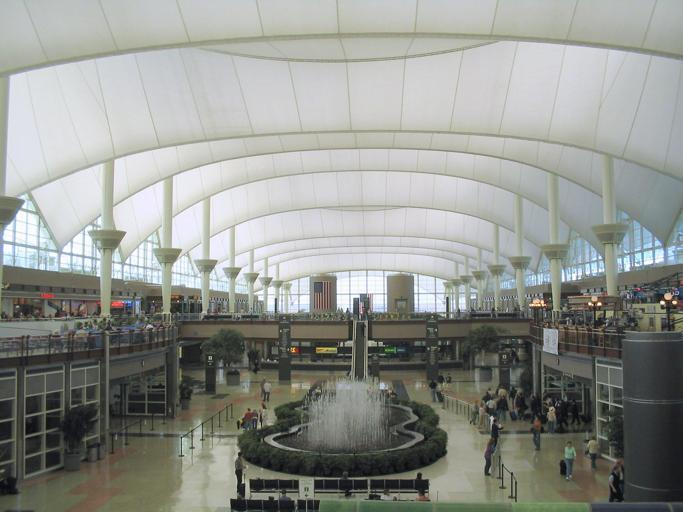

In [56]:

image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [57]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [58]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([2, 150, 128, 128])


In [59]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

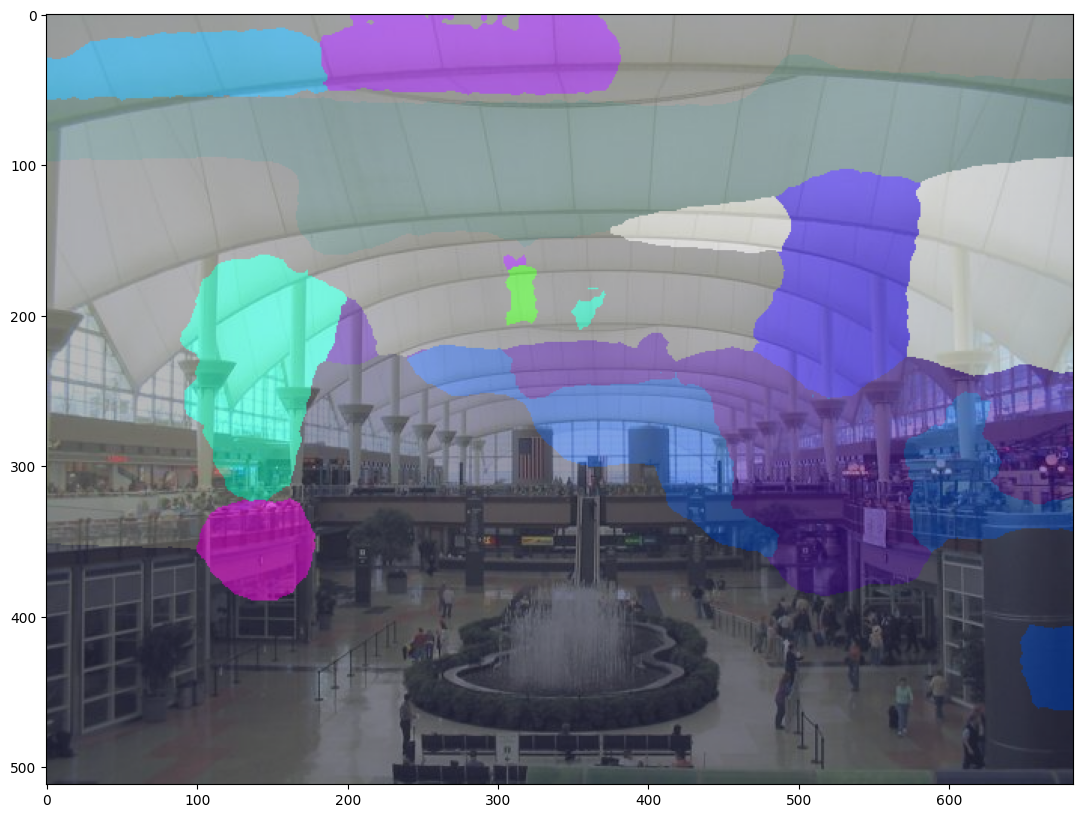

In [63]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

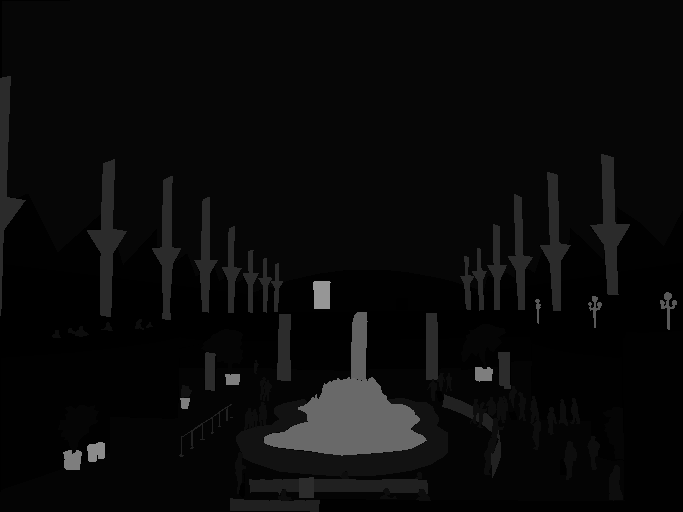

In [61]:

map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


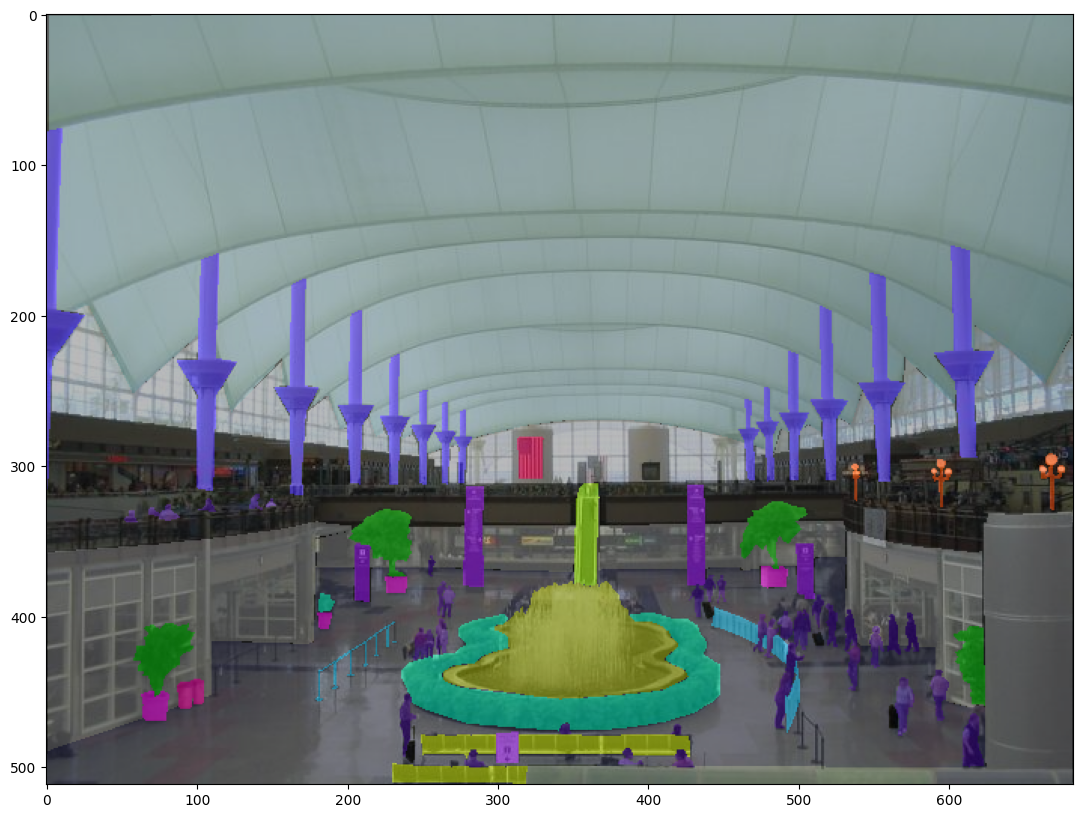

In [62]:

# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [64]:
seg.unique()

tensor([  0,   3,   5,   8,  12,  14,  17,  19,  42,  43,  82, 125])

In [65]:
model.config.id2label[37]

'bathtub'

In [66]:
np.unique(map)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255], dtype=uint8)

In [67]:
map

array([[255, 255, 255, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       ...,
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0,   0]], dtype=uint8)